In [1]:
import random
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from fancyimpute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [3]:
tree = ET.parse('./Buy Side Dictionary.xml')
root = tree.getroot()
#extract legal value
value_nodes = root.findall('ListsOfValues')
ID = []
Validation = []
Value = []
for node in value_nodes:
    value_list = node.findall('ListOfValue')
    for node in value_list:
        node_id = node.attrib['ID']
        ID.append(node_id)
        validation = node.findall('Validation')
        value = node.findall('Value')
        value_list = []
        for node in validation:
            Validation.append(node.attrib)
        for node in value:
            value_list.append(node.text)
        Value.append(value_list)
legal_value = pd.concat([pd.DataFrame(ID, columns=['ID']), pd.DataFrame(Validation)], axis=1)
legal_value['legal_value'] = Value
legal_value.head()

ID BaseType MinValue MaxValue MaxLength  \
0                WIP Wet Category     text                        1000   
1                     Process Key     text                          50   
2            Set Variance to Zero     text                           3   
3  Case Rounded / Individual Pick     text                         100   
4             Supplier Item Group     text                          50   

  InputMask                                        legal_value  
0            [Spirits + Spirits + Vodka + Vodka, Spirits + ...  
1            [11 - Food, 15 - Pubs and Bars Food, 3 - Direc...  
2                                                    [Yes, No]  
3                              [Individual Pick, Case Rounded]  
4            [Q - FRESH MEAT - CHILLED, W - SUNDRY - AMBIEN...

In [4]:
#extract attribute and corresponding legal value and ID
attrib_nodes = root.findall('AttributeList')
attrib_name = []
derived = []
validation = []
value = []
for node in attrib_nodes:
    attrib_node = node.findall('Attribute')
    for node in attrib_node:
        derived.append(node.attrib['Derived'])
        name_node = node.findall('Name')
        validation_node = node.findall('Validation')
        value_node = node.findall('ListOfValueLink')
        if name_node:
            for node in name_node:
                attrib_name.append(node.text)
        else:
            attrib_name.append(np.nan)
        if validation_node:
            for node in validation_node:
                validation.append(node.attrib)
        else:
            validation.append({'BaseType': '', 'MinValue': '', 'MaxValue': '', 'MaxLength': '', 'InputMask': ''})
        if value_node:
            for node in value_node:
                value.append(node.attrib['ListOfValueID'])
        else:
            value.append(np.nan)
attrib_df = pd.concat([pd.DataFrame(attrib_name, columns=['Attrib_name']), pd.DataFrame(validation), pd.DataFrame(derived, columns=['Derived']), pd.DataFrame(value, columns=['Value_link'])], axis=1)
attrib_df.shape

(536, 8)

In [5]:
attrib_df.to_csv('attrib_df.csv')

In [6]:
for i in legal_value['ID'].values:
    if i in attrib_df['Value_link'].values:
        basetype = legal_value[legal_value['ID']==i]['BaseType'].values
        attrib_df.loc[attrib_df['Value_link']==i,'BaseType'] = basetype[0]
        minvalue = legal_value[legal_value['ID']==i]['MinValue'].values
        attrib_df.loc[attrib_df['Value_link']==i,'MinValue'] = minvalue[0]
        maxvalue = legal_value[legal_value['ID']==i]['MaxValue'].values
        attrib_df.loc[attrib_df['Value_link']==i,'MaxValue'] = maxvalue[0]
        maxlength = legal_value[legal_value['ID']==i]['MaxLength'].values
        attrib_df.loc[attrib_df['Value_link']==i,'MaxLength'] = maxlength[0]
    else:
        attrib_df.append(legal_value[legal_value['ID']==i])
attrib_df = pd.merge(attrib_df, legal_value[['ID', 'legal_value']], left_on='Value_link', right_on='ID', how='left').drop(['Value_link', 'ID'], axis=1)
set(attrib_df['BaseType'])

{'condition', 'integer', 'isodate', 'number', 'regexp', 'text'}

In [7]:
#extract categorical and numerical attributes from the attribute dataset
cat_attrib = []
num_attrib = []
for i in range(attrib_df.shape[0]):
    if np.array(pd.isna(attrib_df.iloc[i]['legal_value'])).all():
        if attrib_df.iloc[i]['BaseType'] == 'integer' or attrib_df.iloc[i]['BaseType'] == 'number':
            num_attrib.append(attrib_df.iloc[i]['Attrib_name'])
    else:
        cat_attrib.append(attrib_df.iloc[i]['Attrib_name'])  
print(len(num_attrib))

131


In [8]:
def get_leaf3 (df: pd.DataFrame, level3_id: str):
    dummy_mask = ['Dummy' not in x for x in df['<Name>']]
    mask_4 = df['<Parent ID>'] == level3_id
    ids_4 = df[mask_4 & dummy_mask]['<ID>'].values
    ids_5 = df[[x in ids_4 for x in df['<Parent ID>']]]['<ID>'].values
    return df[[x in ids_5 for x in df['<Parent ID>']]]

In [9]:
# define function to get the level 4 items
def get_leaf4 (df: pd.DataFrame, level4_id: str):
    dummy_mask = ['Dummy' not in x for x in df['<Name>']]
    mask_5 = df['<Parent ID>'] == level4_id
    ids_5 = df[mask_5 & dummy_mask]['<ID>'].values
    return df[[x in ids_5 for x in df['<Parent ID>']]]

In [10]:
def remove_derive(attrib, df):
    if len(df) > 0:
        impute_col = set(attrib[attrib['Derived'] == 'false']['Attrib_name'].values) & set(df.columns)
        temp_df = pd.concat([df[['<ID>', '<Name>', '<Parent ID>', '<Object Type Name>']], df[list(impute_col)]], axis=1)
        return temp_df

In [11]:
def drop_nan(df, threshold):
    if len(df) > 0:
        nonzero_col = []
        nan_prop = pd.DataFrame(df.isnull().sum() / df.shape[0])
        nan_prop.rename(columns={0: 'pct'}, inplace=True)
        for i in range(nan_prop.shape[0]):
            if nan_prop.iloc[i]['pct'] < threshold:
                nonzero_col.append(nan_prop.index[i])
        return df[nonzero_col]

In [12]:
def remove_single_attrib(df):
    if len(df) > 0:
        reserve_col = []
        for i in df.columns:
            value_list = []
            for j in df[i]:
                if pd.isnull(j):
                    continue
                elif j not in value_list:
                    value_list.append(j)
            if len(value_list) == 1:
                continue
            else:
                reserve_col.append(i)
        return df[reserve_col]

In [13]:
def create_mask(df, missing_prob=0.2, random_state=None):
    np.random.seed(random_state)
    missing_mask = df.isna()
    mask = np.random.choice([True, False], size=df.shape, p=[missing_prob, 1-missing_prob])
    mask = np.where(missing_mask, False, mask)
    mask_df = df.mask(mask, np.nan)
    return mask_df

In [14]:
def mean_impute_performance(origin_df, imp_df, num_var):
    RMSE = []
    MAE = []
    for i in num_var:
        valid_indices = np.logical_not(np.isnan(origin_df[i]))
        if len(origin_df[i][valid_indices]) > 0:
            true_vals = origin_df[i][valid_indices]
            pred_vals = imp_df[i][valid_indices]          
            rmse = mean_squared_error(true_vals, pred_vals, squared=False)
            RMSE.append(rmse)
            mae = mean_absolute_error(true_vals, pred_vals)
            MAE.append(mae)
    if len(RMSE) > 0 and len(MAE) > 0:
        avg_RMSE = round(sum(RMSE) / len(RMSE), 6)
        avg_MAE = round(sum(MAE) / len(MAE), 6)
        return avg_RMSE, avg_MAE

In [15]:
def mode_impute_performance(origin_df, imp_df, cat_var):
    Accuracy = []
    Precision = []
    Recall = []
    F1_score = []
    for i in cat_var:
        valid_indices = np.logical_not(pd.isna(origin_df[i]))
        true_vals = origin_df[i][valid_indices].astype('string')
        pred_vals = imp_df[i][valid_indices].astype('string')
        accuracy = accuracy_score(true_vals, pred_vals)
        Accuracy.append(accuracy)
        precision = precision_score(true_vals, pred_vals, average='weighted', zero_division=0.0)
        Precision.append(precision)
        recall = recall_score(true_vals, pred_vals, average='weighted', zero_division=0.0)
        Recall.append(recall)
        f1 = f1_score(true_vals, pred_vals, average='weighted')
        F1_score.append(f1)
    if len(Accuracy) > 0 and len(Precision) > 0 and len(Recall) > 0 and len(F1_score) > 0:
        avg_Accuracy = round(sum(Accuracy) / len(Accuracy), 6)
        avg_Precision = round(sum(Precision) / len(Precision), 6)
        avg_Recall = round(sum(Recall) / len(Recall), 6)
        avg_F1 = round(sum(F1_score) / len(F1_score), 6)
        return avg_Accuracy, avg_Precision, avg_Recall, avg_F1

In [16]:
buy_side = pd.read_csv('./Buy_Side.csv', low_memory=False)
random_state = 123

In [47]:
sub_category = []
number_of_rows = []
number_of_columns = []
numbe_of_columns_missing = []
number_of_columns_missing_80 = []
number_of_columns_left = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    sub_category.append(level3_name)
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
    number_of_columns_left.append(clean_df.shape[1])
    number_of_rows.append(temp_df.shape[0])
    number_of_columns.append(temp_df.shape[1])
    missing_cols = temp_df.columns[temp_df.isnull().any()]
    numbe_of_columns_missing.append(len(missing_cols))
    columns_missing_80 = []
    for col in missing_cols:
        num_missing = temp_df[col].isnull().sum()
        percent_missing = num_missing / len(temp_df)
        if percent_missing > 0.8:
            columns_missing_80.append(col)
    number_of_columns_missing_80.append(len(columns_missing_80))
basic_info = pd.DataFrame({'sub_category': sub_category, '# rows': number_of_rows, '# columns': number_of_columns, '# missing columns': numbe_of_columns_missing, '# missing columns 80%': number_of_columns_missing_80, '# columns left': number_of_columns_left})

In [48]:
basic_info

sub_category  # rows  # columns  # missing columns  \
0                       Chicken     252        368                347   
1                        Turkey      51        368                347   
2                          Duck      39        368                346   
3                 Butter & Fats      69        368                347   
4                        Cheese     339        368                347   
..                          ...     ...        ...                ...   
142                Bottled Wine    1571        368                352   
143          Wet Dummy Level: 3       0        368                  0   
144    New Dummy Ingredient Dry       0        368                  0   
145    New Dummy Ingredient Wet       0        368                  0   
146  IPDC Landing Area: Level 3     120        368                345   

     # missing columns 80%  # columns left  
0                      169              39  
1                      170              31  
2                      166              38  
3                      170              31  
4                      168              38  
..                     ...             ...  
142                    157              39  
143                      0              39  
144                      0              39  
145                      0              39  
146                    316               5  

[147 rows x 6 columns]

In [19]:
#Experiment1_1_1: mean imputation for numeric columns (20% mask)
sub_category = []
RMSE = []
MAE = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
        cat_var = list(set(cat_attrib) & set(clean_df.columns))
        num_var = list(set(num_attrib) & set(clean_df.columns))
        if len(cat_var) > 0 and len(num_var) > 0:
            sub_category.append(level3_name)
            mask_df = create_mask(clean_df, missing_prob=0.2, random_state=random_state)
            mean_imputed = mask_df[num_var].fillna(mask_df[num_var].mean())
            mean_imputed_RMSE = mean_impute_performance(clean_df, mean_imputed, num_var)[0]
            RMSE.append(mean_imputed_RMSE)
            mean_imputed_MAE = mean_impute_performance(clean_df, mean_imputed, num_var)[1]
            MAE.append(mean_imputed_MAE)
exp1_1_1 = pd.DataFrame({'Sub_category': sub_category, 'RMSE': RMSE, 'MAE': MAE})

In [21]:
#Experiment1_1_2: mean imputation for numeric columns (40% mask)
sub_category = []
RMSE = []
MAE = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
        cat_var = list(set(cat_attrib) & set(clean_df.columns))
        num_var = list(set(num_attrib) & set(clean_df.columns))
        if len(cat_var) > 0 and len(num_var) > 0:
            mask_df = create_mask(clean_df, missing_prob=0.4, random_state=random_state)
            mask_df.dropna(axis=1, how='all', inplace=True)
            num_var = list(set(num_var) & set(mask_df.columns))
            mean_imputed = mask_df[num_var].fillna(mask_df[num_var].mean())
            mean_imputed_metric = mean_impute_performance(clean_df, mean_imputed, num_var)
            if mean_imputed_metric is not None:
                sub_category.append(level3_name)
                mean_imputed_RMSE = mean_imputed_metric[0]
                RMSE.append(mean_imputed_RMSE)
                mean_imputed_MAE = mean_imputed_metric[1]
                MAE.append(mean_imputed_MAE)
exp1_1_2 = pd.DataFrame({'Sub_category': sub_category, 'RMSE': RMSE, 'MAE': MAE})

In [22]:
#Experiment1_1_3: mean imputation for numeric columns (60% mask)
sub_category = []
RMSE = []
MAE = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
        cat_var = list(set(cat_attrib) & set(clean_df.columns))
        num_var = list(set(num_attrib) & set(clean_df.columns))
        if len(cat_var) > 0 and len(num_var) > 0:
            mask_df = create_mask(clean_df, missing_prob=0.6, random_state=random_state)
            mask_df.dropna(axis=1, how='all', inplace=True)
            num_var = list(set(num_var) & set(mask_df.columns))
            mean_imputed = mask_df[num_var].fillna(mask_df[num_var].mean())
            mean_imputed_metric = mean_impute_performance(clean_df, mean_imputed, num_var)
            if mean_imputed_metric is not None:
                sub_category.append(level3_name)
                mean_imputed_RMSE = mean_impute_performance(clean_df, mean_imputed, num_var)[0]
                RMSE.append(mean_imputed_RMSE)
                mean_imputed_MAE = mean_impute_performance(clean_df, mean_imputed, num_var)[1]
                MAE.append(mean_imputed_MAE)
exp1_1_3 = pd.DataFrame({'Sub_category': sub_category, 'RMSE': RMSE, 'MAE': MAE})

In [23]:
#Experiment1_1_4: mean imputation for numeric columns (80% mask)
sub_category = []
RMSE = []
MAE = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
        cat_var = list(set(cat_attrib) & set(clean_df.columns))
        num_var = list(set(num_attrib) & set(clean_df.columns))
        if len(cat_var) > 0 and len(num_var) > 0:
            mask_df = create_mask(clean_df, missing_prob=0.8, random_state=random_state)
            mask_df.dropna(axis=1, how='all', inplace=True)
            num_var = list(set(num_var) & set(mask_df.columns))
            mean_imputed = mask_df[num_var].fillna(mask_df[num_var].mean())
            mean_imputed_metric = mean_impute_performance(clean_df, mean_imputed, num_var)
            if mean_imputed_metric is not None:
                sub_category.append(level3_name)
                mean_imputed_RMSE = mean_impute_performance(clean_df, mean_imputed, num_var)[0]
                RMSE.append(mean_imputed_RMSE)
                mean_imputed_MAE = mean_impute_performance(clean_df, mean_imputed, num_var)[1]
                MAE.append(mean_imputed_MAE)
exp1_1_4 = pd.DataFrame({'Sub_category': sub_category, 'RMSE': RMSE, 'MAE': MAE})

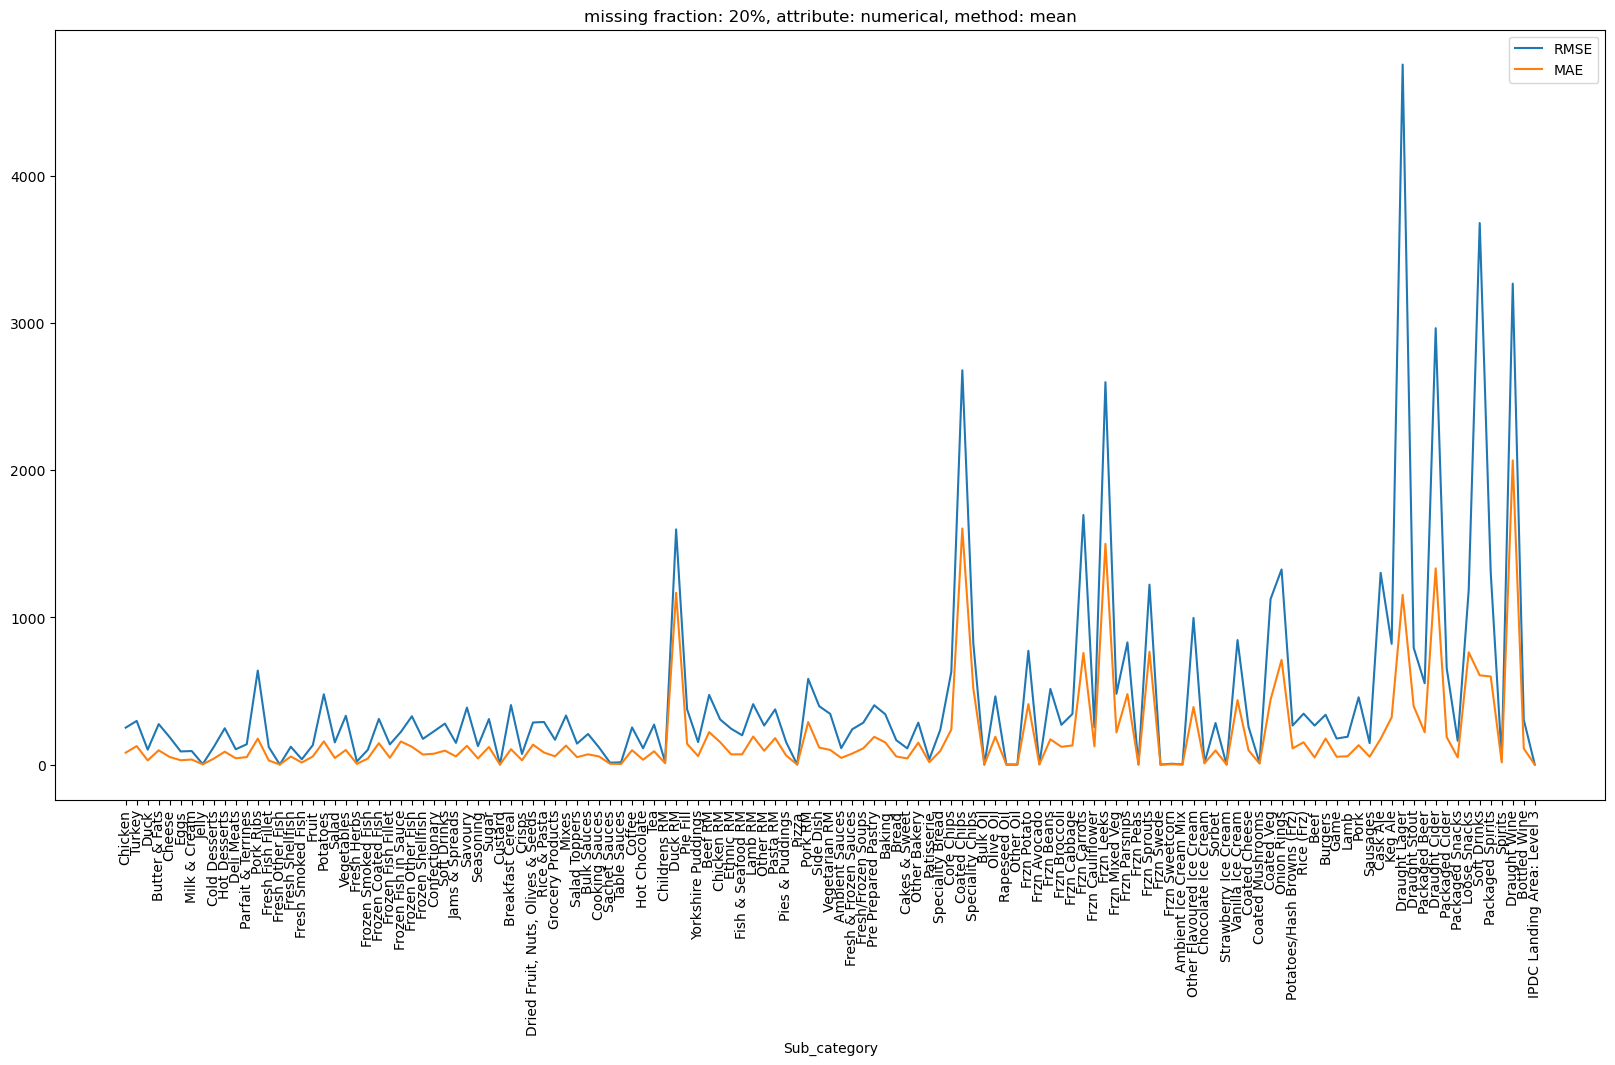

In [24]:
exp1_1_1.set_index('Sub_category')[['RMSE', 'MAE']].plot(figsize=(20,10), kind='line')
plt.xticks(range(len(exp1_1_1['Sub_category'])), exp1_1_1['Sub_category'], rotation=90, fontsize=10)
plt.xlabel('Sub_category')
plt.title('missing fraction: 20%, attribute: numerical, method: mean')
plt.show()

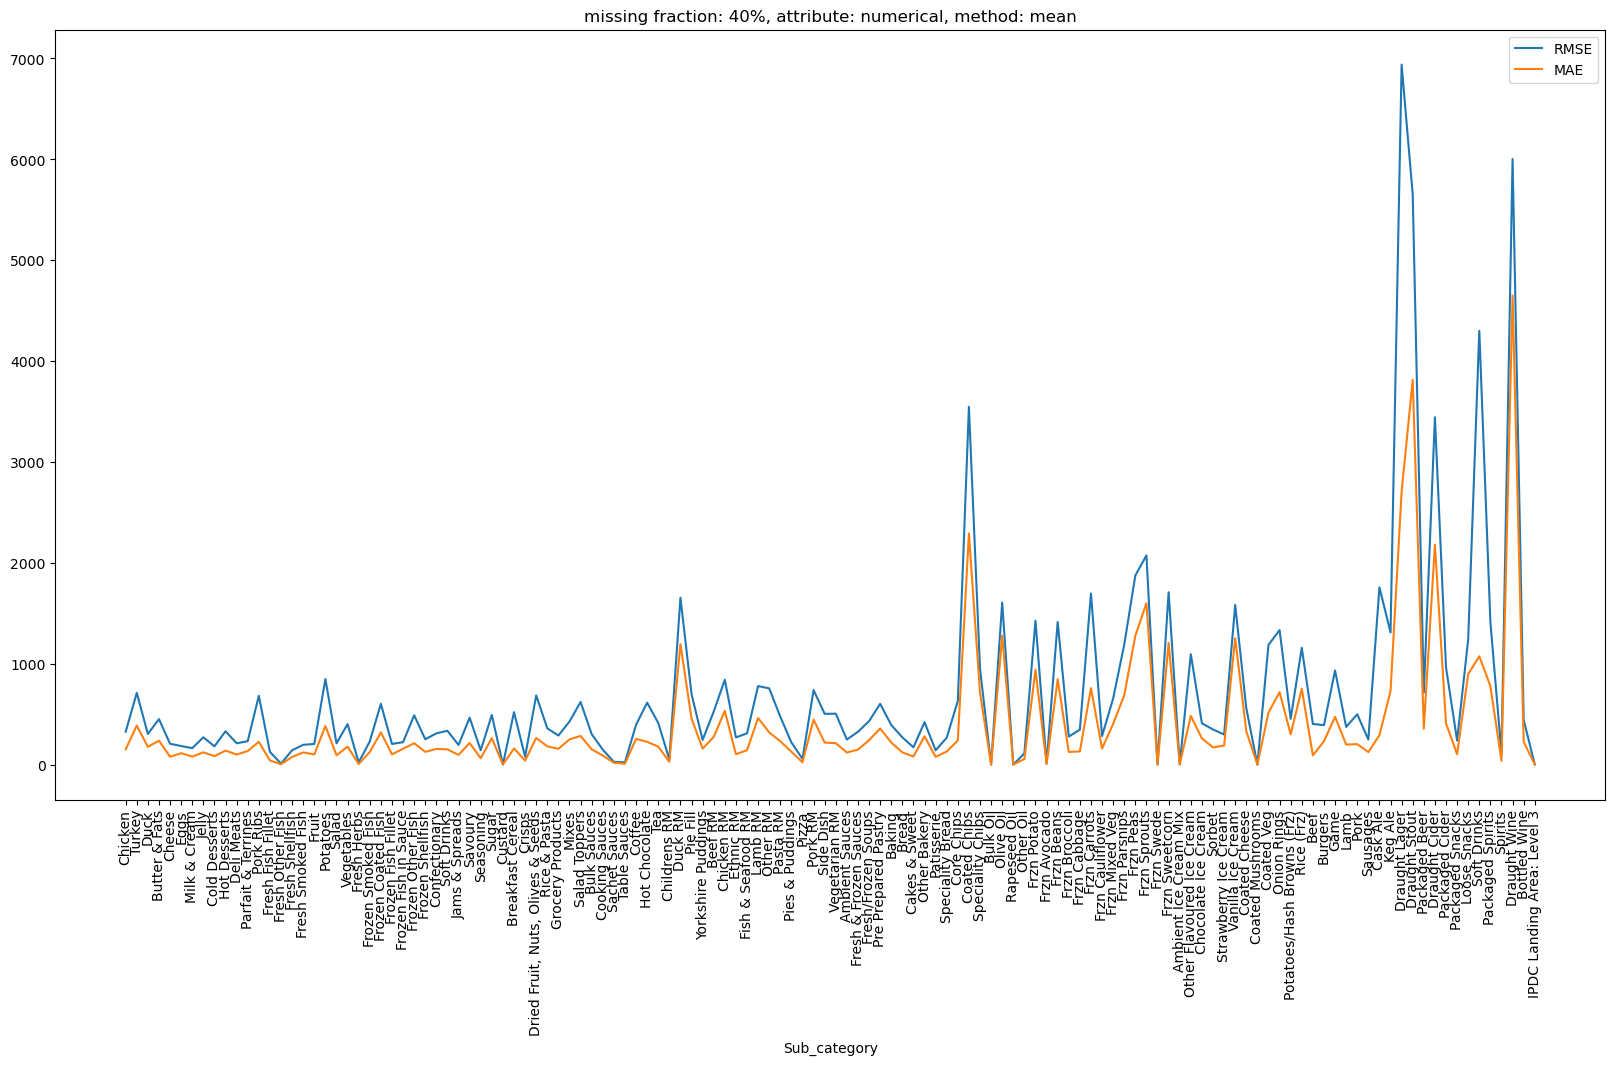

In [25]:
exp1_1_2.set_index('Sub_category')[['RMSE', 'MAE']].plot(figsize=(20,10), kind='line')
plt.xticks(range(len(exp1_1_2['Sub_category'])), exp1_1_2['Sub_category'], rotation=90, fontsize=10)
plt.xlabel('Sub_category')
plt.title('missing fraction: 40%, attribute: numerical, method: mean')
plt.show()

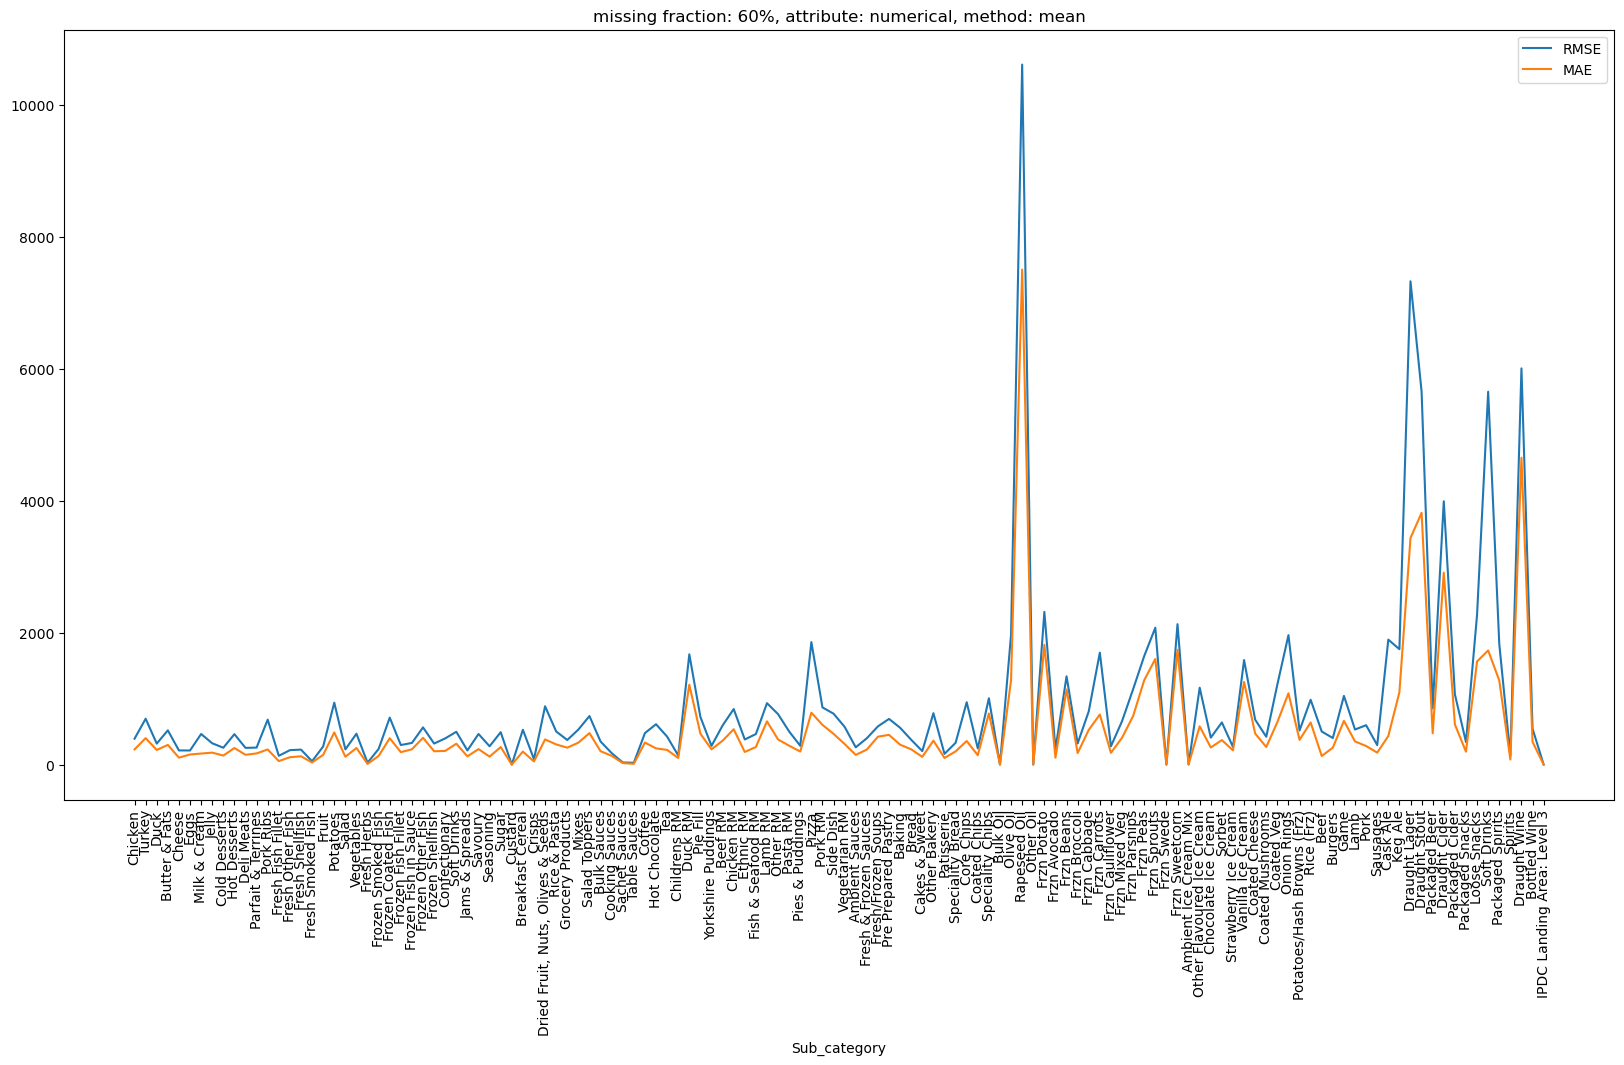

In [26]:
exp1_1_3.set_index('Sub_category')[['RMSE', 'MAE']].plot(figsize=(20,10), kind='line')
plt.xticks(range(len(exp1_1_3['Sub_category'])), exp1_1_3['Sub_category'], rotation=90, fontsize=10)
plt.xlabel('Sub_category')
plt.title('missing fraction: 60%, attribute: numerical, method: mean')
plt.show()

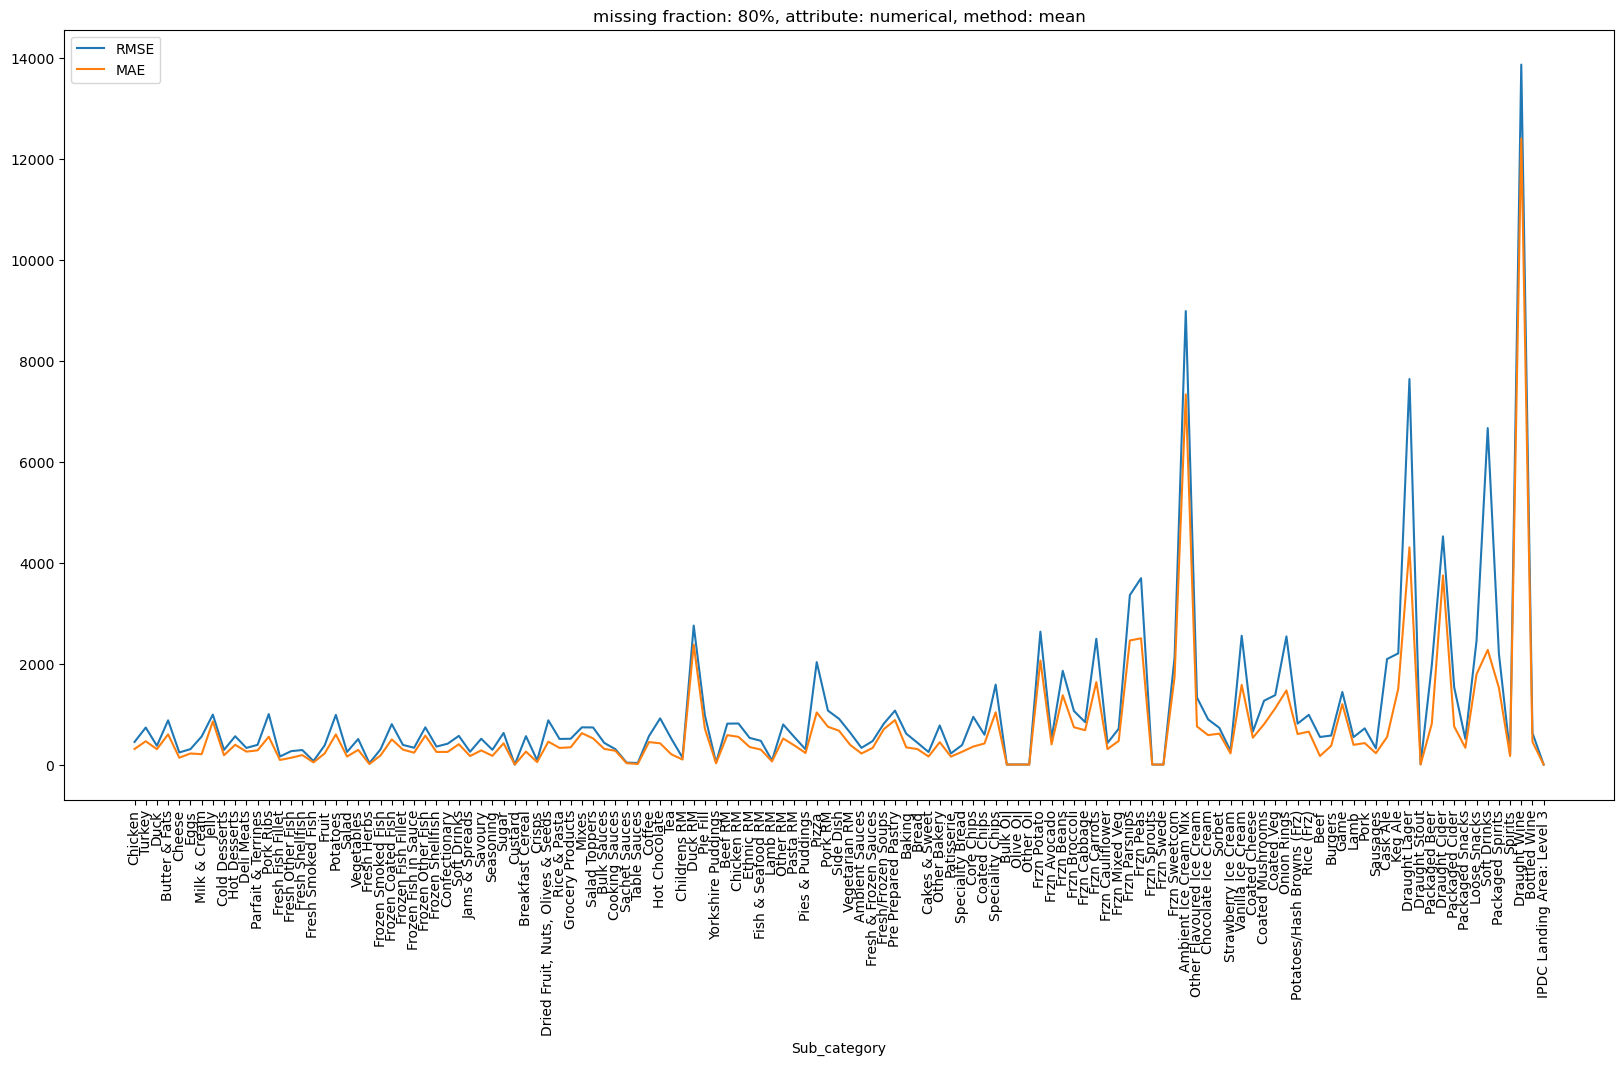

In [27]:
exp1_1_4.set_index('Sub_category')[['RMSE', 'MAE']].plot(figsize=(20,10), kind='line')
plt.xticks(range(len(exp1_1_4['Sub_category'])), exp1_1_4['Sub_category'], rotation=90, fontsize=10)
plt.xlabel('Sub_category')
plt.title('missing fraction: 80%, attribute: numerical, method: mean')
plt.show()

In [30]:
#Experiment1_2_1: mode imputation for categorical columns (20% mask)
sub_category = []
Accuracy = []
Precision = []
Recall = []
F1_score = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
        cat_var = list(set(cat_attrib) & set(clean_df.columns))
        num_var = list(set(num_attrib) & set(clean_df.columns))
        if len(cat_var) > 0 and len(num_var) > 0:
            sub_category.append(level3_name)
            mask_df = create_mask(clean_df, missing_prob=0.2, random_state=random_state)
            mode_imputed = pd.DataFrame()
            for j in cat_var:
                col_val = mask_df[j].dropna().tolist()
                if len(col_val) > 0:
                    mode_val = statistics.mode(col_val)
                    col_imputed = mask_df[j].fillna(mode_val)
                else:
                    col_imputed = mask_df[j].fillna(0)
                mode_imputed = pd.concat([mode_imputed, col_imputed], axis=1)
            mode_imputed_accuracy = mode_impute_performance(clean_df, mode_imputed, cat_var)[0]
            Accuracy.append(mode_imputed_accuracy)
            mode_imputed_precision = mode_impute_performance(clean_df, mode_imputed, cat_var)[1]
            Precision.append(mode_imputed_precision)
            mode_imputed_recall = mode_impute_performance(clean_df, mode_imputed, cat_var)[2]
            Recall.append(mode_imputed_recall)
            mode_imputed_F1 = mode_impute_performance(clean_df, mode_imputed, cat_var)[3]
            F1_score.append(mode_imputed_F1)
exp1_2_1 = pd.DataFrame({'Sub_category': sub_category, 'Accuracy': Accuracy, 'Precision': Precision, 'Recall': Recall, 'F1_score': F1_score})

In [31]:
#Experiment1_2_2: mode imputation for categorical columns (40% mask)
sub_category = []
Accuracy = []
Precision = []
Recall = []
F1_score = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
        cat_var = list(set(cat_attrib) & set(clean_df.columns))
        num_var = list(set(num_attrib) & set(clean_df.columns))
        if len(cat_var) > 0 and len(num_var) > 0:
            sub_category.append(level3_name)
            mask_df = create_mask(clean_df, missing_prob=0.4, random_state=random_state)
            mask_df.dropna(axis=1, how='all', inplace=True)
            cat_var = list(set(cat_var) & set(mask_df.columns))
            mode_imputed = pd.DataFrame()
            for j in cat_var:
                col_val = mask_df[j].dropna().tolist()
                mode_val = statistics.mode(col_val)
                col_imputed = mask_df[j].fillna(mode_val)
                mode_imputed = pd.concat([mode_imputed, col_imputed], axis=1)
            mode_imputed_accuracy = mode_impute_performance(clean_df, mode_imputed, cat_var)[0]
            Accuracy.append(mode_imputed_accuracy)
            mode_imputed_precision = mode_impute_performance(clean_df, mode_imputed, cat_var)[1]
            Precision.append(mode_imputed_precision)
            mode_imputed_recall = mode_impute_performance(clean_df, mode_imputed, cat_var)[2]
            Recall.append(mode_imputed_recall)
            mode_imputed_F1 = mode_impute_performance(clean_df, mode_imputed, cat_var)[3]
            F1_score.append(mode_imputed_F1)
exp1_2_2 = pd.DataFrame({'Sub_category': sub_category, 'Accuracy': Accuracy, 'Precision': Precision, 'Recall': Recall, 'F1_score': F1_score})

In [32]:
#Experiment1_2_3: mode imputation for categorical columns (60% mask)
sub_category = []
Accuracy = []
Precision = []
Recall = []
F1_score = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
        cat_var = list(set(cat_attrib) & set(clean_df.columns))
        num_var = list(set(num_attrib) & set(clean_df.columns))
        if len(cat_var) > 0 and len(num_var) > 0:
            sub_category.append(level3_name)
            mask_df = create_mask(clean_df, missing_prob=0.6, random_state=random_state)
            mask_df.dropna(axis=1, how='all', inplace=True)
            cat_var = list(set(cat_var) & set(mask_df.columns))
            mode_imputed = pd.DataFrame()
            for j in cat_var:
                col_val = mask_df[j].dropna().tolist()
                mode_val = statistics.mode(col_val)
                col_imputed = mask_df[j].fillna(mode_val)
                mode_imputed = pd.concat([mode_imputed, col_imputed], axis=1)
            mode_imputed_accuracy = mode_impute_performance(clean_df, mode_imputed, cat_var)[0]
            Accuracy.append(mode_imputed_accuracy)
            mode_imputed_precision = mode_impute_performance(clean_df, mode_imputed, cat_var)[1]
            Precision.append(mode_imputed_precision)
            mode_imputed_recall = mode_impute_performance(clean_df, mode_imputed, cat_var)[2]
            Recall.append(mode_imputed_recall)
            mode_imputed_F1 = mode_impute_performance(clean_df, mode_imputed, cat_var)[3]
            F1_score.append(mode_imputed_F1)
exp1_2_3 = pd.DataFrame({'Sub_category': sub_category, 'Accuracy': Accuracy, 'Precision': Precision, 'Recall': Recall, 'F1_score': F1_score})

In [33]:
#Experiment1_2_4: mode imputation for categorical columns (80% mask)
sub_category = []
Accuracy = []
Precision = []
Recall = []
F1_score = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
        cat_var = list(set(cat_attrib) & set(clean_df.columns))
        num_var = list(set(num_attrib) & set(clean_df.columns))
        if len(cat_var) > 0 and len(num_var) > 0:
            
            mask_df = create_mask(clean_df, missing_prob=0.8, random_state=random_state)
            mask_df.dropna(axis=1, how='all', inplace=True)
            cat_var = list(set(cat_var) & set(mask_df.columns))
            mode_imputed = pd.DataFrame()
            for j in cat_var:
                col_val = mask_df[j].dropna().tolist()
                mode_val = statistics.mode(col_val)
                col_imputed = mask_df[j].fillna(mode_val)
                mode_imputed = pd.concat([mode_imputed, col_imputed], axis=1)
            mode_imputed_metric = mode_impute_performance(clean_df, mode_imputed, cat_var)
            if mode_imputed_metric is not None:
                sub_category.append(level3_name)
                mode_imputed_accuracy = mode_impute_performance(clean_df, mode_imputed, cat_var)[0]
                Accuracy.append(mode_imputed_accuracy)
                mode_imputed_precision = mode_impute_performance(clean_df, mode_imputed, cat_var)[1]
                Precision.append(mode_imputed_precision)
                mode_imputed_recall = mode_impute_performance(clean_df, mode_imputed, cat_var)[2]
                Recall.append(mode_imputed_recall)
                mode_imputed_F1 = mode_impute_performance(clean_df, mode_imputed, cat_var)[3]
                F1_score.append(mode_imputed_F1)
exp1_2_4 = pd.DataFrame({'Sub_category': sub_category, 'Accuracy': Accuracy, 'Precision': Precision, 'Recall': Recall, 'F1_score': F1_score})

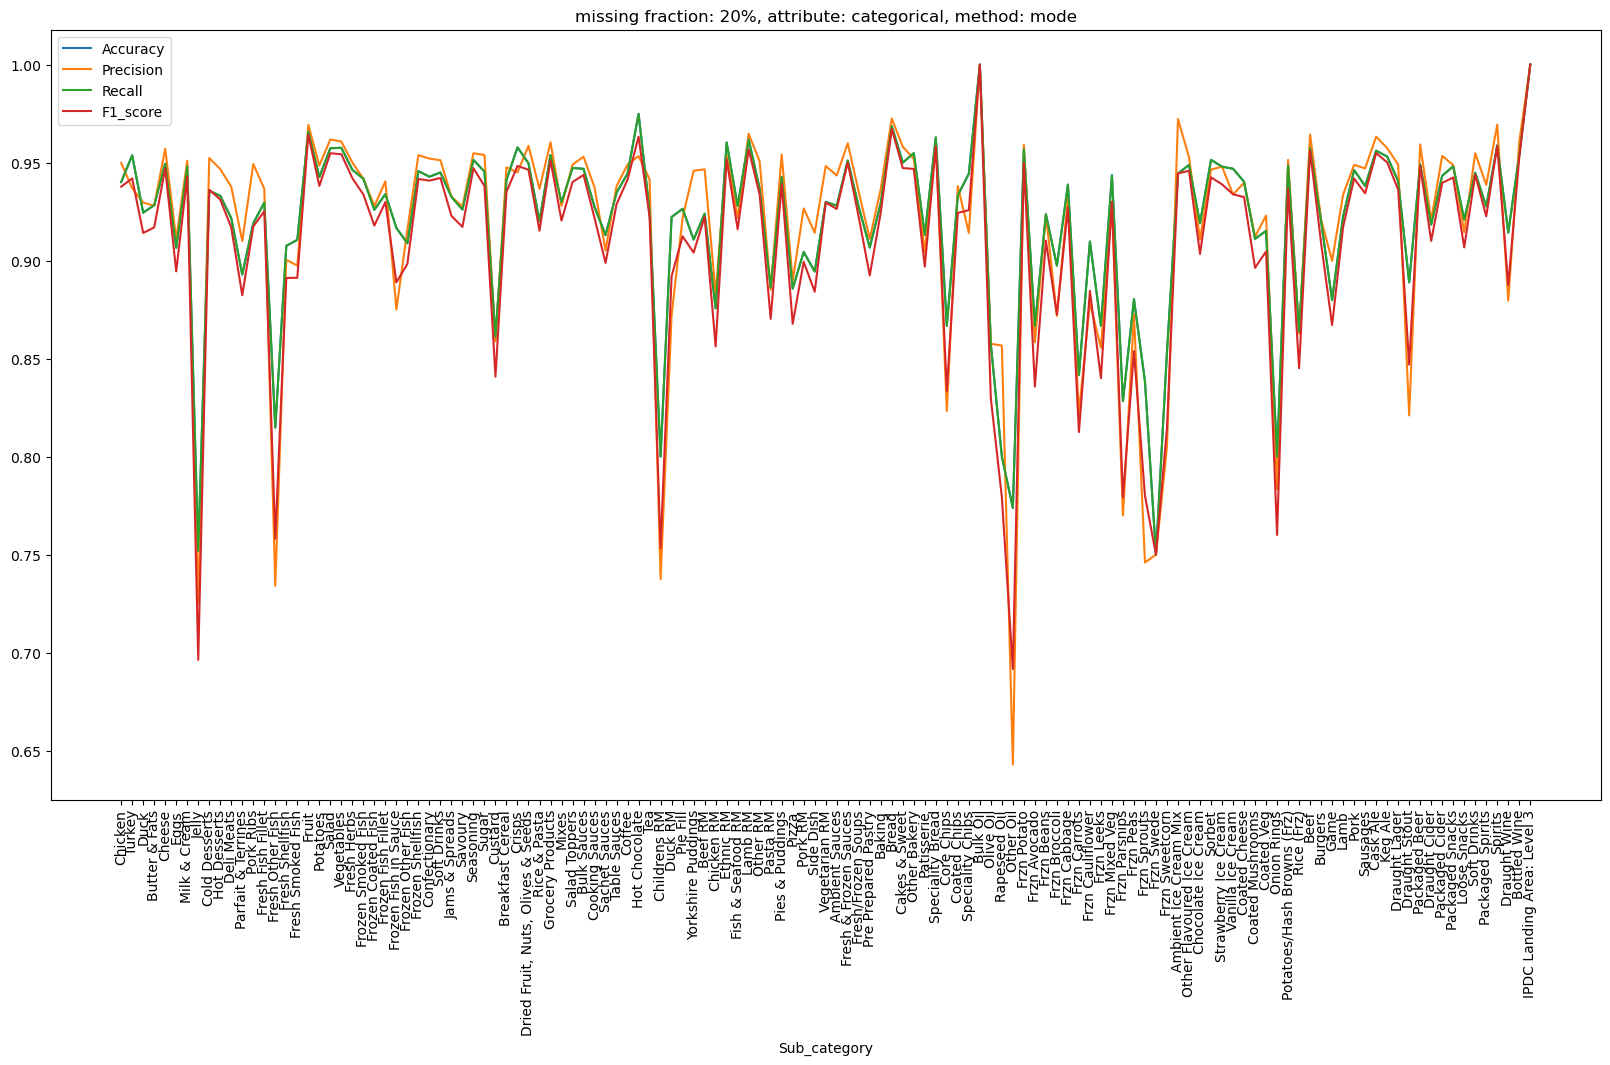

In [34]:
exp1_2_1.set_index('Sub_category')[['Accuracy', 'Precision', 'Recall', 'F1_score']].plot(figsize=(20,10), kind='line')
plt.xticks(range(len(exp1_2_1['Sub_category'])), exp1_2_1['Sub_category'], rotation=90, fontsize=10)
plt.xlabel('Sub_category')
plt.title('missing fraction: 20%, attribute: categorical, method: mode')
plt.show()

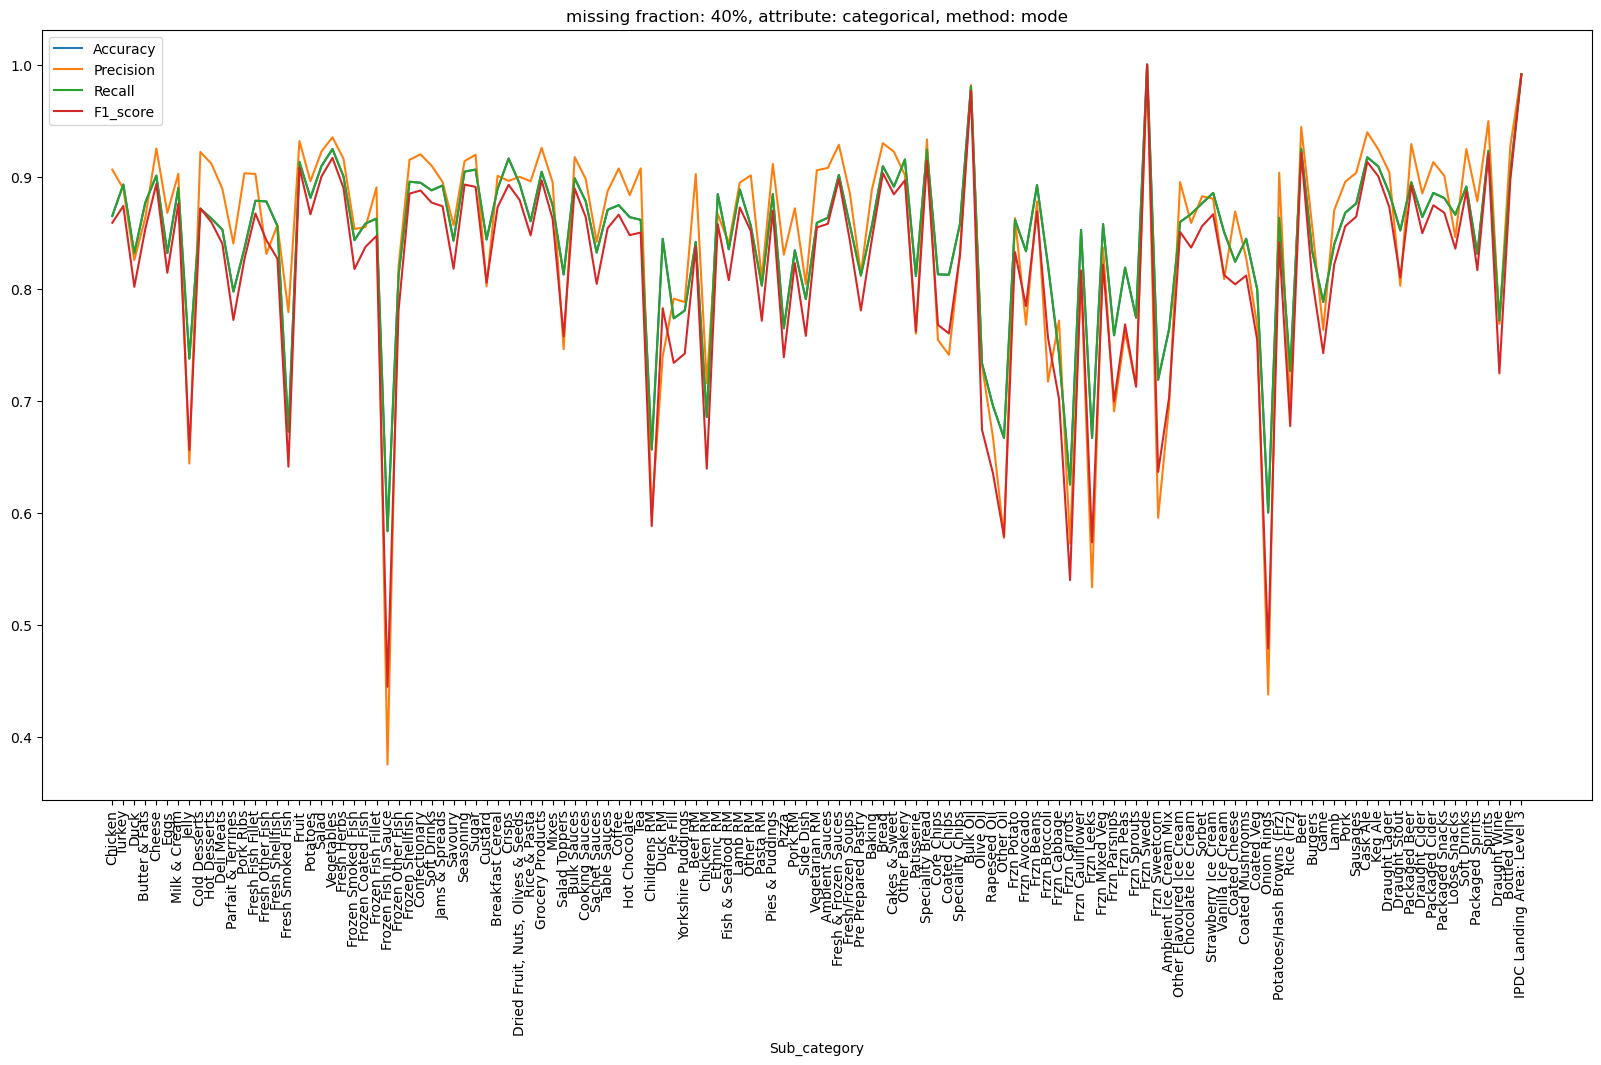

In [35]:
exp1_2_2.set_index('Sub_category')[['Accuracy', 'Precision', 'Recall', 'F1_score']].plot(figsize=(20,10), kind='line')
plt.xticks(range(len(exp1_2_2['Sub_category'])), exp1_2_2['Sub_category'], rotation=90, fontsize=10)
plt.xlabel('Sub_category')
plt.title('missing fraction: 40%, attribute: categorical, method: mode')
plt.show()

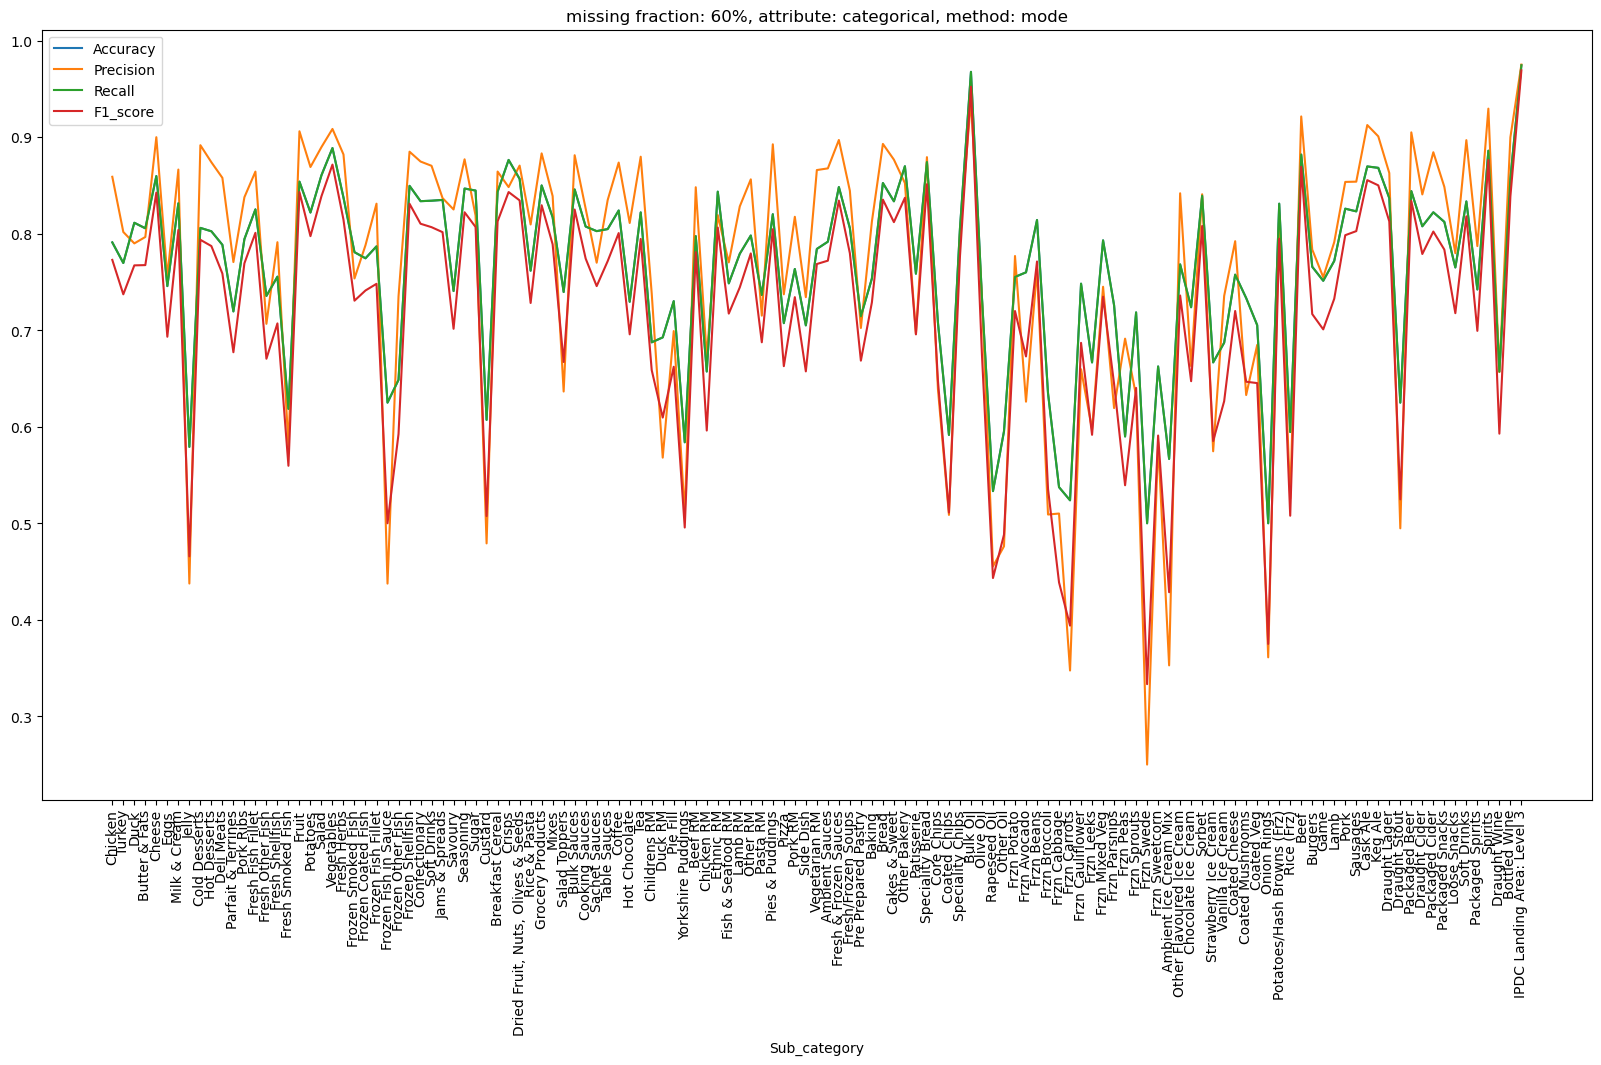

In [36]:
exp1_2_3.set_index('Sub_category')[['Accuracy', 'Precision', 'Recall', 'F1_score']].plot(figsize=(20,10), kind='line')
plt.xticks(range(len(exp1_2_3['Sub_category'])), exp1_2_3['Sub_category'], rotation=90, fontsize=10)
plt.xlabel('Sub_category')
plt.title('missing fraction: 60%, attribute: categorical, method: mode')
plt.show()

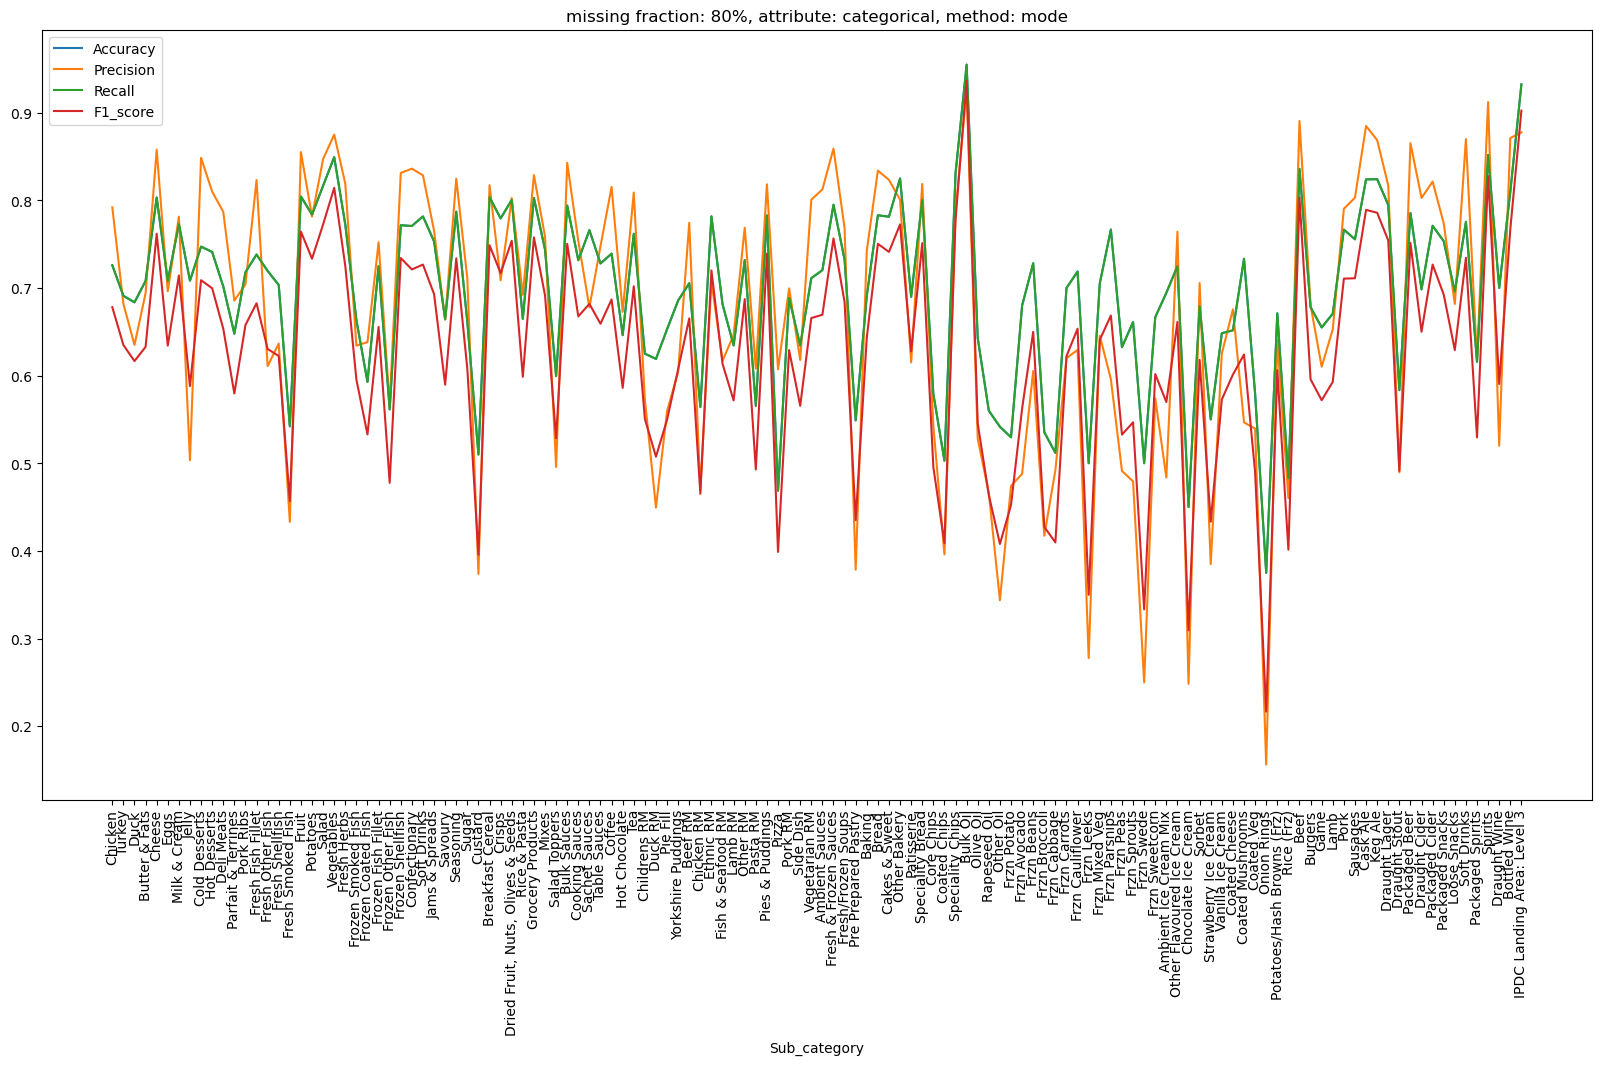

In [37]:
exp1_2_4.set_index('Sub_category')[['Accuracy', 'Precision', 'Recall', 'F1_score']].plot(figsize=(20,10), kind='line')
plt.xticks(range(len(exp1_2_4['Sub_category'])), exp1_2_4['Sub_category'], rotation=90, fontsize=10)
plt.xlabel('Sub_category')
plt.title('missing fraction: 80%, attribute: categorical, method: mode')
plt.show()

In [38]:
def encode_cat(df):
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoded = encoder.fit_transform(df.fillna('missing'))
    encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(), index=df.index)
    temp_encoded_df = encoded_df.drop(columns=encoded_df.columns[encoded_df.columns.str.contains('missing')])
    missing_mask = df.isnull()
    missing_indices = missing_mask[missing_mask[df.columns[0]]].index.to_list()
    if len(missing_indices) > 0:
        col_name = df.columns[0] + '_missing'
        col_index = encoded_df.columns.get_loc(col_name)
        for j in temp_encoded_df.columns:
            if j.split('_')[0] == i:
                temp_encoded_df.loc[missing_indices, j] = np.nan
    else:
        col_name = None
        col_index = None
    return encoder, col_name, col_index, temp_encoded_df

In [39]:
def knn_impute_num(train_df, test_df, n_neighbors=5):
    knn_mod = KNNImputer(n_neighbors=n_neighbors)
    knn_mod.fit(train_df.values)
    knn_imp = knn_mod.transform(test_df.values)
    imp_df = pd.DataFrame(knn_imp, columns=test_df.columns, index=test_df.index)
    return imp_df

In [40]:
def knn_impute_num_performance(origin_df, imp_df, num_var):
    RMSE = []
    MAE = []
    for i in num_var:
        true_df = origin_df.loc[imp_df.index]
        valid_indices = np.logical_not(np.isnan(true_df[i]))
        if len(true_df[i][valid_indices]) > 0:
            true_vals = true_df[i][valid_indices]
            pred_vals = imp_df[i][valid_indices]
            rmse = mean_squared_error(true_vals, pred_vals, squared=False)
            RMSE.append(rmse)
            mae = mean_absolute_error(true_vals, pred_vals)
            MAE.append(mae)
    if len(RMSE) > 0 and len(MAE) > 0:
        avg_RMSE = round(sum(RMSE) / len(RMSE), 6)
        avg_MAE = round(sum(MAE) / len(MAE), 6)
        return avg_RMSE, avg_MAE

In [41]:
def knn_impute_cat(df_concat, cat_train, cat_test, cat_var, n_neighbors=5):
    imputer = KNNImputer(n_neighbors=5)
    imputer.fit(cat_train)
    imputed_df = pd.DataFrame(imputer.transform(cat_test), columns=cat_test.columns, index=cat_test.index)
    final_impute = pd.DataFrame()
    for i in cat_var:
        encoder = encode_cat(df_concat[[i]])[0]
        col_name = encode_cat(df_concat[[i]])[1]
        col_index = encode_cat(df_concat[[i]])[2]
        missing_mask = df_concat[i].isnull()
        missing_indices = missing_mask[missing_mask].index.to_list()
        missing_indices = list(set(missing_indices) & set(cat_test.index))
        for j in missing_indices:
            col_list1 = []
            for k in imputed_df.columns:
                if k.split('_')[0] == i:
                    col_list1.append(k)
            max_col = imputed_df.loc[j, col_list1].idxmax()
            imputed_df.loc[j, col_list1] = 0
            imputed_df.loc[j, max_col] = 1
        col_list2 = []
        for m in imputed_df.columns:
            if m.split('_')[0] == i:
                col_list2.append(m)
        temp_df = imputed_df[col_list2]
        if col_name:
            temp_df.insert(loc=col_index, column=col_name, value=0)
        temp_df = pd.DataFrame(encoder.inverse_transform(temp_df), columns=[i], index=cat_test.index)
        final_impute = pd.concat([final_impute, temp_df], axis=1)
    return final_impute

In [42]:
def knn_impute_cat_performance(origin_df, imp_df, cat_var):
    Accuracy = []
    Precision = []
    Recall = []
    F1_score = []
    for i in cat_var:
        true_df = origin_df.loc[imp_df.index]
        valid_indices = np.logical_not(pd.isna(true_df[i]))
        if len(true_df[i][valid_indices]) > 0:
            true_vals = true_df[i][valid_indices].astype('string')
            pred_vals = imp_df[i][valid_indices].astype('string')
            accuracy = accuracy_score(true_vals, pred_vals)
            Accuracy.append(accuracy)
            precision = precision_score(true_vals, pred_vals, average='weighted', zero_division=0.0)
            Precision.append(precision)
            recall = recall_score(true_vals, pred_vals, average='weighted', zero_division=0.0)
            Recall.append(recall)
            f1 = f1_score(true_vals, pred_vals, average='weighted')
            F1_score.append(f1)
    if len(Accuracy) > 0 and len(Precision) > 0 and len(Recall) > 0 and len(F1_score) > 0:
        avg_Accuracy = round(sum(Accuracy) / len(Accuracy), 6)
        avg_Precision = round(sum(Precision) / len(Precision), 6)
        avg_Recall = round(sum(Recall) / len(Recall), 6)
        avg_F1 = round(sum(F1_score) / len(F1_score), 6)
        return avg_Accuracy, avg_Precision, avg_Recall, avg_F1

In [45]:
#Experiment2_1_1: KNN imputation for numeric columns
sub_category = []
RMSE = []
MAE = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
        num_var = list(set(num_attrib) & set(clean_df.columns))
        if len(num_var) > 0:
            mask_df = create_mask(clean_df, missing_prob=0.2, random_state=random_state)
            train_df, test_df = train_test_split(mask_df[num_var], test_size=0.2, random_state=random_state)
            train_df.dropna(axis=1, how='all', inplace=True)
            update_test_df = test_df[train_df.columns]
            num_var = list(set(num_var) & set(train_df.columns))
            if not train_df[num_var].empty:
                scaler = StandardScaler()
                num_train_scaled = pd.DataFrame(scaler.fit_transform(train_df[num_var]), columns=num_var, index=train_df.index)
                num_test_scaled = pd.DataFrame(scaler.transform(update_test_df[num_var]), columns=num_var, index=update_test_df.index)
                knn_imputed_test = knn_impute_num(num_train_scaled, num_test_scaled, n_neighbors=5)
                knn_imputed_test = pd.DataFrame(scaler.inverse_transform(knn_imputed_test), columns=num_var, index=update_test_df.index)
                knn_imputed_metric = knn_impute_num_performance(clean_df, knn_imputed_test, num_var)
                if knn_imputed_metric is not None:
                    sub_category.append(level3_name)
                    knn_imputed_RMSE = knn_impute_num_performance(clean_df, knn_imputed_test, num_var)[0]
                    RMSE.append(knn_imputed_RMSE)
                    knn_imputed_MAE = knn_impute_num_performance(clean_df, knn_imputed_test, num_var)[1]
                    MAE.append(knn_imputed_MAE)
exp2_1_1 = pd.DataFrame({'Sub_category': sub_category, 'RMSE': RMSE, 'MAE': MAE})

In [49]:
#Experiment2_1_2: KNN imputation for numeric columns (40% mask)
sub_category = []
RMSE = []
MAE = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
        num_var = list(set(num_attrib) & set(clean_df.columns))
        if len(num_var) > 0:
            mask_df = create_mask(clean_df, missing_prob=0.4, random_state=random_state)
            train_df, test_df = train_test_split(mask_df[num_var], test_size=0.2, random_state=random_state)
            train_df.dropna(axis=1, how='all', inplace=True)
            update_test_df = test_df[train_df.columns]
            num_var = list(set(num_var) & set(train_df.columns))
            if not train_df[num_var].empty:
                scaler = StandardScaler()
                num_train_scaled = pd.DataFrame(scaler.fit_transform(train_df[num_var]), columns=num_var, index=train_df.index)
                num_test_scaled = pd.DataFrame(scaler.transform(update_test_df[num_var]), columns=num_var, index=update_test_df.index)
                knn_imputed_test = knn_impute_num(num_train_scaled, num_test_scaled, n_neighbors=5)
                knn_imputed_test = pd.DataFrame(scaler.inverse_transform(knn_imputed_test), columns=num_var, index=update_test_df.index)
                knn_imputed_metric = knn_impute_num_performance(clean_df, knn_imputed_test, num_var)
                if knn_imputed_metric is not None:
                    sub_category.append(level3_name)
                    knn_imputed_RMSE = knn_impute_num_performance(clean_df, knn_imputed_test, num_var)[0]
                    RMSE.append(knn_imputed_RMSE)
                    knn_imputed_MAE = knn_impute_num_performance(clean_df, knn_imputed_test, num_var)[1]
                    MAE.append(knn_imputed_MAE)
exp2_1_2 = pd.DataFrame({'Sub_category': sub_category, 'RMSE': RMSE, 'MAE': MAE})

In [50]:
#Experiment2_1_3: KNN imputation for numeric columns (60% mask)
sub_category = []
RMSE = []
MAE = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
        num_var = list(set(num_attrib) & set(clean_df.columns))
        if len(num_var) > 0:
            mask_df = create_mask(clean_df, missing_prob=0.6, random_state=random_state)
            train_df, test_df = train_test_split(mask_df[num_var], test_size=0.2, random_state=random_state)
            train_df.dropna(axis=1, how='all', inplace=True)
            update_test_df = test_df[train_df.columns]
            num_var = list(set(num_var) & set(train_df.columns))
            if not train_df[num_var].empty:
                scaler = StandardScaler()
                num_train_scaled = pd.DataFrame(scaler.fit_transform(train_df[num_var]), columns=num_var, index=train_df.index)
                num_test_scaled = pd.DataFrame(scaler.transform(update_test_df[num_var]), columns=num_var, index=update_test_df.index)
                knn_imputed_test = knn_impute_num(num_train_scaled, num_test_scaled, n_neighbors=5)
                knn_imputed_test = pd.DataFrame(scaler.inverse_transform(knn_imputed_test), columns=num_var, index=update_test_df.index)
                knn_imputed_metric = knn_impute_num_performance(clean_df, knn_imputed_test, num_var)
                if knn_imputed_metric is not None:
                    sub_category.append(level3_name)
                    knn_imputed_RMSE = knn_impute_num_performance(clean_df, knn_imputed_test, num_var)[0]
                    RMSE.append(knn_imputed_RMSE)
                    knn_imputed_MAE = knn_impute_num_performance(clean_df, knn_imputed_test, num_var)[1]
                    MAE.append(knn_imputed_MAE)
exp2_1_3 = pd.DataFrame({'Sub_category': sub_category, 'RMSE': RMSE, 'MAE': MAE})

In [51]:
#Experiment2_1_4: KNN imputation for numeric columns (80% mask)
sub_category = []
RMSE = []
MAE = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
        num_var = list(set(num_attrib) & set(clean_df.columns))
        if len(num_var) > 0:
            mask_df = create_mask(clean_df, missing_prob=0.8, random_state=random_state)
            train_df, test_df = train_test_split(mask_df[num_var], test_size=0.2, random_state=random_state)
            train_df.dropna(axis=1, how='all', inplace=True)
            update_test_df = test_df[train_df.columns]
            num_var = list(set(num_var) & set(train_df.columns))
            if not train_df[num_var].empty:
                scaler = StandardScaler()
                num_train_scaled = pd.DataFrame(scaler.fit_transform(train_df[num_var]), columns=num_var, index=train_df.index)
                num_test_scaled = pd.DataFrame(scaler.transform(update_test_df[num_var]), columns=num_var, index=update_test_df.index)
                knn_imputed_test = knn_impute_num(num_train_scaled, num_test_scaled, n_neighbors=5)
                knn_imputed_test = pd.DataFrame(scaler.inverse_transform(knn_imputed_test), columns=num_var, index=update_test_df.index)
                knn_imputed_metric = knn_impute_num_performance(clean_df, knn_imputed_test, num_var)
                if knn_imputed_metric is not None:
                    sub_category.append(level3_name)
                    knn_imputed_RMSE = knn_impute_num_performance(clean_df, knn_imputed_test, num_var)[0]
                    RMSE.append(knn_imputed_RMSE)
                    knn_imputed_MAE = knn_impute_num_performance(clean_df, knn_imputed_test, num_var)[1]
                    MAE.append(knn_imputed_MAE)
exp2_1_4 = pd.DataFrame({'Sub_category': sub_category, 'RMSE': RMSE, 'MAE': MAE})

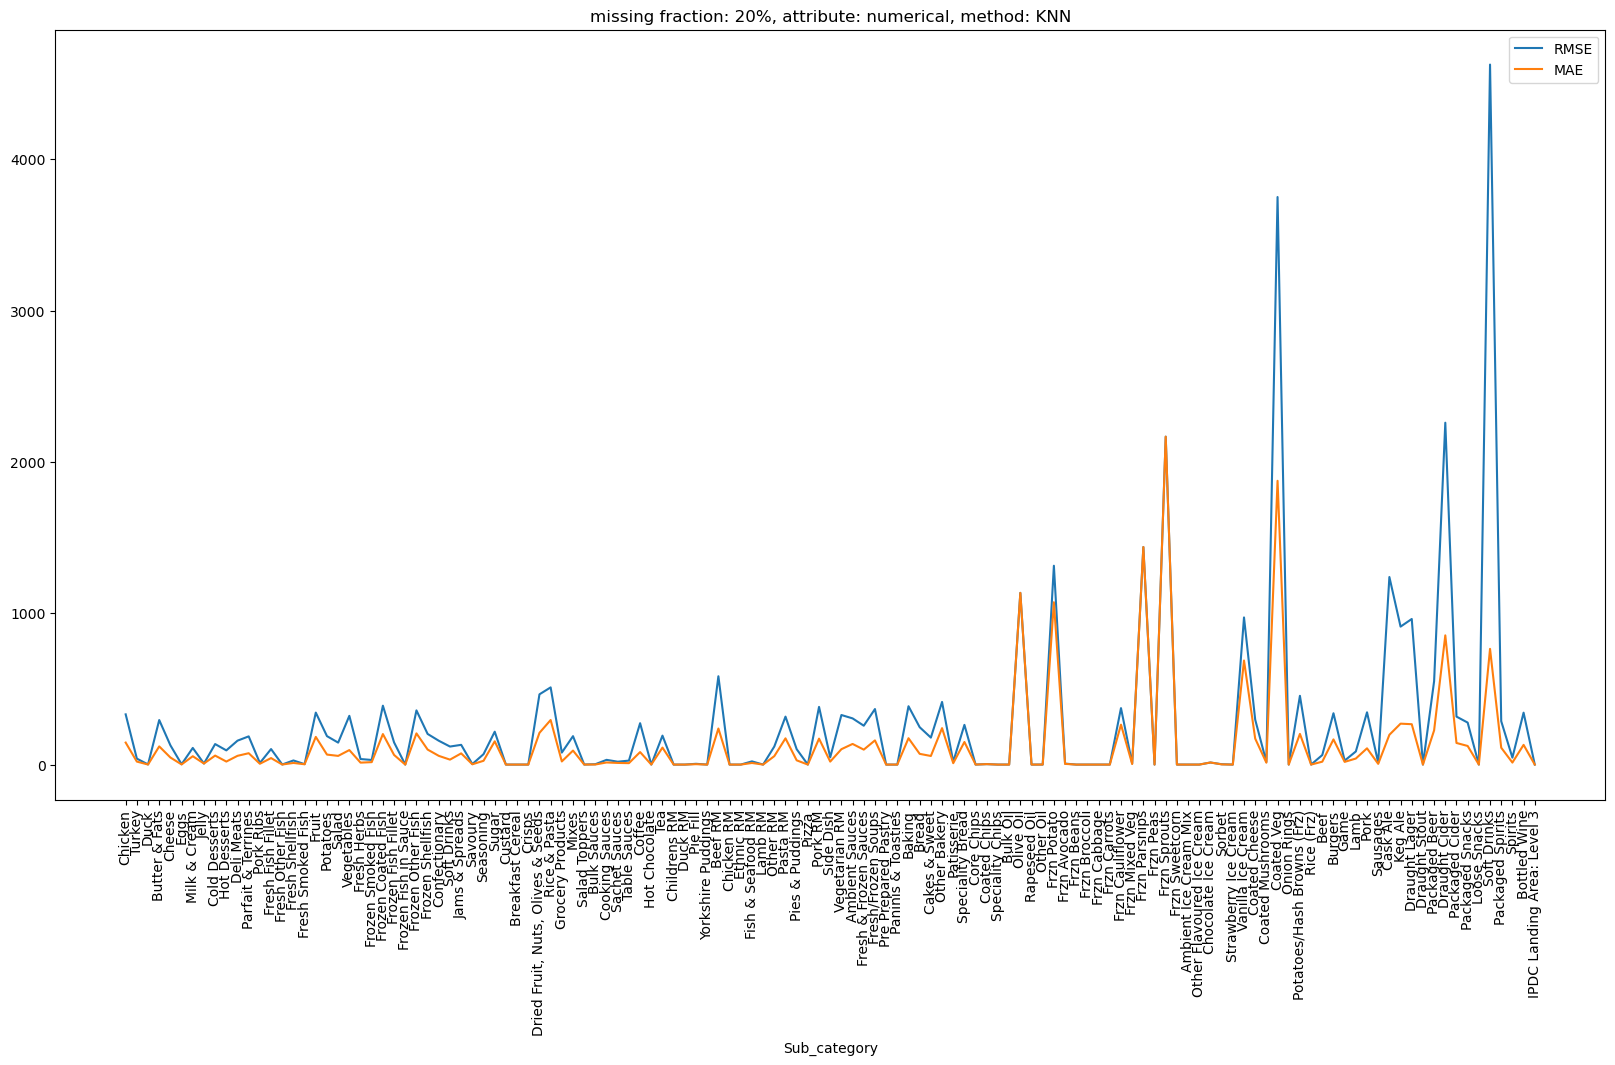

In [52]:
exp2_1_1.set_index('Sub_category')[['RMSE', 'MAE']].plot(figsize=(20,10), kind='line')
plt.xticks(range(len(exp2_1_1['Sub_category'])), exp2_1_1['Sub_category'], rotation=90, fontsize=10)
plt.xlabel('Sub_category')
plt.title('missing fraction: 20%, attribute: numerical, method: KNN')
plt.show()

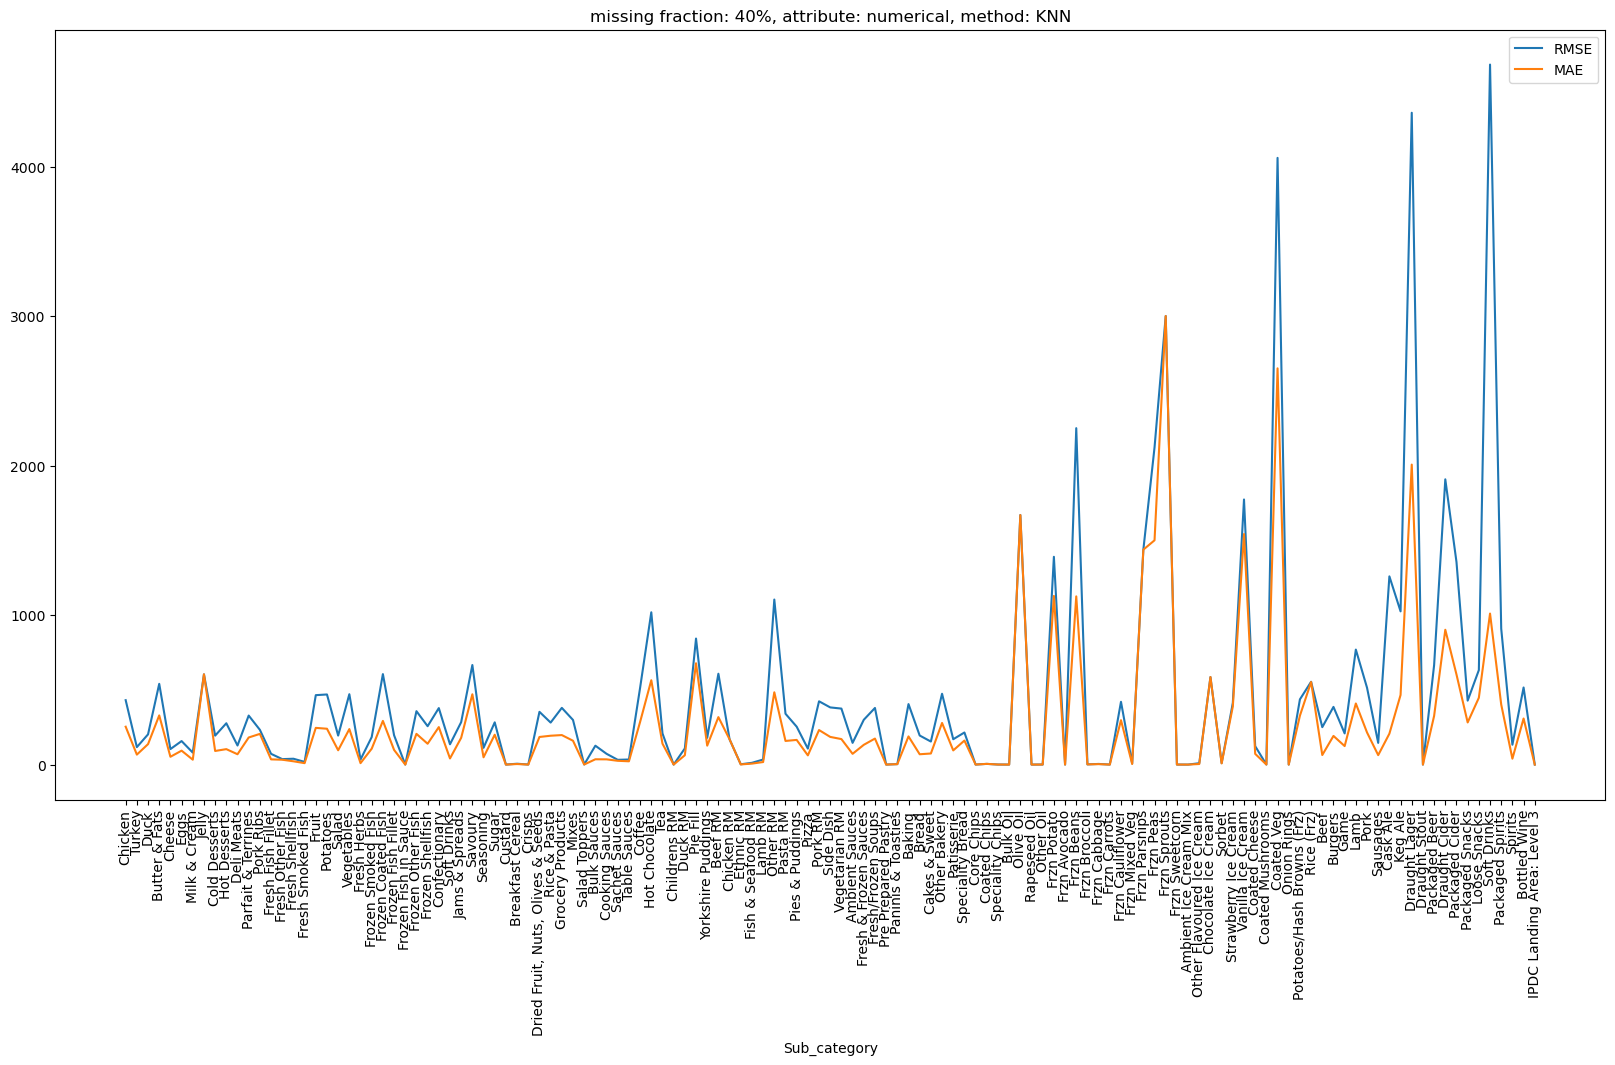

In [53]:
exp2_1_2.set_index('Sub_category')[['RMSE', 'MAE']].plot(figsize=(20,10), kind='line')
plt.xticks(range(len(exp2_1_2['Sub_category'])), exp2_1_2['Sub_category'], rotation=90, fontsize=10)
plt.xlabel('Sub_category')
plt.title('missing fraction: 40%, attribute: numerical, method: KNN')
plt.show()

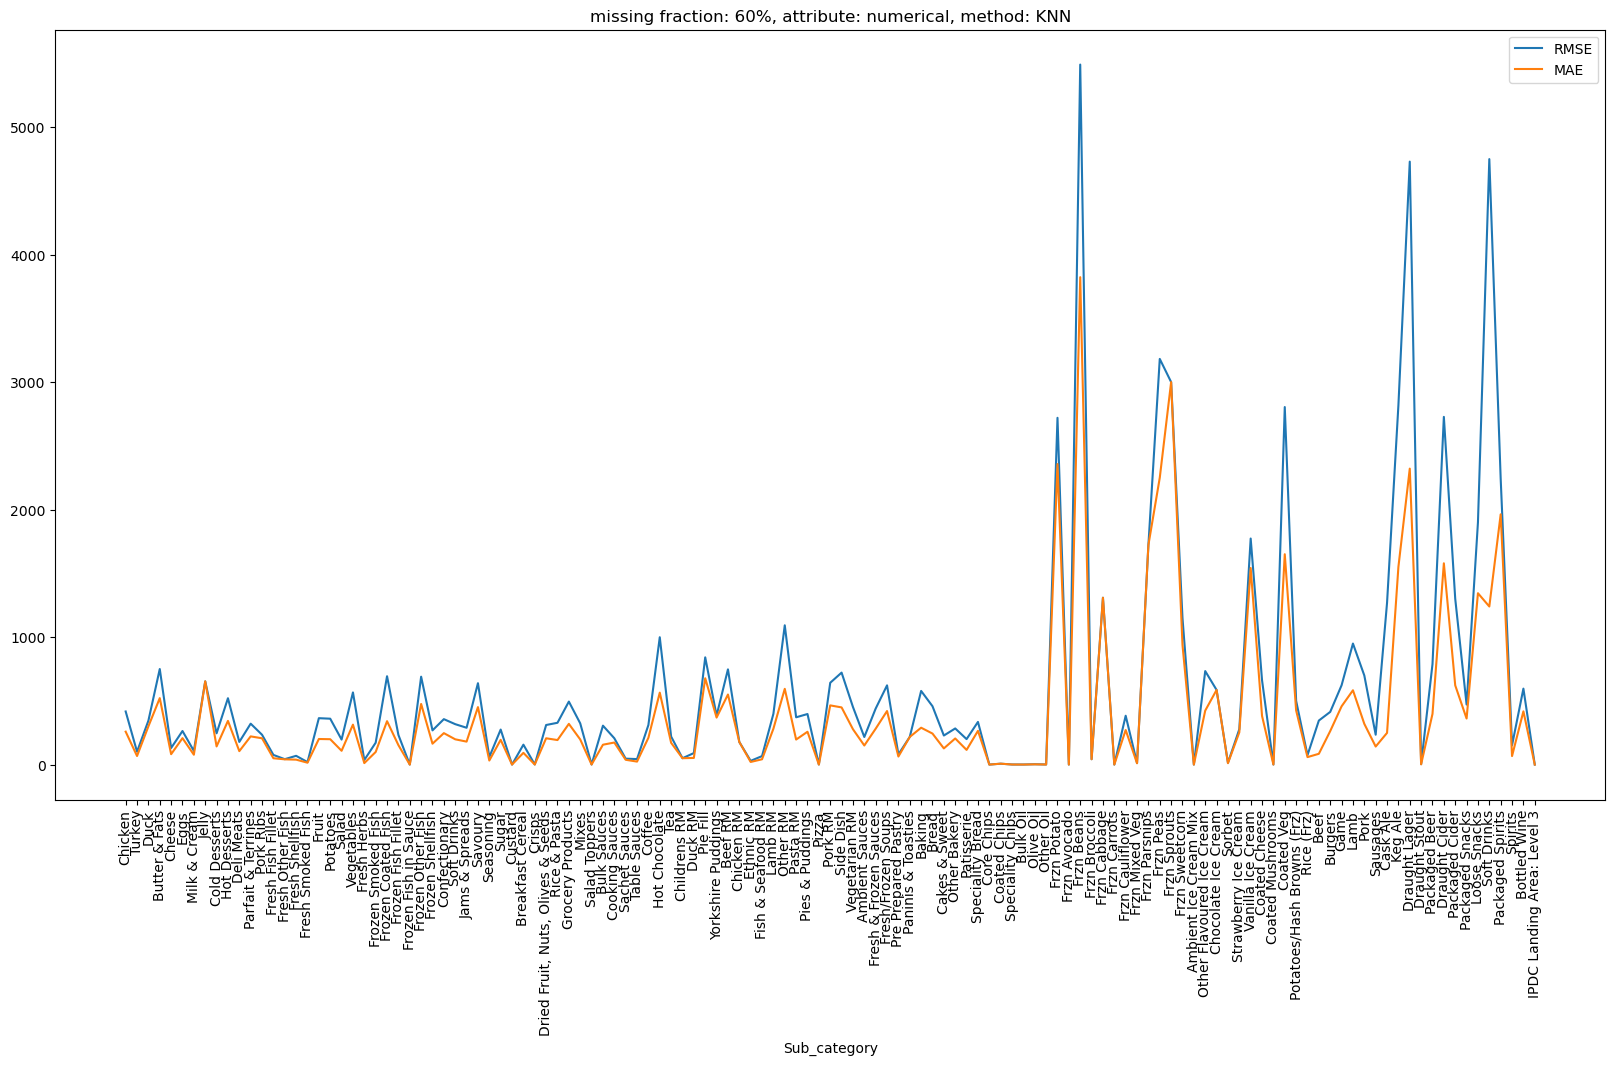

In [54]:
exp2_1_3.set_index('Sub_category')[['RMSE', 'MAE']].plot(figsize=(20,10), kind='line')
plt.xticks(range(len(exp2_1_3['Sub_category'])), exp2_1_3['Sub_category'], rotation=90, fontsize=10)
plt.xlabel('Sub_category')
plt.title('missing fraction: 60%, attribute: numerical, method: KNN')
plt.show()

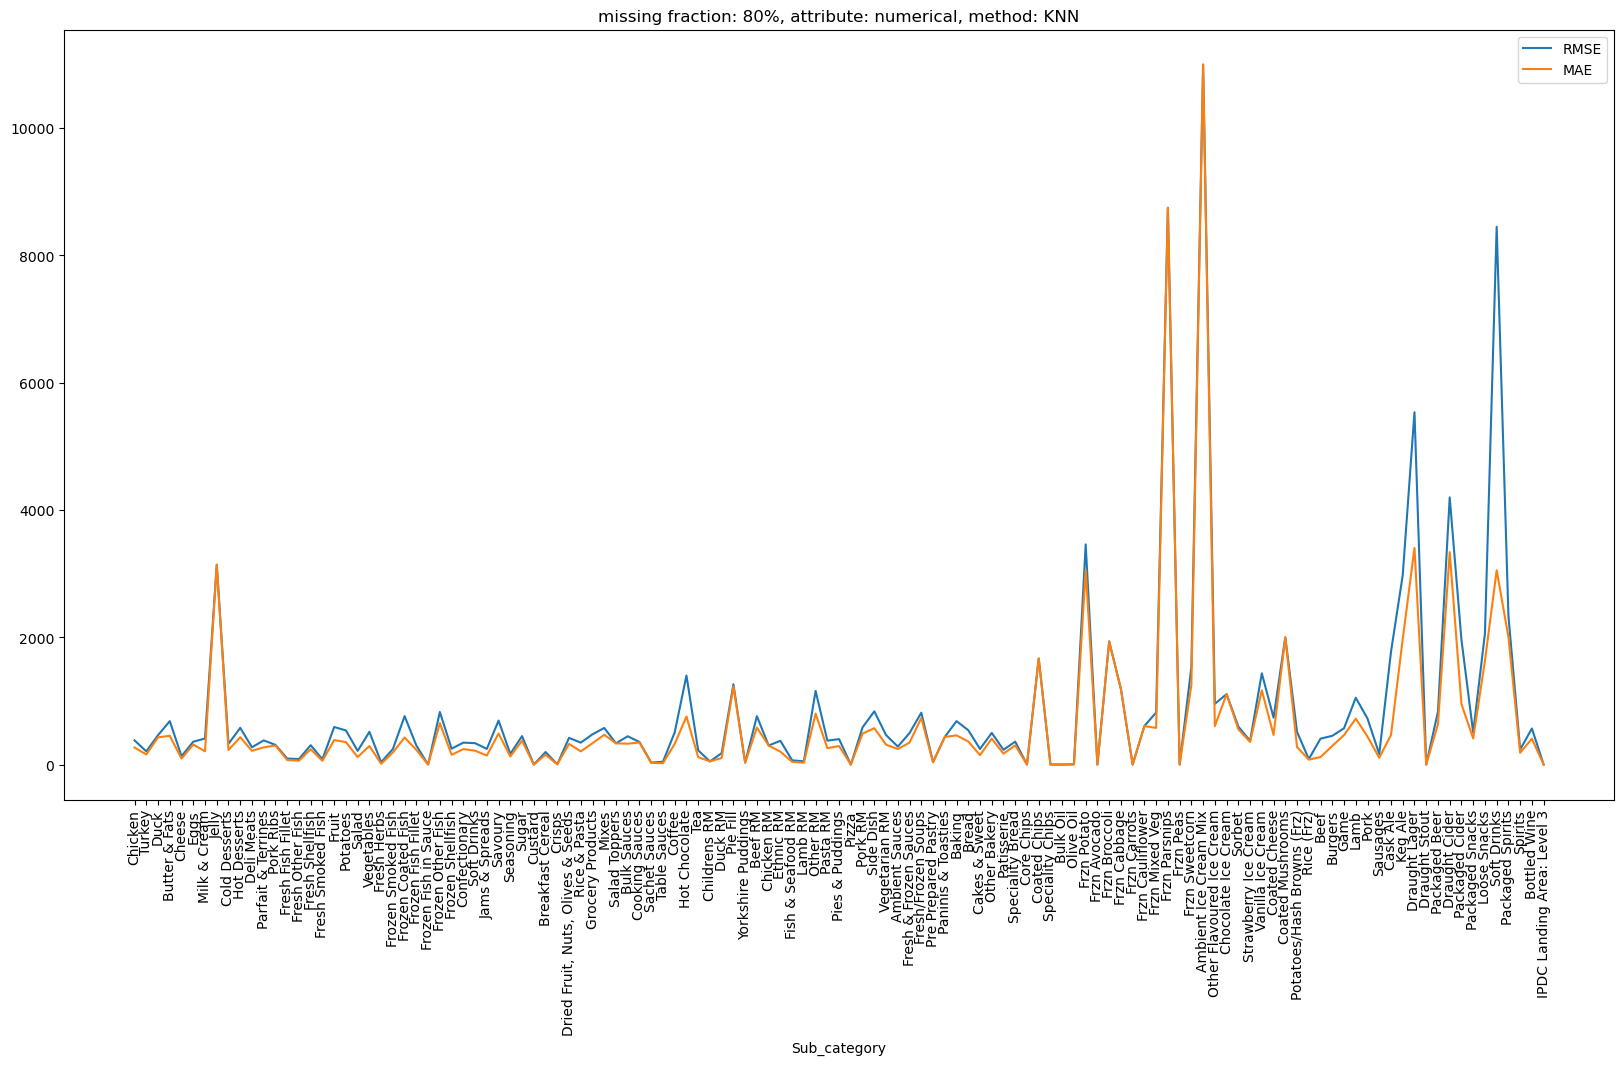

In [55]:
exp2_1_4.set_index('Sub_category')[['RMSE', 'MAE']].plot(figsize=(20,10), kind='line')
plt.xticks(range(len(exp2_1_4['Sub_category'])), exp2_1_4['Sub_category'], rotation=90, fontsize=10)
plt.xlabel('Sub_category')
plt.title('missing fraction: 80%, attribute: numerical, method: KNN')
plt.show()

In [56]:
#Experiment2_2_1: KNN imputation for categorical columns (20% mask)
sub_category = []
Accuracy = []
Precision = []
Recall = []
F1_score = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
        cat_var = list(set(cat_attrib) & set(clean_df.columns))
        if len(cat_var) > 0:
            mask_df = create_mask(clean_df, missing_prob=0.2, random_state=random_state)
            for i in cat_var:
                mask_df[i] = mask_df[i].astype(str)
                mask_df[i] = mask_df[i].replace('nan', np.nan)
            train_df, test_df = train_test_split(mask_df[cat_var], test_size=0.2, random_state=random_state)
            train_df.dropna(axis=1, how='all', inplace=True)
            update_test_df = test_df[train_df.columns]
            cat_var = list(set(cat_var) & set(train_df.columns))
            df_concat = pd.concat([train_df, update_test_df])
            cat_df = pd.DataFrame()
            for i in cat_var:
                cat_df = pd.concat([cat_df, encode_cat(df_concat[[i]])[3]], axis=1)
            cat_train = cat_df.loc[train_df.index]
            cat_test = cat_df.loc[test_df.index]
            knn_imputed_test = knn_impute_cat(df_concat, cat_train, cat_test, cat_var, n_neighbors=5)
            knn_imputed_metric = knn_impute_cat_performance(clean_df, knn_imputed_test, cat_var)
            if knn_imputed_metric is not None:
                sub_category.append(level3_name)
                knn_imputed_accuracy = knn_impute_cat_performance(clean_df, knn_imputed_test, cat_var)[0]
                Accuracy.append(knn_imputed_accuracy)
                knn_imputed_precision = knn_impute_cat_performance(clean_df, knn_imputed_test, cat_var)[1]
                Precision.append(knn_imputed_precision)
                knn_imputed_recall = knn_impute_cat_performance(clean_df, knn_imputed_test, cat_var)[2]
                Recall.append(knn_imputed_recall)
                knn_imputed_F1 = knn_impute_cat_performance(clean_df, knn_imputed_test, cat_var)[3]
                F1_score.append(knn_imputed_F1)
exp2_2_1 = pd.DataFrame({'Sub_category': sub_category, 'Accuracy': Accuracy, 'Precision': Precision, 'Recall': Recall, 'F1_score': F1_score})

In [57]:
#Experiment2_2_2: KNN imputation for categorical columns (40% mask)
sub_category = []
Accuracy = []
Precision = []
Recall = []
F1_score = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
        cat_var = list(set(cat_attrib) & set(clean_df.columns))
        if len(cat_var) > 0:
            mask_df = create_mask(clean_df, missing_prob=0.4, random_state=random_state)
            for i in cat_var:
                mask_df[i] = mask_df[i].astype(str)
                mask_df[i] = mask_df[i].replace('nan', np.nan)
            train_df, test_df = train_test_split(mask_df[cat_var], test_size=0.2, random_state=random_state)
            train_df.dropna(axis=1, how='all', inplace=True)
            update_test_df = test_df[train_df.columns]
            cat_var = list(set(cat_var) & set(train_df.columns))
            df_concat = pd.concat([train_df, update_test_df])
            cat_df = pd.DataFrame()
            for i in cat_var:
                cat_df = pd.concat([cat_df, encode_cat(df_concat[[i]])[3]], axis=1)
            cat_train = cat_df.loc[train_df.index]
            cat_test = cat_df.loc[test_df.index]
            knn_imputed_test = knn_impute_cat(df_concat, cat_train, cat_test, cat_var, n_neighbors=5)
            knn_imputed_metric = knn_impute_cat_performance(clean_df, knn_imputed_test, cat_var)
            if knn_imputed_metric is not None:
                sub_category.append(level3_name)
                knn_imputed_accuracy = knn_impute_cat_performance(clean_df, knn_imputed_test, cat_var)[0]
                Accuracy.append(knn_imputed_accuracy)
                knn_imputed_precision = knn_impute_cat_performance(clean_df, knn_imputed_test, cat_var)[1]
                Precision.append(knn_imputed_precision)
                knn_imputed_recall = knn_impute_cat_performance(clean_df, knn_imputed_test, cat_var)[2]
                Recall.append(knn_imputed_recall)
                knn_imputed_F1 = knn_impute_cat_performance(clean_df, knn_imputed_test, cat_var)[3]
                F1_score.append(knn_imputed_F1)
exp2_2_2 = pd.DataFrame({'Sub_category': sub_category, 'Accuracy': Accuracy, 'Precision': Precision, 'Recall': Recall, 'F1_score': F1_score})

In [58]:
#Experiment2_2_3: KNN imputation for categorical columns (60% mask)
sub_category = []
Accuracy = []
Precision = []
Recall = []
F1_score = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
        cat_var = list(set(cat_attrib) & set(clean_df.columns))
        if len(cat_var) > 0:
            mask_df = create_mask(clean_df, missing_prob=0.6, random_state=random_state)
            for i in cat_var:
                mask_df[i] = mask_df[i].astype(str)
                mask_df[i] = mask_df[i].replace('nan', np.nan)
            train_df, test_df = train_test_split(mask_df[cat_var], test_size=0.2, random_state=random_state)
            train_df.dropna(axis=1, how='all', inplace=True)
            update_test_df = test_df[train_df.columns]
            cat_var = list(set(cat_var) & set(train_df.columns))
            df_concat = pd.concat([train_df, update_test_df])
            cat_df = pd.DataFrame()
            for i in cat_var:
                cat_df = pd.concat([cat_df, encode_cat(df_concat[[i]])[3]], axis=1)
            if not cat_df.empty:
                cat_train = cat_df.loc[train_df.index]
                cat_test = cat_df.loc[update_test_df.index]
                knn_imputed_test = knn_impute_cat(df_concat, cat_train, cat_test, cat_var, n_neighbors=5)
                knn_imputed_metric = knn_impute_cat_performance(clean_df, knn_imputed_test, cat_var)
                if knn_imputed_metric is not None:
                    sub_category.append(level3_name)
                    knn_imputed_accuracy = knn_impute_cat_performance(clean_df, knn_imputed_test, cat_var)[0]
                    Accuracy.append(knn_imputed_accuracy)
                    knn_imputed_precision = knn_impute_cat_performance(clean_df, knn_imputed_test, cat_var)[1]
                    Precision.append(knn_imputed_precision)
                    knn_imputed_recall = knn_impute_cat_performance(clean_df, knn_imputed_test, cat_var)[2]
                    Recall.append(knn_imputed_recall)
                    knn_imputed_F1 = knn_impute_cat_performance(clean_df, knn_imputed_test, cat_var)[3]
                    F1_score.append(knn_imputed_F1)
exp2_2_3 = pd.DataFrame({'Sub_category': sub_category, 'Accuracy': Accuracy, 'Precision': Precision, 'Recall': Recall, 'F1_score': F1_score})

In [59]:
#Experiment2_2_4: KNN imputation for categorical columns (80% mask)
sub_category = []
Accuracy = []
Precision = []
Recall = []
F1_score = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
        cat_var = list(set(cat_attrib) & set(clean_df.columns))
        if len(cat_var) > 0:
            mask_df = create_mask(clean_df, missing_prob=0.8, random_state=random_state)
            for i in cat_var:
                mask_df[i] = mask_df[i].astype(str)
                mask_df[i] = mask_df[i].replace('nan', np.nan)
            train_df, test_df = train_test_split(mask_df[cat_var], test_size=0.2, random_state=random_state)
            train_df.dropna(axis=1, how='all', inplace=True)
            update_test_df = test_df[train_df.columns]
            cat_var = list(set(cat_var) & set(train_df.columns))
            df_concat = pd.concat([train_df, update_test_df])
            cat_df = pd.DataFrame()
            for i in cat_var:
                cat_df = pd.concat([cat_df, encode_cat(df_concat[[i]])[3]], axis=1)
            if not cat_df.empty:
                cat_train = cat_df.loc[train_df.index]
                cat_test = cat_df.loc[test_df.index]
                knn_imputed_test = knn_impute_cat(df_concat, cat_train, cat_test, cat_var, n_neighbors=5)
                knn_imputed_metric = knn_impute_cat_performance(clean_df, knn_imputed_test, cat_var)
                if knn_imputed_metric is not None:
                    sub_category.append(level3_name)
                    knn_imputed_accuracy = knn_impute_cat_performance(clean_df, knn_imputed_test, cat_var)[0]
                    Accuracy.append(knn_imputed_accuracy)
                    knn_imputed_precision = knn_impute_cat_performance(clean_df, knn_imputed_test, cat_var)[1]
                    Precision.append(knn_imputed_precision)
                    knn_imputed_recall = knn_impute_cat_performance(clean_df, knn_imputed_test, cat_var)[2]
                    Recall.append(knn_imputed_recall)
                    knn_imputed_F1 = knn_impute_cat_performance(clean_df, knn_imputed_test, cat_var)[3]
                    F1_score.append(knn_imputed_F1)
exp2_2_4 = pd.DataFrame({'Sub_category': sub_category, 'Accuracy': Accuracy, 'Precision': Precision, 'Recall': Recall, 'F1_score': F1_score})

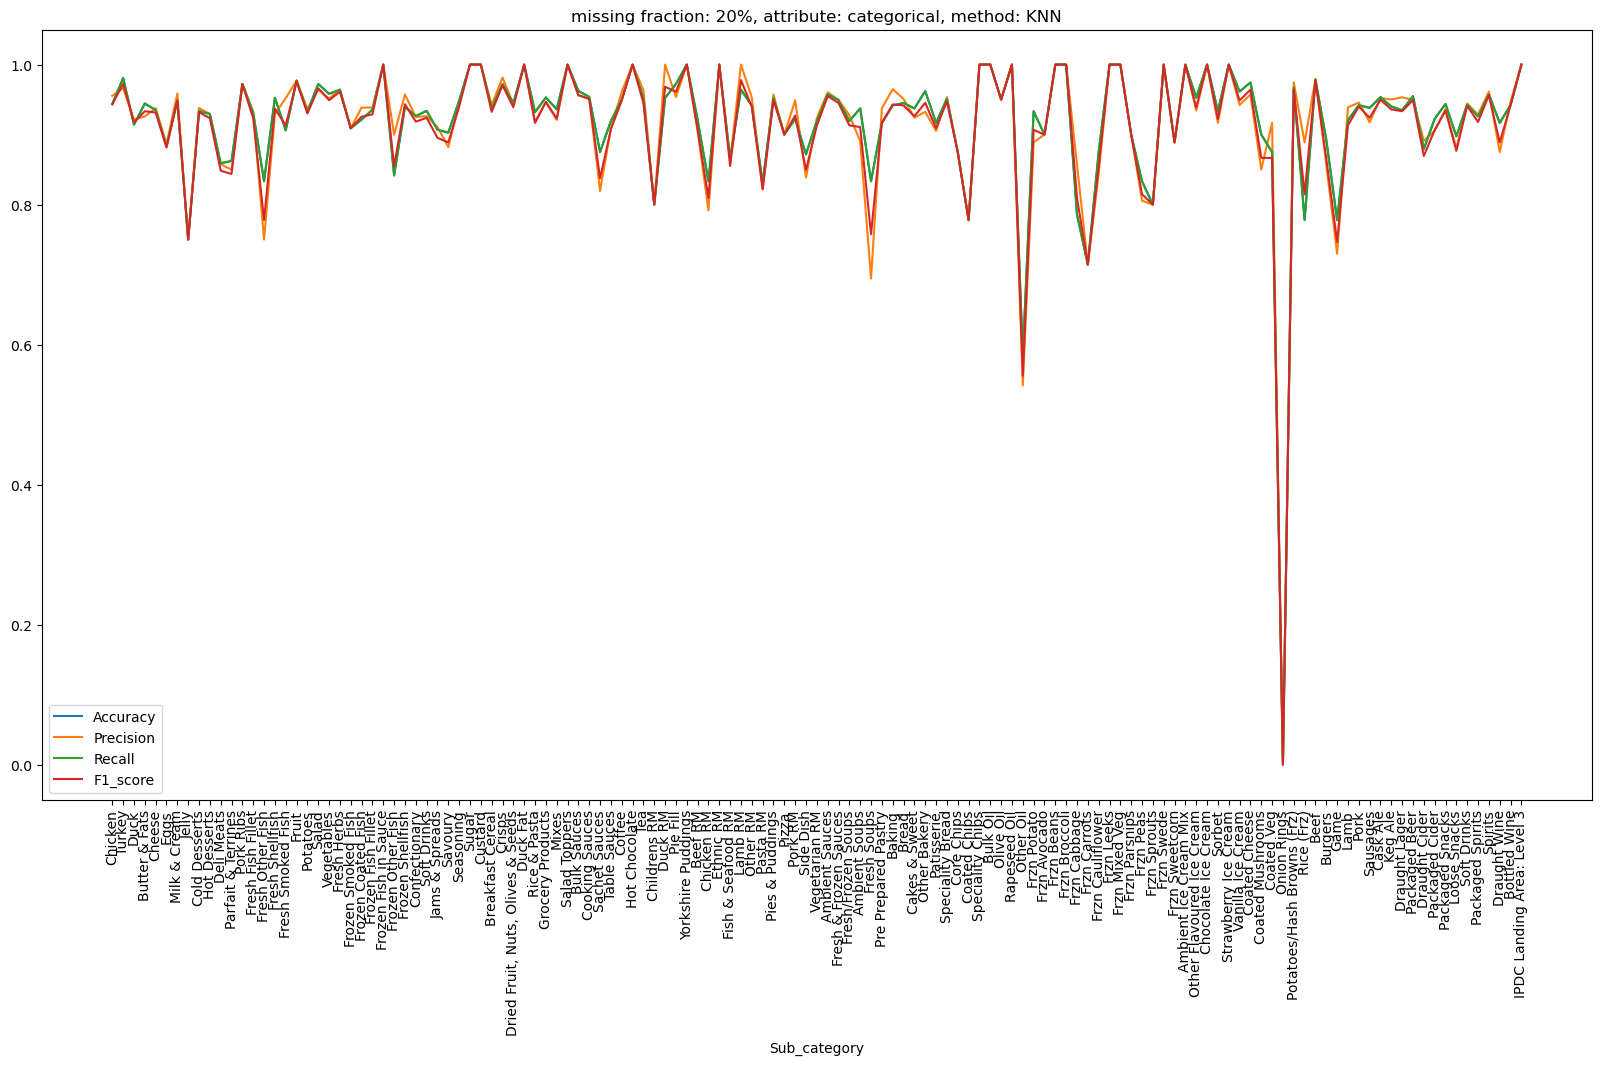

In [60]:
exp2_2_1.set_index('Sub_category')[['Accuracy', 'Precision', 'Recall', 'F1_score']].plot(figsize=(20,10), kind='line')
plt.xticks(range(len(exp2_2_1['Sub_category'])), exp2_2_1['Sub_category'], rotation=90, fontsize=10)
plt.xlabel('Sub_category')
plt.title('missing fraction: 20%, attribute: categorical, method: KNN')
plt.show()

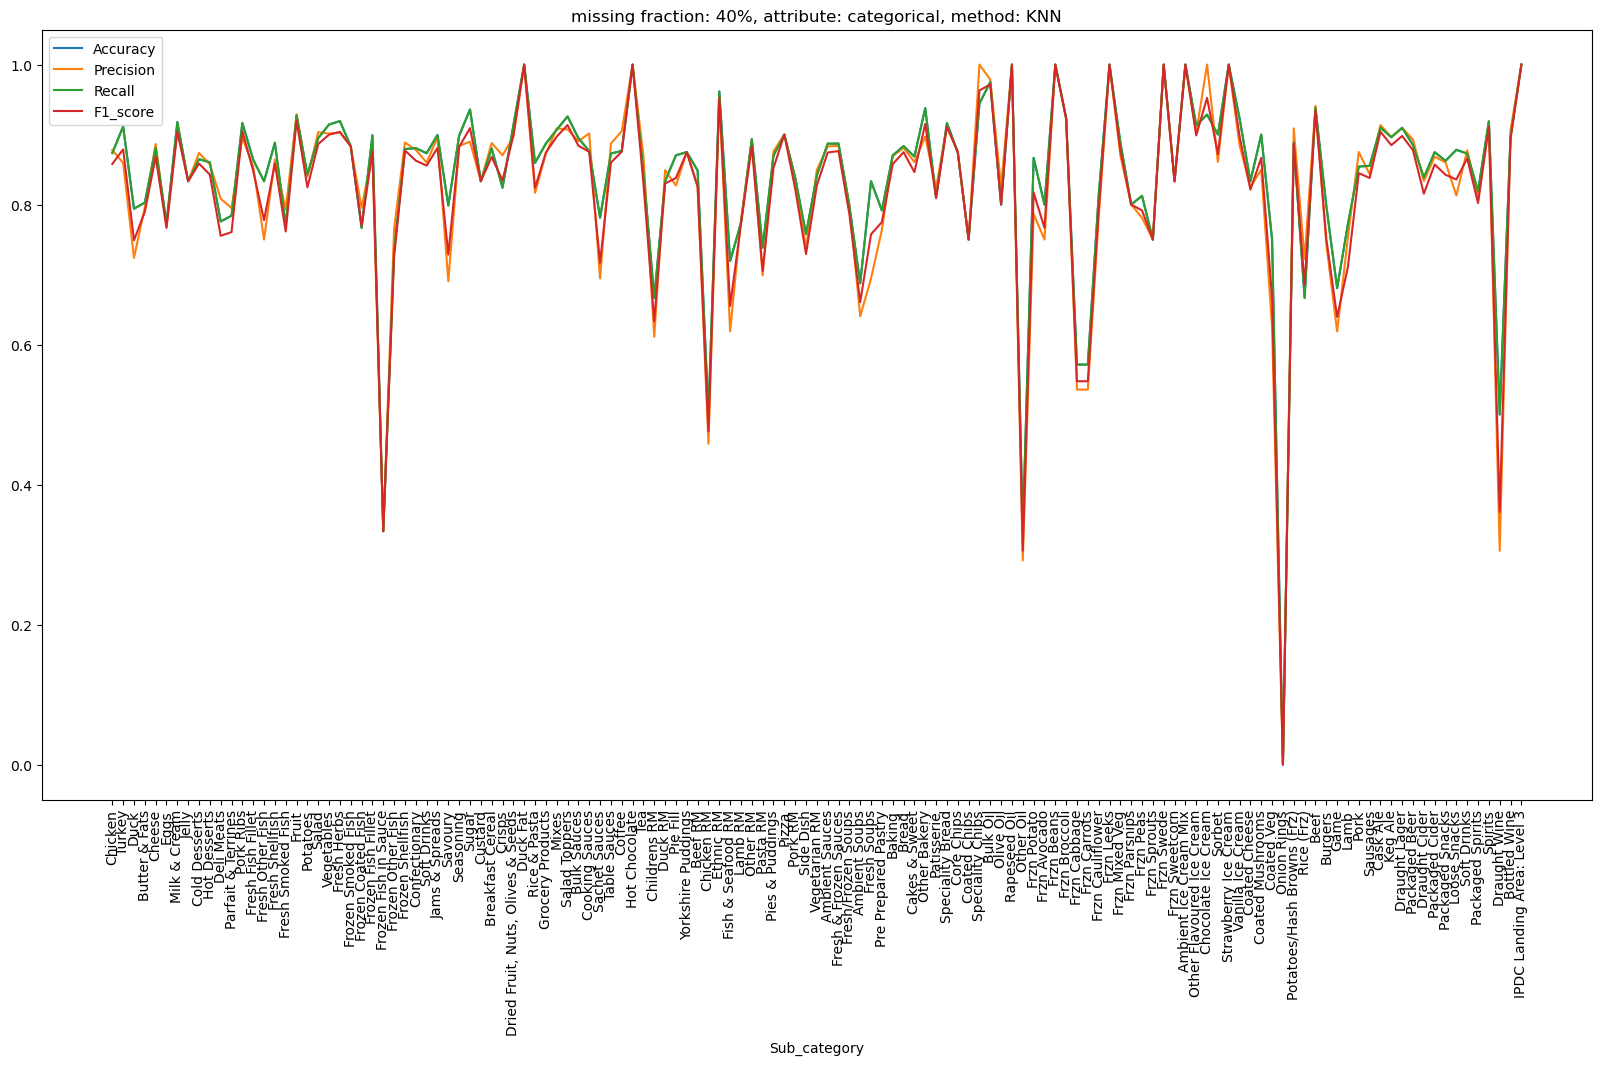

In [61]:
exp2_2_2.set_index('Sub_category')[['Accuracy', 'Precision', 'Recall', 'F1_score']].plot(figsize=(20,10), kind='line')
plt.xticks(range(len(exp2_2_2['Sub_category'])), exp2_2_2['Sub_category'], rotation=90, fontsize=10)
plt.xlabel('Sub_category')
plt.title('missing fraction: 40%, attribute: categorical, method: KNN')
plt.show()

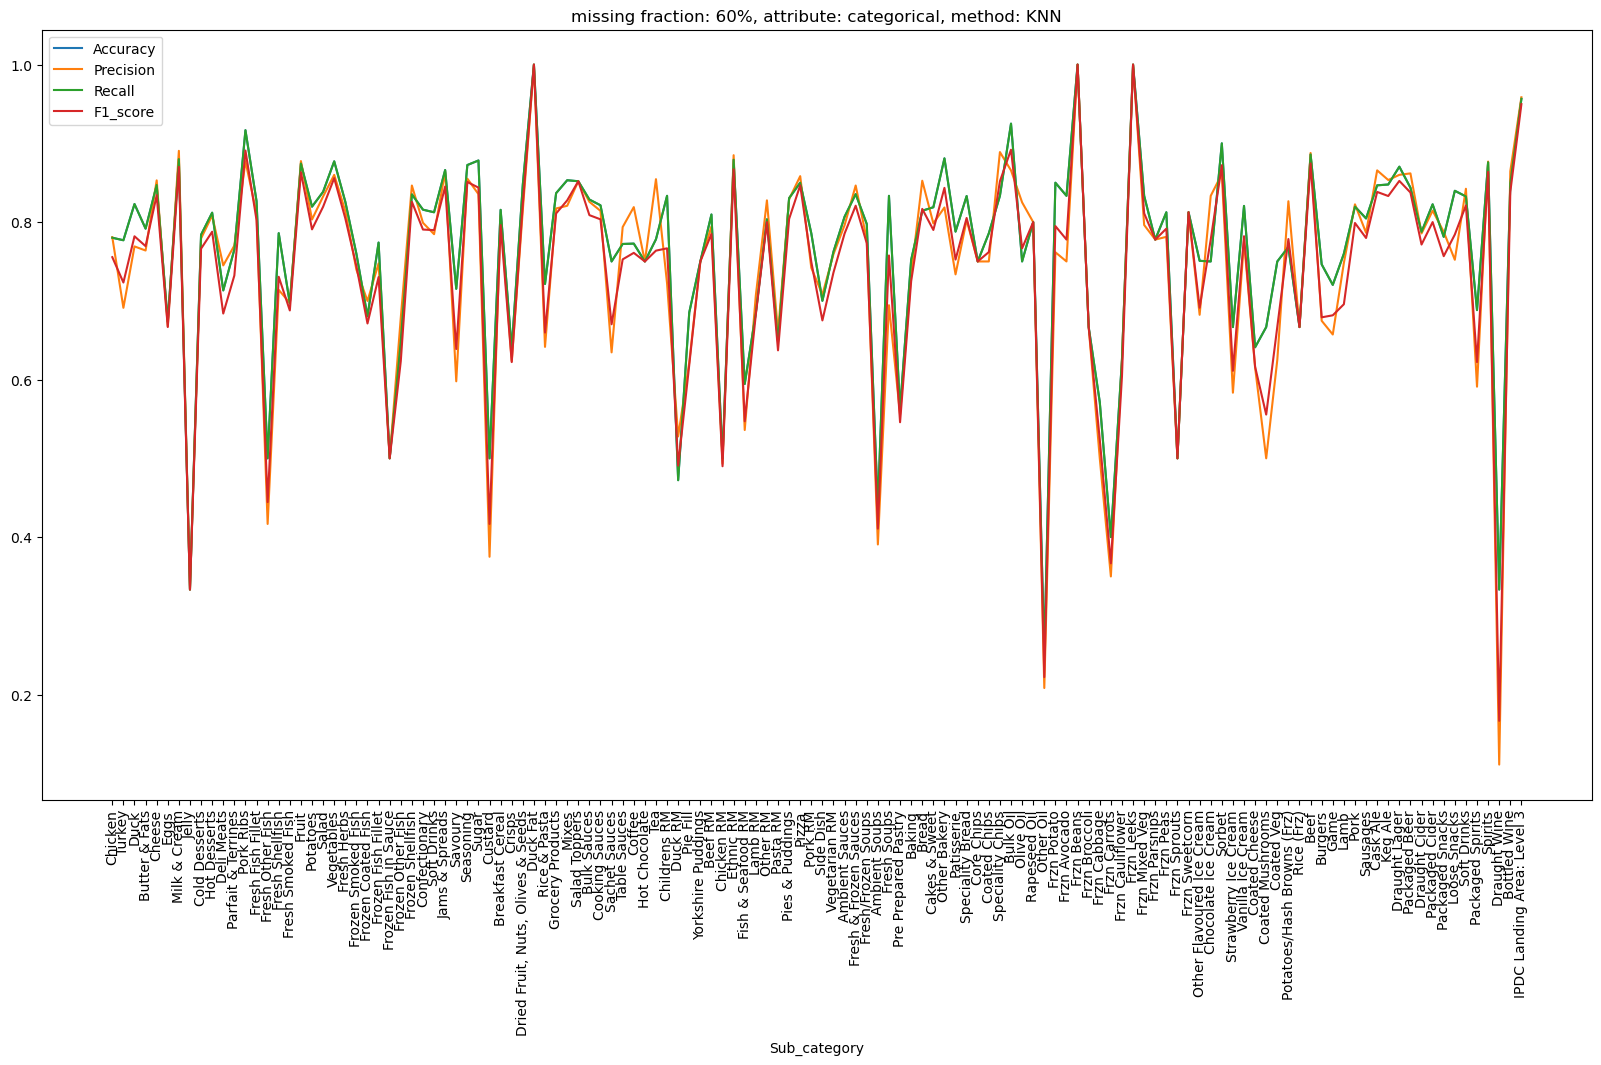

In [62]:
exp2_2_3.set_index('Sub_category')[['Accuracy', 'Precision', 'Recall', 'F1_score']].plot(figsize=(20,10), kind='line')
plt.xticks(range(len(exp2_2_3['Sub_category'])), exp2_2_3['Sub_category'], rotation=90, fontsize=10)
plt.xlabel('Sub_category')
plt.title('missing fraction: 60%, attribute: categorical, method: KNN')
plt.show()

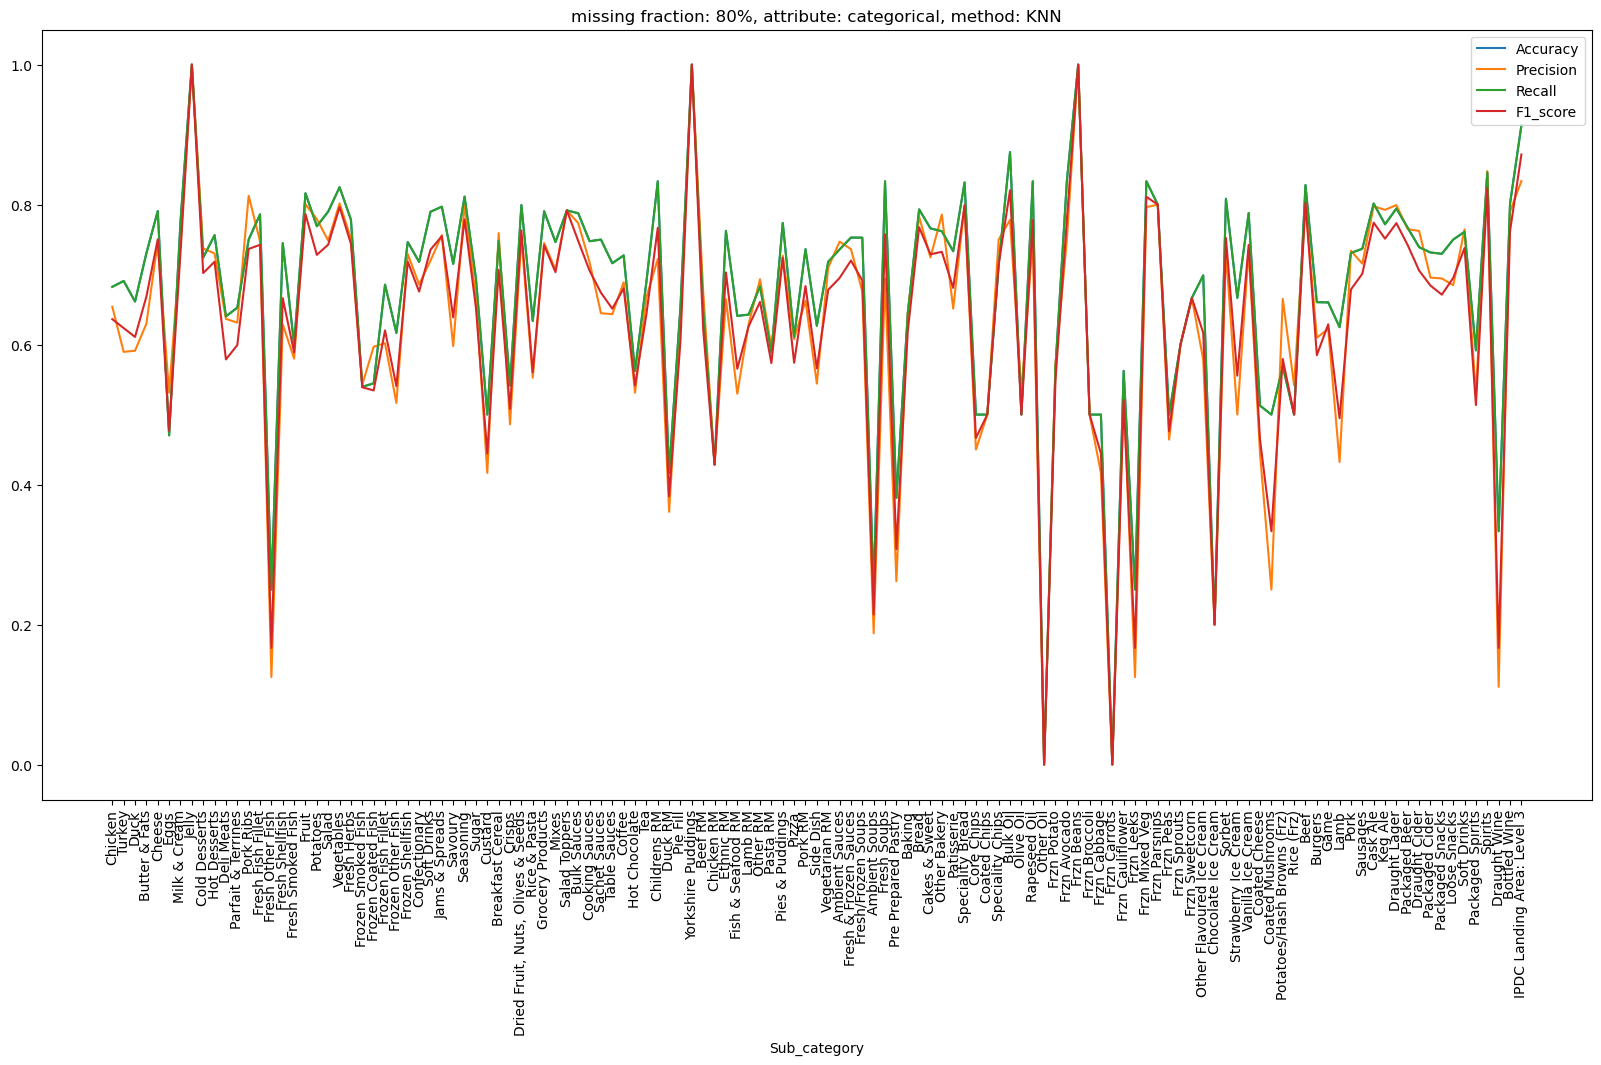

In [63]:
exp2_2_4.set_index('Sub_category')[['Accuracy', 'Precision', 'Recall', 'F1_score']].plot(figsize=(20,10), kind='line')
plt.xticks(range(len(exp2_2_4['Sub_category'])), exp2_2_4['Sub_category'], rotation=90, fontsize=10)
plt.xlabel('Sub_category')
plt.title('missing fraction: 80%, attribute: categorical, method: KNN')
plt.show()

In [64]:
buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'][['<ID>', '<Name>']]

<ID>                      <Name>
3        BS_Level3.6513                     Chicken
287      BS_Level3.6523                      Turkey
350      BS_Level3.6525                        Duck
400      BS_Level3.6575               Butter & Fats
480      BS_Level3.6580                      Cheese
...                 ...                         ...
21684    BS_Level3.6954                Bottled Wine
23311  BS_Level3.109092          Wet Dummy Level: 3
23316  BS_Level3.257289    New Dummy Ingredient Dry
23335  BS_Level3.257290    New Dummy Ingredient Wet
23344  BS_Level3.743438  IPDC Landing Area: Level 3

[147 rows x 2 columns]

In [65]:
df_chick = get_leaf3(buy_side, 'BS_Level3.6513')
cat_var = list(set(cat_attrib) & set(df_chick.columns))
num_var = list(set(num_attrib) & set(df_chick.columns))
len(cat_var), len(num_var)

(45, 53)

In [66]:
clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 30))
cat_var = list(set(cat_attrib) & set(clean_df.columns))
num_var = list(set(num_attrib) & set(clean_df.columns))
len(cat_var), len(num_var)

(36, 29)

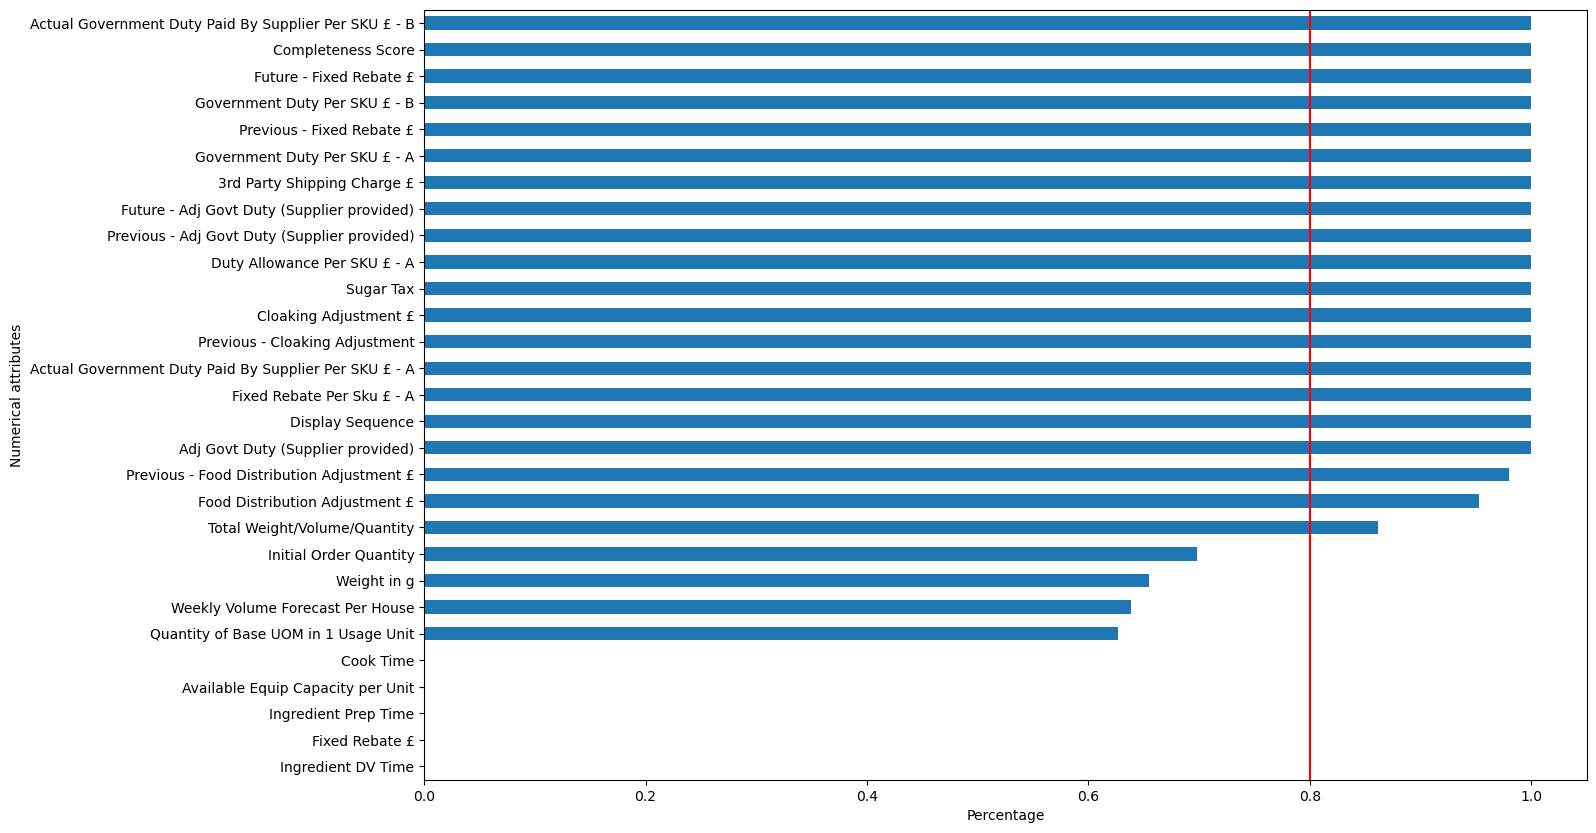

9

In [67]:
exp_df = pd.DataFrame(df_chick[num_var].isnull().sum() / len(df_chick[num_var]))
exp_df = exp_df.sort_values(0, ascending=True)
df_filtered = exp_df[exp_df[0] < 0.8]

ax = exp_df.plot.barh(legend=False, figsize=(15, 10))
ax.tick_params(labelsize=10)
ax.set_xlabel('Percentage', fontsize=10)
ax.set_ylabel('Numerical attributes', fontsize=10)
ax.axvline(x=0.8, color='red')
plt.show()

len(df_filtered)

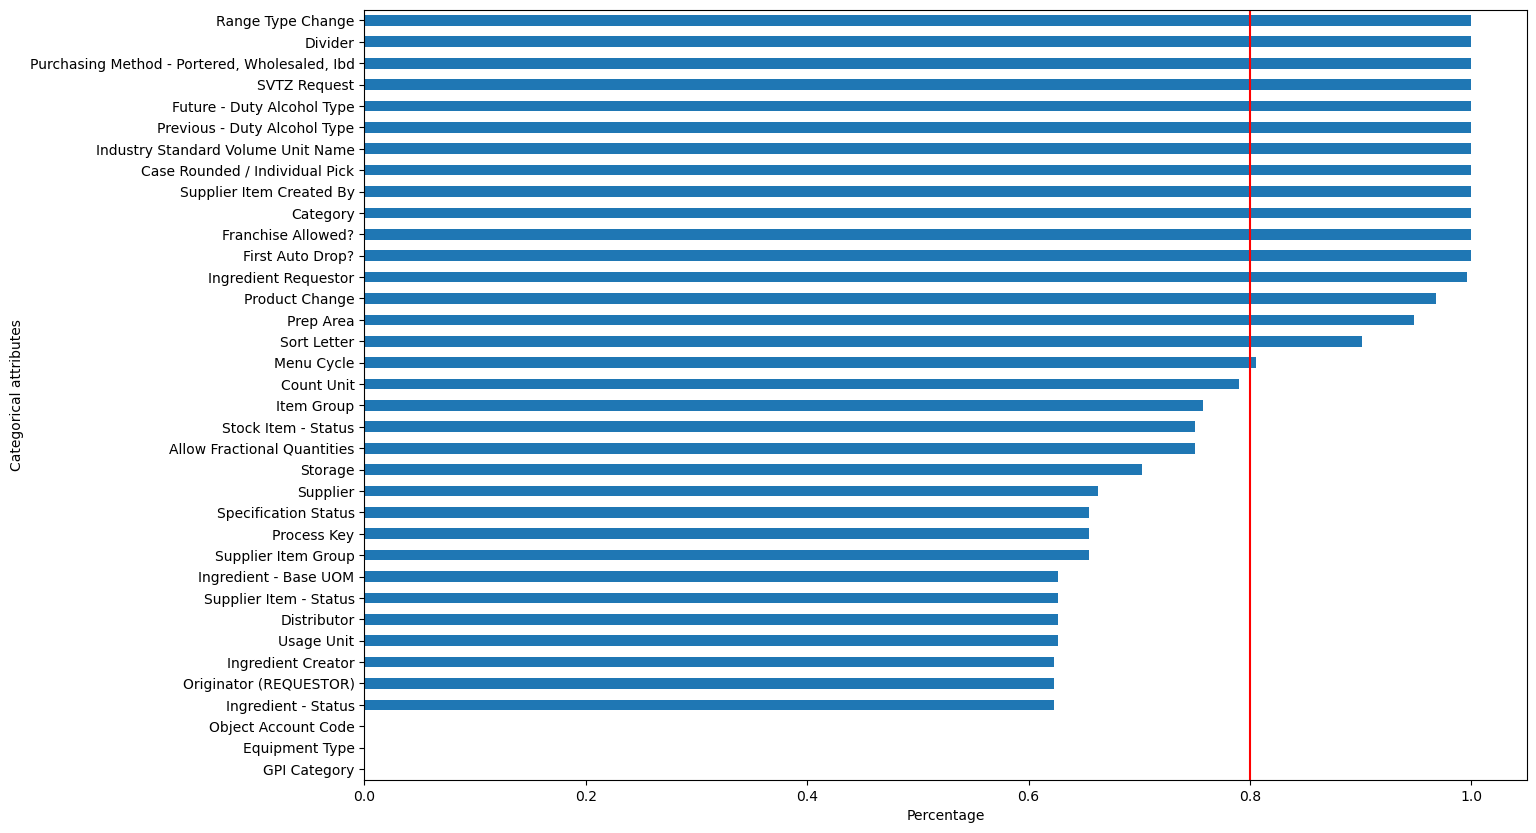

19

In [68]:
exp_df = pd.DataFrame(df_chick[cat_var].isnull().sum() / len(df_chick[cat_var]))
exp_df = exp_df.sort_values(0, ascending=True)
df_filtered = exp_df[exp_df[0] < 0.8]

ax = exp_df.plot.barh(legend=False, figsize=(15, 10))
ax.tick_params(labelsize=10)
ax.set_xlabel('Percentage', fontsize=10)
ax.set_ylabel('Categorical attributes', fontsize=10)
ax.axvline(x=0.8, color='red')
plt.show()

len(df_filtered)

<AxesSubplot:>

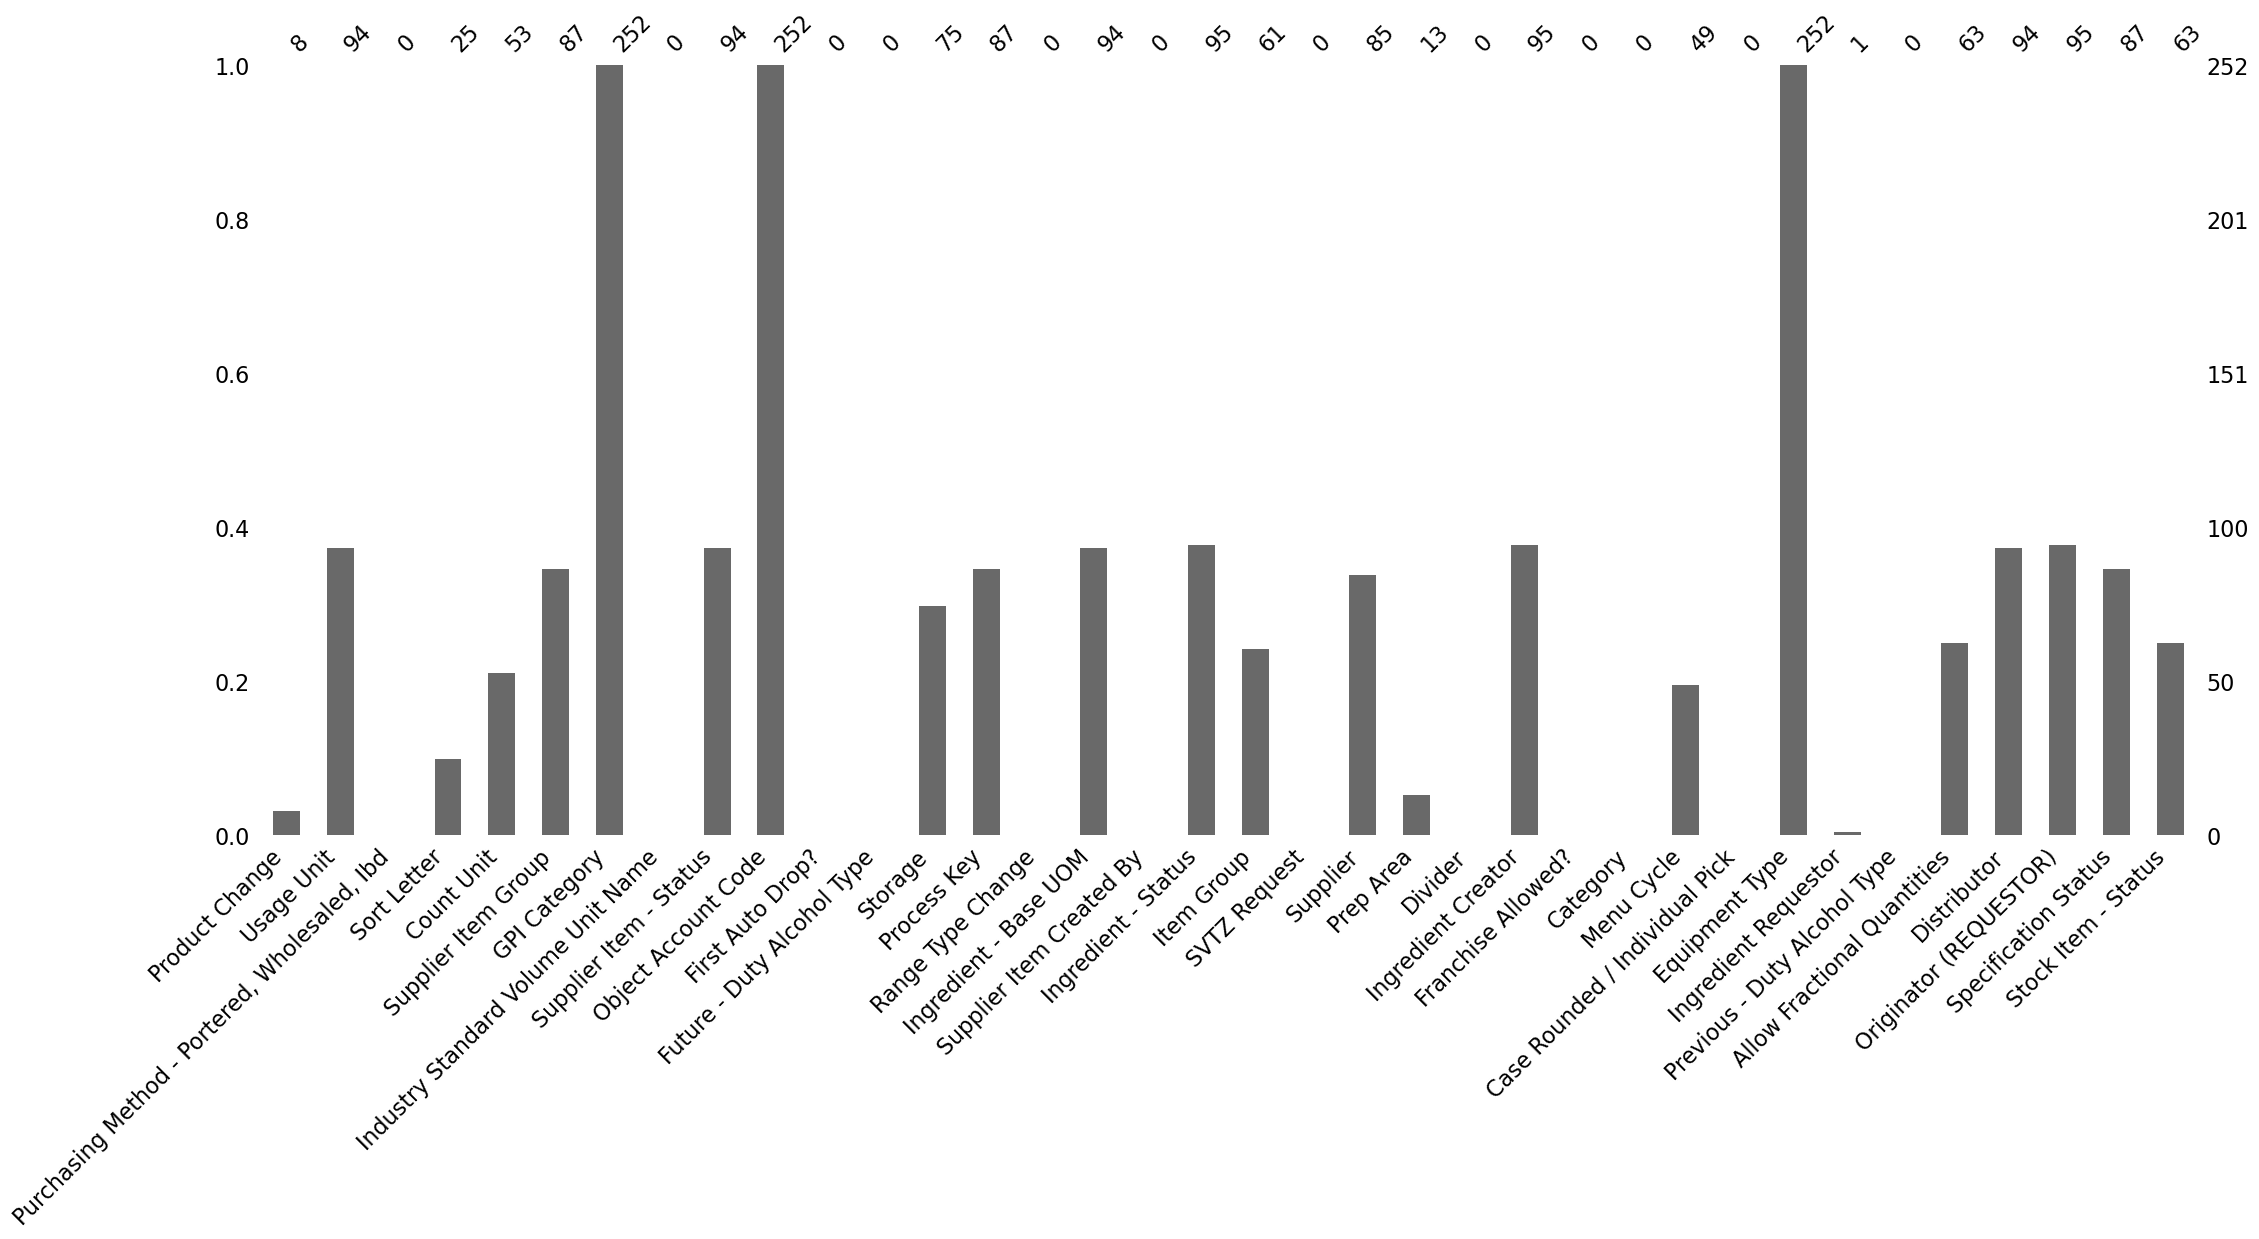

In [69]:
msno.bar(df_chick[cat_var])

<AxesSubplot:>

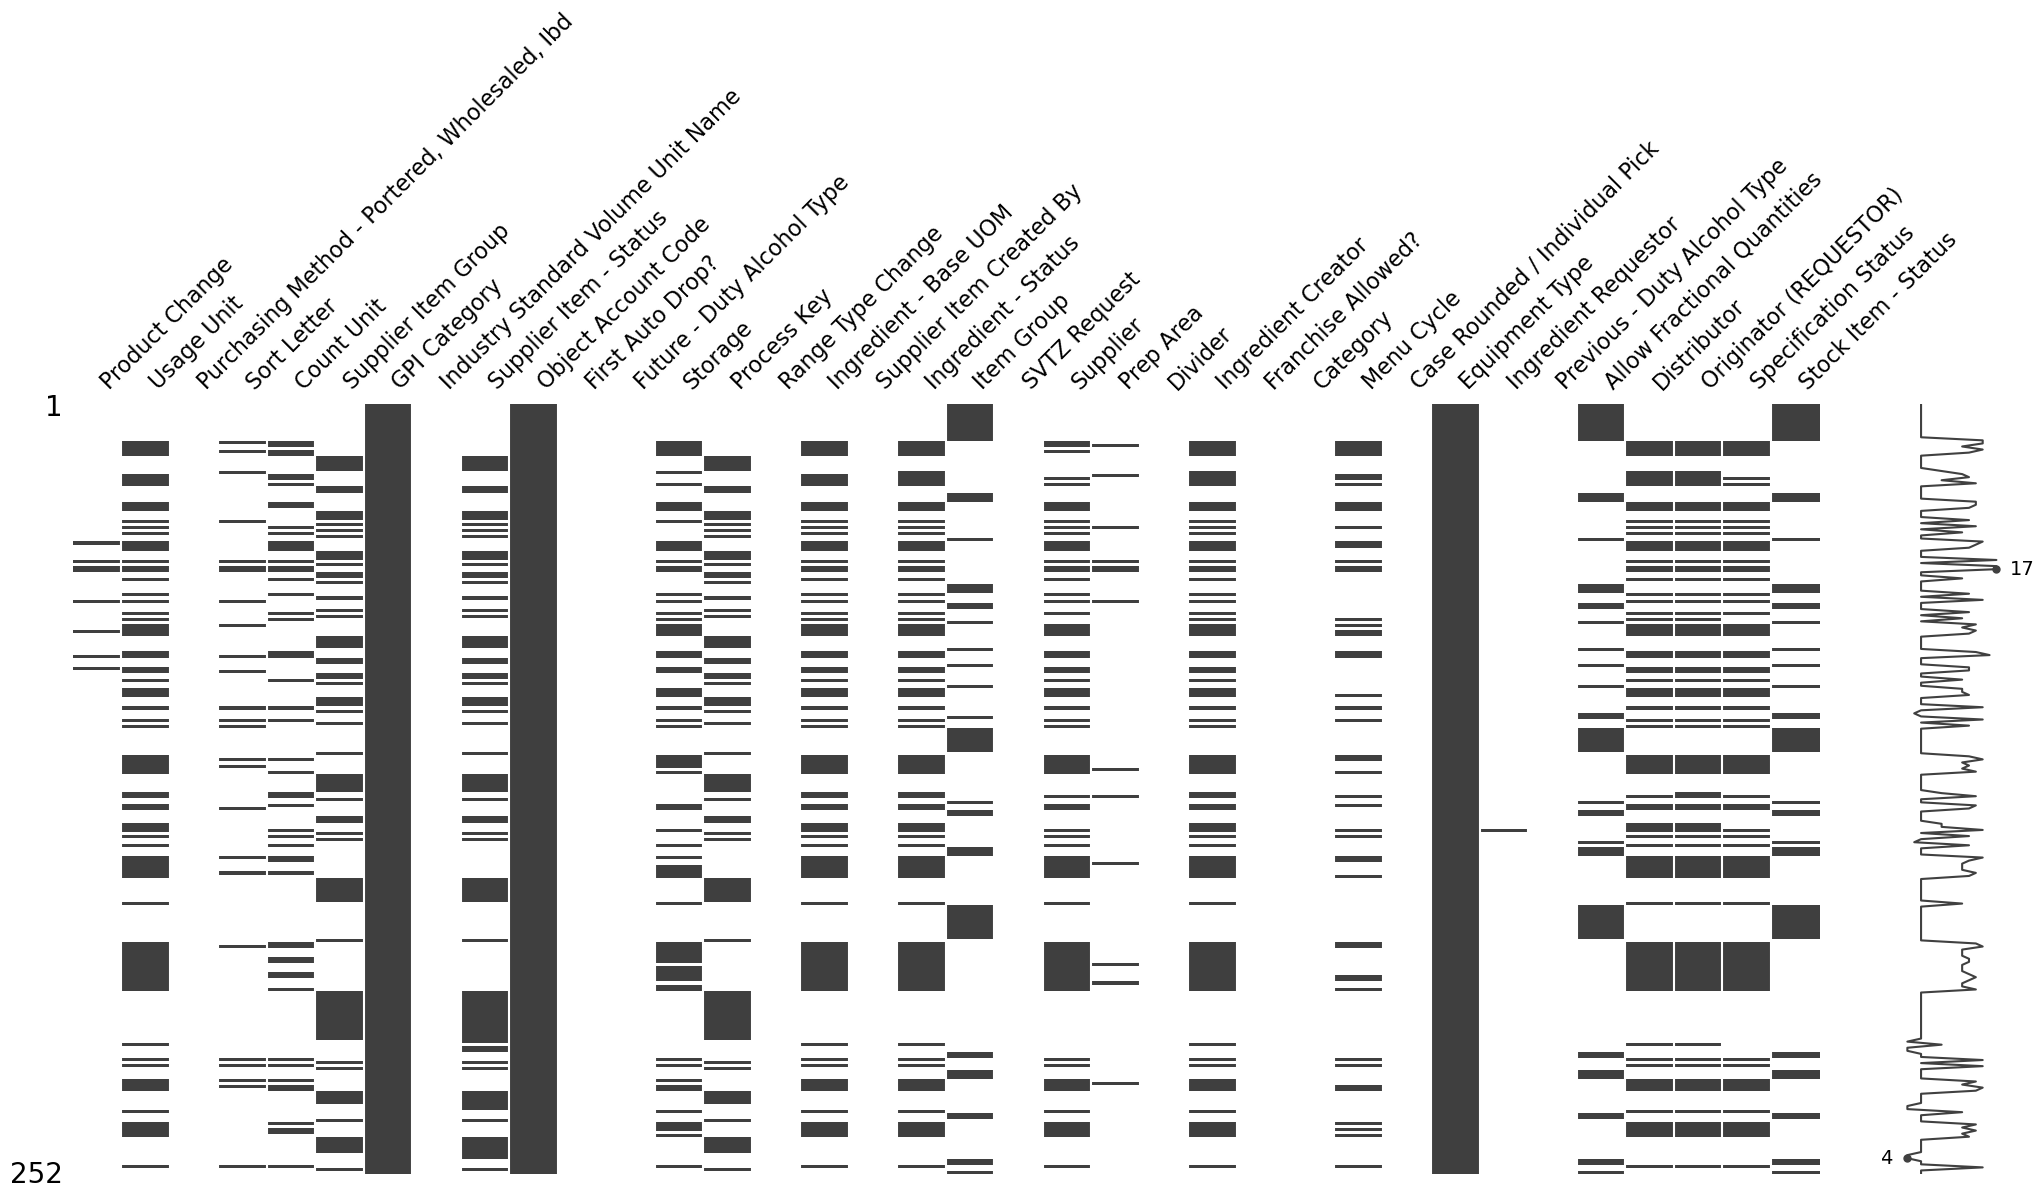

In [70]:
msno.matrix(df_chick[cat_var])

<AxesSubplot:>

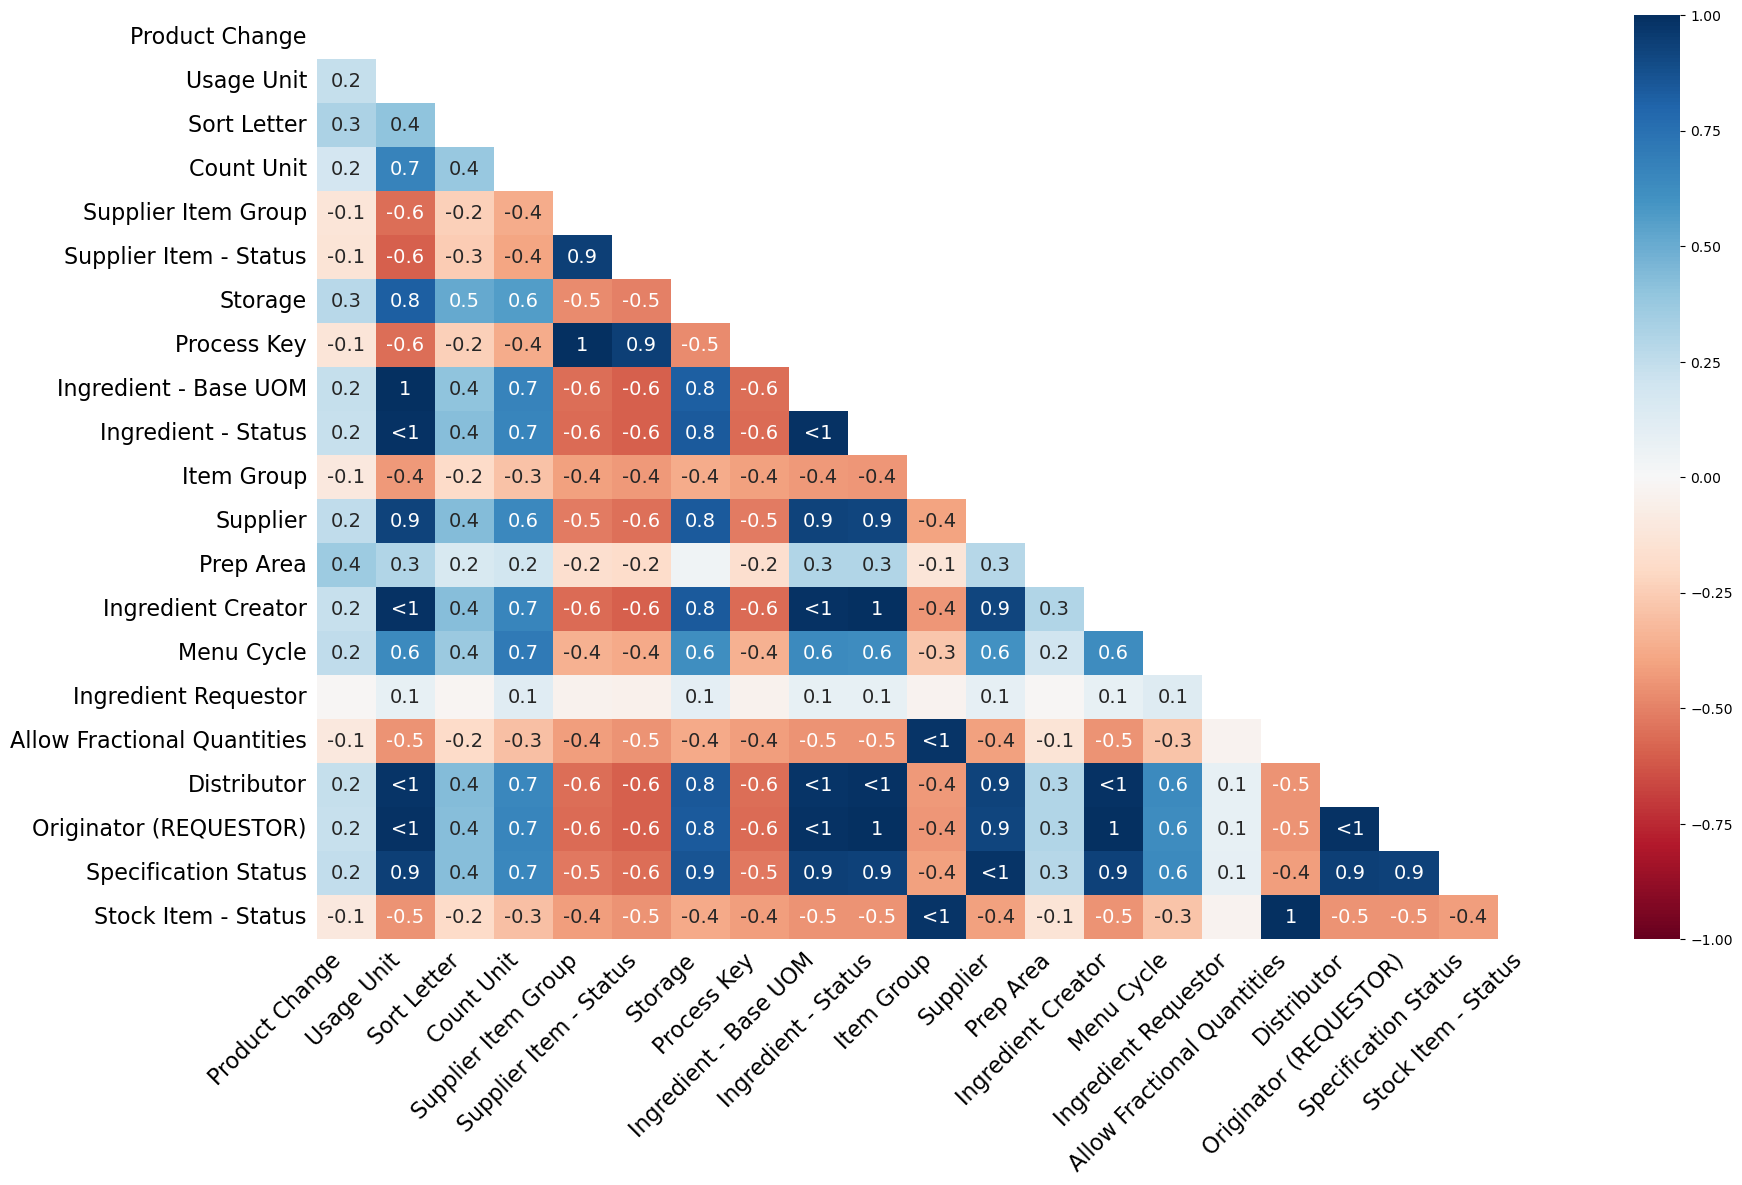

In [71]:
msno.heatmap(df_chick[cat_var])

<AxesSubplot:>

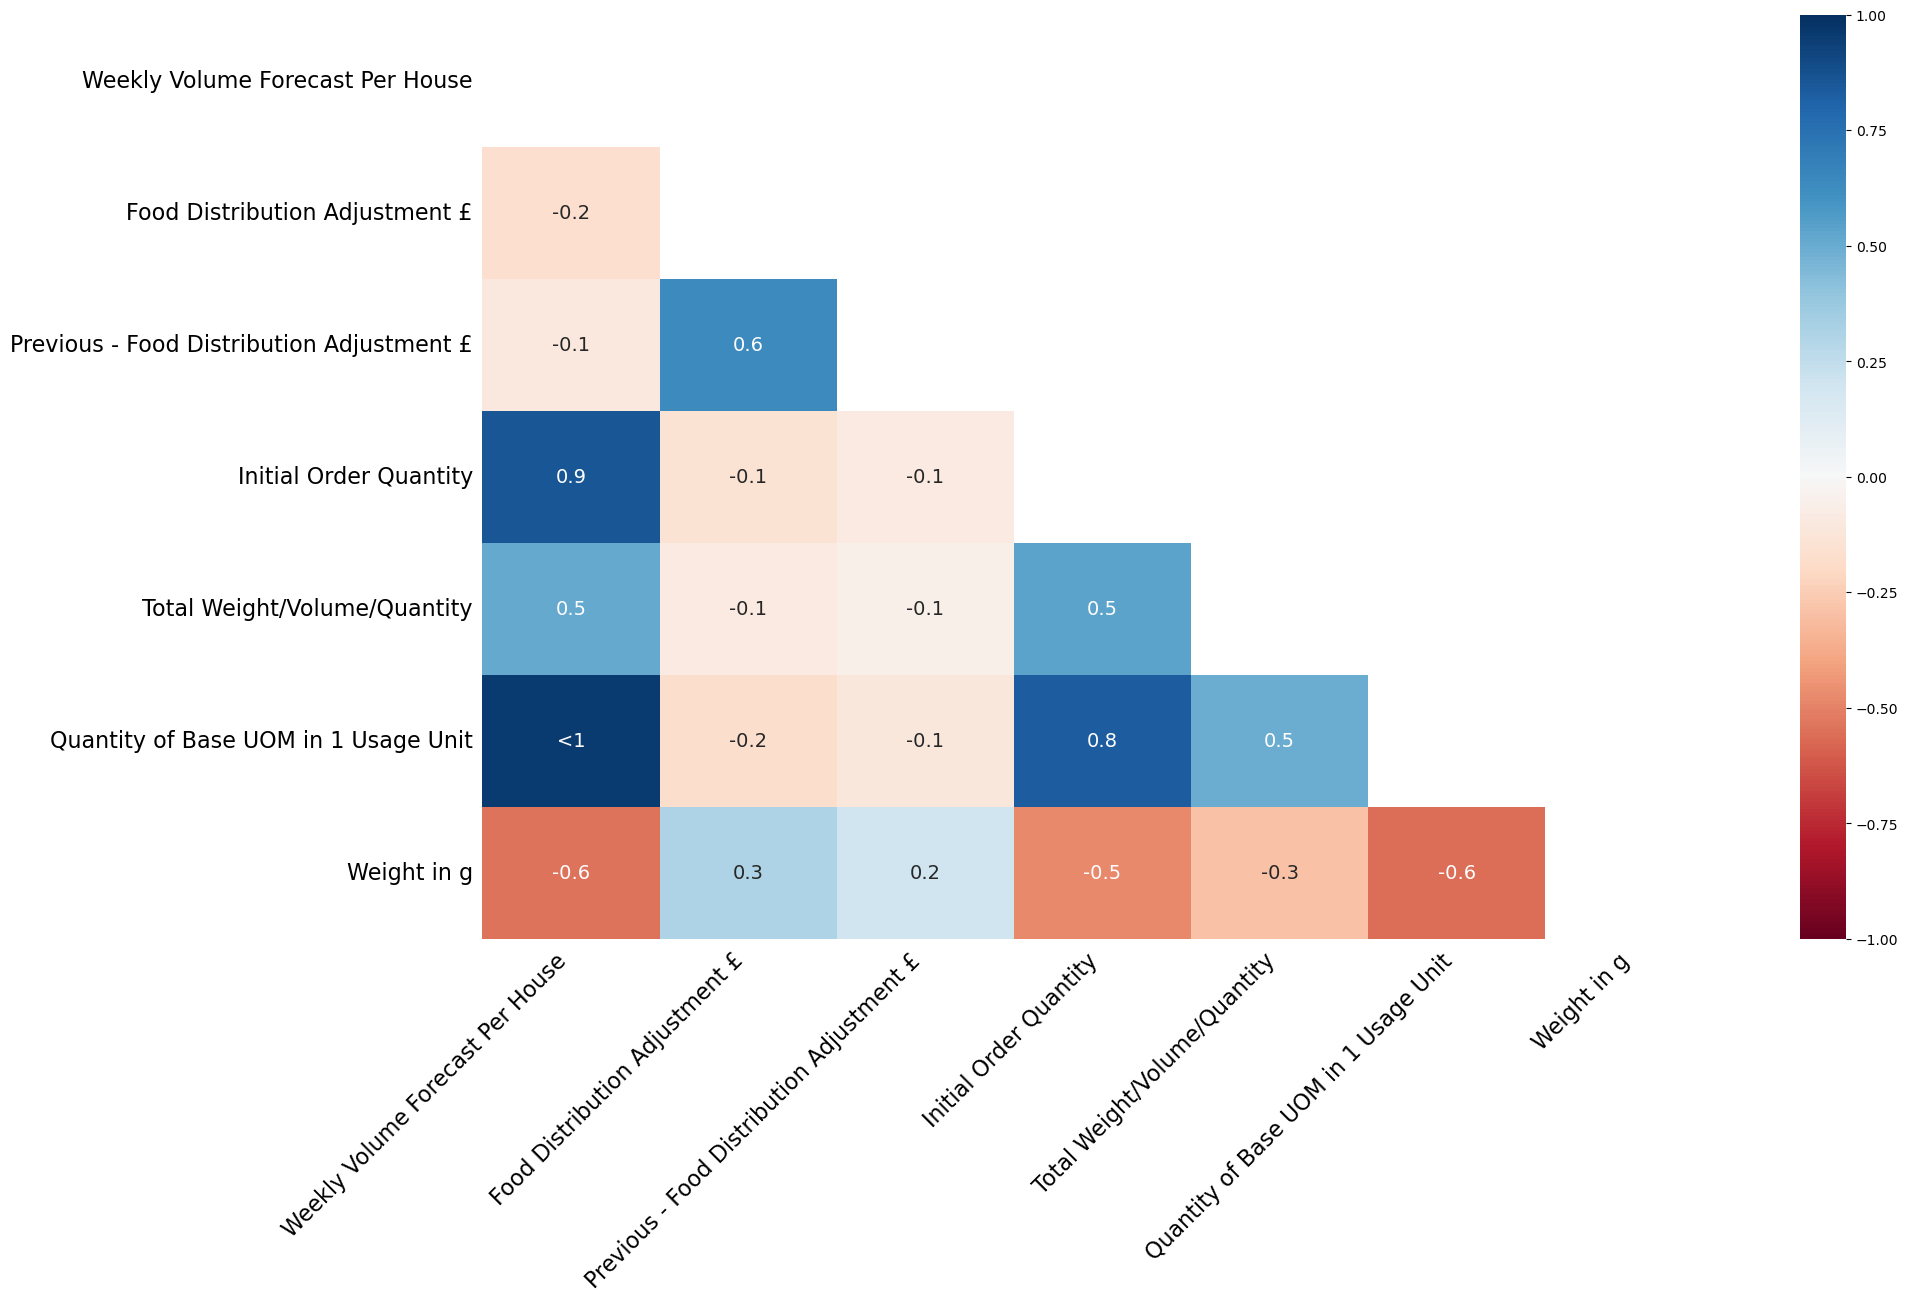

In [72]:
msno.heatmap(df_chick[num_var])

In [73]:
def rf_impute_num(train_df, test_df, n_estimators=10, random_state=123):
    imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=n_estimators), random_state=random_state)
    rf_mod = imputer.fit(train_df)
    imp_df = pd.DataFrame(rf_mod.transform(test_df), columns=test_df.columns, index=test_df.index)
    return imp_df

In [74]:
def rf_impute_cat(df_concat, cat_train, cat_test, cat_var, n_estimators=10, random_state=123):
    imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=n_estimators), random_state=random_state)
    rf_mod = imputer.fit(cat_train)
    imputed_df = pd.DataFrame(rf_mod.transform(cat_test), columns=cat_test.columns, index=cat_test.index)
    final_impute = pd.DataFrame()
    for i in cat_var:
        encoder = encode_cat(df_concat[[i]])[0]
        col_name = encode_cat(df_concat[[i]])[1]
        col_index = encode_cat(df_concat[[i]])[2]
        missing_mask = df_concat[i].isnull()
        missing_indices = missing_mask[missing_mask].index.to_list()
        missing_indices = list(set(missing_indices) & set(cat_test.index))
        for j in missing_indices:
            col_list1 = []
            for k in imputed_df.columns:
                if k.split('_')[0] == i:
                    col_list1.append(k)
            max_col = imputed_df.loc[j, col_list1].idxmax()
            imputed_df.loc[j, col_list1] = 0
            imputed_df.loc[j, max_col] = 1
        col_list2 = []
        for m in imputed_df.columns:
            if m.split('_')[0] == i:
                col_list2.append(m)
        temp_df = imputed_df[col_list2]
        if col_name:
            temp_df.insert(loc=col_index, column=col_name, value=0)
        temp_df = pd.DataFrame(encoder.inverse_transform(temp_df), columns=[i], index=cat_test.index)
        final_impute = pd.concat([final_impute, temp_df], axis=1)
    return final_impute

In [75]:
#Experiment3_1_1: RF imputation for numeric columns (20% mask)
sub_category = []
RMSE = []
MAE = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
        num_var = list(set(num_attrib) & set(clean_df.columns))
        if len(num_var) > 0:
            mask_df = create_mask(clean_df, missing_prob=0.2, random_state=random_state)
            train_df, test_df = train_test_split(mask_df[num_var], test_size=0.2, random_state=random_state)
            train_df.dropna(axis=1, how='all', inplace=True)
            update_test_df = test_df[train_df.columns]
            num_var = list(set(num_var) & set(train_df.columns))
            if len(train_df[num_var]) > 0 and len(update_test_df[num_var]) > 0:
                scaler = StandardScaler()
                num_train_scaled = pd.DataFrame(scaler.fit_transform(train_df[num_var]), columns=num_var, index=train_df.index)
                num_test_scaled = pd.DataFrame(scaler.transform(update_test_df[num_var]), columns=num_var, index=update_test_df.index)
                rf_imputed_test = rf_impute_num(num_train_scaled, num_test_scaled, random_state=123)
                rf_imputed_test = pd.DataFrame(scaler.inverse_transform(rf_imputed_test), columns=num_var, index=update_test_df.index)
                rf_imputed_metric = knn_impute_num_performance(clean_df, rf_imputed_test, num_var)
                if rf_imputed_metric is not None:
                    sub_category.append(level3_name)
                    rf_imputed_RMSE = rf_imputed_metric[0]
                    RMSE.append(rf_imputed_RMSE)
                    rf_imputed_MAE = rf_imputed_metric[1]
                    MAE.append(rf_imputed_MAE)
exp3_1_1 = pd.DataFrame({'Sub_category': sub_category, 'RMSE': RMSE, 'MAE': MAE})

In [77]:
#Experiment3_1_2: RF imputation for numeric columns (40% mask)
sub_category = []
RMSE = []
MAE = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
        num_var = list(set(num_attrib) & set(clean_df.columns))
        if len(num_var) > 0:
            mask_df = create_mask(clean_df, missing_prob=0.4, random_state=random_state)
            train_df, test_df = train_test_split(mask_df[num_var], test_size=0.2, random_state=random_state)
            train_df.dropna(axis=1, how='all', inplace=True)
            update_test_df = test_df[train_df.columns]
            num_var = list(set(num_var) & set(train_df.columns))
            if not train_df[num_var].empty:
                scaler = StandardScaler()
                num_train_scaled = pd.DataFrame(scaler.fit_transform(train_df[num_var]), columns=num_var, index=train_df.index)
                num_test_scaled = pd.DataFrame(scaler.transform(update_test_df[num_var]), columns=num_var, index=update_test_df.index)
                rf_imputed_test = rf_impute_num(num_train_scaled, num_test_scaled, random_state=123)
                rf_imputed_test = pd.DataFrame(scaler.inverse_transform(rf_imputed_test), columns=num_var, index=update_test_df.index)
                rf_imputed_metric = knn_impute_num_performance(clean_df, rf_imputed_test, num_var)
                if rf_imputed_metric is not None:
                    sub_category.append(level3_name)
                    rf_imputed_RMSE = rf_imputed_metric[0]
                    RMSE.append(rf_imputed_RMSE)
                    rf_imputed_MAE = rf_imputed_metric[1]
                    MAE.append(rf_imputed_MAE)
exp3_1_2 = pd.DataFrame({'Sub_category': sub_category, 'RMSE': RMSE, 'MAE': MAE})

In [78]:
#Experiment3_1_3: RF imputation for numeric columns (60% mask)
sub_category = []
RMSE = []
MAE = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
        num_var = list(set(num_attrib) & set(clean_df.columns))
        if len(num_var) > 0:
            mask_df = create_mask(clean_df, missing_prob=0.6, random_state=random_state)
            train_df, test_df = train_test_split(mask_df[num_var], test_size=0.2, random_state=random_state)
            train_df.dropna(axis=1, how='all', inplace=True)
            update_test_df = test_df[train_df.columns]
            num_var = list(set(num_var) & set(train_df.columns))
            if not train_df[num_var].empty:
                scaler = StandardScaler()
                num_train_scaled = pd.DataFrame(scaler.fit_transform(train_df[num_var]), columns=num_var, index=train_df.index)
                num_test_scaled = pd.DataFrame(scaler.transform(update_test_df[num_var]), columns=num_var, index=update_test_df.index)
                rf_imputed_test = rf_impute_num(num_train_scaled, num_test_scaled, random_state=123)
                rf_imputed_test = pd.DataFrame(scaler.inverse_transform(rf_imputed_test), columns=num_var, index=update_test_df.index)
                rf_imputed_metric = knn_impute_num_performance(clean_df, rf_imputed_test, num_var)
                if rf_imputed_metric is not None:
                    sub_category.append(level3_name)
                    rf_imputed_RMSE = rf_imputed_metric[0]
                    RMSE.append(rf_imputed_RMSE)
                    rf_imputed_MAE = rf_imputed_metric[1]
                    MAE.append(rf_imputed_MAE)
exp3_1_3 = pd.DataFrame({'Sub_category': sub_category, 'RMSE': RMSE, 'MAE': MAE})

In [79]:
#Experiment3_1_4: RF imputation for numeric columns (80% mask)
sub_category = []
RMSE = []
MAE = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
        num_var = list(set(num_attrib) & set(clean_df.columns))
        if len(num_var) > 0:
            mask_df = create_mask(clean_df, missing_prob=0.8, random_state=random_state)
            train_df, test_df = train_test_split(mask_df[num_var], test_size=0.2, random_state=random_state)
            train_df.dropna(axis=1, how='all', inplace=True)
            update_test_df = test_df[train_df.columns]
            num_var = list(set(num_var) & set(train_df.columns))
            if not train_df[num_var].empty:
                scaler = StandardScaler()
                num_train_scaled = pd.DataFrame(scaler.fit_transform(train_df[num_var]), columns=num_var, index=train_df.index)
                num_test_scaled = pd.DataFrame(scaler.transform(update_test_df[num_var]), columns=num_var, index=update_test_df.index)
                rf_imputed_test = rf_impute_num(num_train_scaled, num_test_scaled, random_state=123)
                rf_imputed_test = pd.DataFrame(scaler.inverse_transform(rf_imputed_test), columns=num_var, index=update_test_df.index)
                rf_imputed_metric = knn_impute_num_performance(clean_df, rf_imputed_test, num_var)
                if rf_imputed_metric is not None:
                    sub_category.append(level3_name)
                    rf_imputed_RMSE = rf_imputed_metric[0]
                    RMSE.append(rf_imputed_RMSE)
                    rf_imputed_MAE = rf_imputed_metric[1]
                    MAE.append(rf_imputed_MAE)
exp3_1_4 = pd.DataFrame({'Sub_category': sub_category, 'RMSE': RMSE, 'MAE': MAE})

In [80]:
#Experiment3_2_1: RF imputation for categorical columns (20% mask)
sub_category = []
Accuracy = []
Precision = []
Recall = []
F1_score = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
        cat_var = list(set(cat_attrib) & set(clean_df.columns))
        if len(cat_var) > 0:
            mask_df = create_mask(clean_df, missing_prob=0.2, random_state=random_state)
            for i in cat_var:
                mask_df[i] = mask_df[i].astype(str)
                mask_df[i] = mask_df[i].replace('nan', np.nan)
            train_df, test_df = train_test_split(mask_df[cat_var], test_size=0.2, random_state=random_state)
            train_df.dropna(axis=1, how='all', inplace=True)
            update_test_df = test_df[train_df.columns]
            cat_var = list(set(cat_var) & set(train_df.columns))
            df_concat = pd.concat([train_df, update_test_df])
            cat_df = pd.DataFrame()
            for i in cat_var:
                cat_df = pd.concat([cat_df, encode_cat(df_concat[[i]])[3]], axis=1)
            cat_train = cat_df.loc[train_df.index]
            cat_test = cat_df.loc[test_df.index]
            rf_imputed_test = rf_impute_cat(df_concat, cat_train, cat_test, cat_var, n_estimators=10, random_state=123)
            rf_imputed_metric = knn_impute_cat_performance(clean_df, rf_imputed_test, cat_var)
            if rf_imputed_metric is not None:
                sub_category.append(level3_name)
                rf_imputed_accuracy = rf_imputed_metric[0]
                Accuracy.append(rf_imputed_accuracy)
                rf_imputed_precision = rf_imputed_metric[1]
                Precision.append(rf_imputed_precision)
                rf_imputed_recall = rf_imputed_metric[2]
                Recall.append(rf_imputed_recall)
                rf_imputed_F1 = rf_imputed_metric[3]
                F1_score.append(rf_imputed_F1)
exp3_2_1 = pd.DataFrame({'Sub_category': sub_category, 'Accuracy': Accuracy, 'Precision': Precision, 'Recall': Recall, 'F1_score': F1_score})

In [81]:
#Experiment3_2_2: RF imputation for categorical columns (40% mask)
sub_category = []
Accuracy = []
Precision = []
Recall = []
F1_score = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
        cat_var = list(set(cat_attrib) & set(clean_df.columns))
        if len(cat_var) > 0:
            mask_df = create_mask(clean_df, missing_prob=0.4, random_state=random_state)
            for i in cat_var:
                mask_df[i] = mask_df[i].astype(str)
                mask_df[i] = mask_df[i].replace('nan', np.nan)
            train_df, test_df = train_test_split(mask_df[cat_var], test_size=0.2, random_state=random_state)
            train_df.dropna(axis=1, how='all', inplace=True)
            update_test_df = test_df[train_df.columns]
            cat_var = list(set(cat_var) & set(train_df.columns))
            df_concat = pd.concat([train_df, update_test_df])
            cat_df = pd.DataFrame()
            for i in cat_var:
                cat_df = pd.concat([cat_df, encode_cat(df_concat[[i]])[3]], axis=1)
            cat_train = cat_df.loc[train_df.index]
            cat_test = cat_df.loc[test_df.index]
            rf_imputed_test = rf_impute_cat(df_concat, cat_train, cat_test, cat_var, n_estimators=10, random_state=123)
            rf_imputed_metric = knn_impute_cat_performance(clean_df, rf_imputed_test, cat_var)
            if rf_imputed_metric is not None:
                sub_category.append(level3_name)
                rf_imputed_accuracy = rf_imputed_metric[0]
                Accuracy.append(rf_imputed_accuracy)
                rf_imputed_precision = rf_imputed_metric[1]
                Precision.append(rf_imputed_precision)
                rf_imputed_recall = rf_imputed_metric[2]
                Recall.append(rf_imputed_recall)
                rf_imputed_F1 = rf_imputed_metric[3]
                F1_score.append(rf_imputed_F1)
exp3_2_2 = pd.DataFrame({'Sub_category': sub_category, 'Accuracy': Accuracy, 'Precision': Precision, 'Recall': Recall, 'F1_score': F1_score})

In [84]:
#Experiment3_2_3: RF imputation for categorical columns (60% mask)
sub_category = []
Accuracy = []
Precision = []
Recall = []
F1_score = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
        cat_var = list(set(cat_attrib) & set(clean_df.columns))
        if len(cat_var) > 0:
            mask_df = create_mask(clean_df, missing_prob=0.6, random_state=random_state)
            for i in cat_var:
                mask_df[i] = mask_df[i].astype(str)
                mask_df[i] = mask_df[i].replace('nan', np.nan)
            train_df, test_df = train_test_split(mask_df[cat_var], test_size=0.2, random_state=random_state)
            train_df.dropna(axis=1, how='all', inplace=True)
            update_test_df = test_df[train_df.columns]
            cat_var = list(set(cat_var) & set(train_df.columns))
            df_concat = pd.concat([train_df, update_test_df])
            cat_df = pd.DataFrame()
            for i in cat_var:
                cat_df = pd.concat([cat_df, encode_cat(df_concat[[i]])[3]], axis=1)
            if not cat_df.empty:
                cat_train = cat_df.loc[train_df.index]
                cat_test = cat_df.loc[test_df.index]
                rf_imputed_test = rf_impute_cat(df_concat, cat_train, cat_test, cat_var, n_estimators=10, random_state=123)
                rf_imputed_metric = knn_impute_cat_performance(clean_df, rf_imputed_test, cat_var)
                if rf_imputed_metric is not None:
                    sub_category.append(level3_name)
                    rf_imputed_accuracy = rf_imputed_metric[0]
                    Accuracy.append(rf_imputed_accuracy)
                    rf_imputed_precision = rf_imputed_metric[1]
                    Precision.append(rf_imputed_precision)
                    rf_imputed_recall = rf_imputed_metric[2]
                    Recall.append(rf_imputed_recall)
                    rf_imputed_F1 = rf_imputed_metric[3]
                    F1_score.append(rf_imputed_F1)
exp3_2_3 = pd.DataFrame({'Sub_category': sub_category, 'Accuracy': Accuracy, 'Precision': Precision, 'Recall': Recall, 'F1_score': F1_score})

In [ ]:
#Experiment3_2_4: RF imputation for categorical columns (80% mask)
sub_category = []
Accuracy = []
Precision = []
Recall = []
F1_score = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
        cat_var = list(set(cat_attrib) & set(clean_df.columns))
        if len(cat_var) > 0:
            mask_df = create_mask(clean_df, missing_prob=0.8, random_state=random_state)
            for i in cat_var:
                mask_df[i] = mask_df[i].astype(str)
                mask_df[i] = mask_df[i].replace('nan', np.nan)
            train_df, test_df = train_test_split(mask_df[cat_var], test_size=0.2, random_state=random_state)
            train_df.dropna(axis=1, how='all', inplace=True)
            update_test_df = test_df[train_df.columns]
            cat_var = list(set(cat_var) & set(train_df.columns))
            df_concat = pd.concat([train_df, update_test_df])
            cat_df = pd.DataFrame()
            for i in cat_var:
                cat_df = pd.concat([cat_df, encode_cat(df_concat[[i]])[3]], axis=1)
            if not cat_df.empty:
                cat_train = cat_df.loc[train_df.index]
                cat_test = cat_df.loc[test_df.index]
                rf_imputed_test = rf_impute_cat(df_concat, cat_train, cat_test, cat_var, n_estimators=10, random_state=123)
                rf_imputed_metric = knn_impute_cat_performance(clean_df, rf_imputed_test, cat_var)
                if rf_imputed_metric is not None:
                    sub_category.append(level3_name)
                    rf_imputed_accuracy = rf_imputed_metric[0]
                    Accuracy.append(rf_imputed_accuracy)
                    rf_imputed_precision = rf_imputed_metric[1]
                    Precision.append(rf_imputed_precision)
                    rf_imputed_recall = rf_imputed_metric[2]
                    Recall.append(rf_imputed_recall)
                    rf_imputed_F1 = rf_imputed_metric[3]
                    F1_score.append(rf_imputed_F1)
exp3_2_4 = pd.DataFrame({'Sub_category': sub_category, 'Accuracy': Accuracy, 'Precision': Precision, 'Recall': Recall, 'F1_score': F1_score})

In [ ]:
exp3_1_1.set_index('Sub_category')[['RMSE', 'MAE']].plot(figsize=(20,10), kind='line')
plt.xticks(range(len(exp3_1_1['Sub_category'])), exp3_1_1['Sub_category'], rotation=90, fontsize=10)
plt.xlabel('Sub_category')
plt.title('missing fraction: 20%, attribute: numerical, method: Random Forest')
plt.show()

In [ ]:
exp3_1_2.set_index('Sub_category')[['RMSE', 'MAE']].plot(figsize=(20,10), kind='line')
plt.xticks(range(len(exp3_1_2['Sub_category'])), exp3_1_2['Sub_category'], rotation=90, fontsize=10)
plt.xlabel('Sub_category')
plt.title('missing fraction: 40%, attribute: numerical, method: Random Forest')
plt.show()

In [ ]:
exp3_1_3.set_index('Sub_category')[['RMSE', 'MAE']].plot(figsize=(20,10), kind='line')
plt.xticks(range(len(exp3_1_3['Sub_category'])), exp3_1_3['Sub_category'], rotation=90, fontsize=10)
plt.xlabel('Sub_category')
plt.title('missing fraction: 60%, attribute: numerical, method: Random Forest')
plt.show()

In [ ]:
exp3_1_4.set_index('Sub_category')[['RMSE', 'MAE']].plot(figsize=(20,10), kind='line')
plt.xticks(range(len(exp3_1_4['Sub_category'])), exp3_1_4['Sub_category'], rotation=90, fontsize=10)
plt.xlabel('Sub_category')
plt.title('missing fraction: 80%, attribute: numerical, method: Random Forest')
plt.show()

In [ ]:
exp3_2_1.set_index('Sub_category')[['Accuracy', 'Precision', 'Recall', 'F1_score']].plot(figsize=(20,10), kind='line')
plt.xticks(range(len(exp3_2_1['Sub_category'])), exp3_2_1['Sub_category'], rotation=90, fontsize=10)
plt.xlabel('Sub_category')
plt.title('missing fraction: 20%, attribute: categorical, method: Random Forest')
plt.show()

In [ ]:
exp3_2_2.set_index('Sub_category')[['Accuracy', 'Precision', 'Recall', 'F1_score']].plot(figsize=(20,10), kind='line')
plt.xticks(range(len(exp3_2_2['Sub_category'])), exp3_2_2['Sub_category'], rotation=90, fontsize=10)
plt.xlabel('Sub_category')
plt.title('missing fraction: 40%, attribute: categorical, method: Random Forest')
plt.show()

In [ ]:
exp3_2_3.set_index('Sub_category')[['Accuracy', 'Precision', 'Recall', 'F1_score']].plot(figsize=(20,10), kind='line')
plt.xticks(range(len(exp3_2_3['Sub_category'])), exp3_2_3['Sub_category'], rotation=90, fontsize=10)
plt.xlabel('Sub_category')
plt.title('missing fraction: 60%, attribute: categorical, method: Random Forest')
plt.show()

In [ ]:
exp3_2_4.set_index('Sub_category')[['Accuracy', 'Precision', 'Recall', 'F1_score']].plot(figsize=(20,10), kind='line')
plt.xticks(range(len(exp3_2_4['Sub_category'])), exp3_2_4['Sub_category'], rotation=90, fontsize=10)
plt.xlabel('Sub_category')
plt.title('missing fraction: 80%, attribute: categorical, method: Random Forest')
plt.show()

In [ ]:
def lr_impute_num(train_df, test_df, n_estimators=10, random_state=123):
    imputer = IterativeImputer(estimator=LinearRegression(), random_state=random_state)
    lr_mod = imputer.fit(train_df)
    imp_df = pd.DataFrame(lr_mod.transform(test_df), columns=test_df.columns, index=test_df.index)
    return imp_df

In [ ]:
def svr_impute_cat(df_concat, cat_train, cat_test, cat_var, random_state=123):
    imputer = IterativeImputer(estimator=SVR(), random_state=random_state)
    svr_mod = imputer.fit(cat_train)
    imputed_df = pd.DataFrame(svr_mod.transform(cat_test), columns=cat_test.columns, index=cat_test.index)
    final_impute = pd.DataFrame()
    for i in cat_var:
        encoder = encode_cat(df_concat[[i]])[0]
        col_name = encode_cat(df_concat[[i]])[1]
        col_index = encode_cat(df_concat[[i]])[2]
        missing_mask = df_concat[i].isnull()
        missing_indices = missing_mask[missing_mask].index.to_list()
        missing_indices = list(set(missing_indices) & set(cat_test.index))
        for j in missing_indices:
            col_list1 = []
            for k in imputed_df.columns:
                if k.split('_')[0] == i:
                    col_list1.append(k)
            max_col = imputed_df.loc[j, col_list1].idxmax()
            imputed_df.loc[j, col_list1] = 0
            imputed_df.loc[j, max_col] = 1
        col_list2 = []
        for m in imputed_df.columns:
            if m.split('_')[0] == i:
                col_list2.append(m)
        temp_df = imputed_df[col_list2]
        if col_name:
            temp_df.insert(loc=col_index, column=col_name, value=0)
        temp_df = pd.DataFrame(encoder.inverse_transform(temp_df), columns=[i], index=cat_test.index)
        final_impute = pd.concat([final_impute, temp_df], axis=1)
    return final_impute

In [ ]:
#Experiment4_1_1: LR imputation for numeric columns (20% mask)
sub_category = []
RMSE = []
MAE = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
        num_var = list(set(num_attrib) & set(clean_df.columns))
        if len(num_var) > 0:
            mask_df = create_mask(clean_df, missing_prob=0.2, random_state=random_state)
            train_df, test_df = train_test_split(mask_df[num_var], test_size=0.2, random_state=random_state)
            train_df.dropna(axis=1, how='all', inplace=True)
            update_test_df = test_df[train_df.columns]
            num_var = list(set(num_var) & set(train_df.columns))
            if len(train_df[num_var]) > 0 and len(update_test_df[num_var]) > 0:
                scaler = StandardScaler()
                num_train_scaled = pd.DataFrame(scaler.fit_transform(train_df[num_var]), columns=num_var, index=train_df.index)
                num_test_scaled = pd.DataFrame(scaler.transform(update_test_df[num_var]), columns=num_var, index=update_test_df.index)
                lr_imputed_test = lr_impute_num(num_train_scaled, num_test_scaled, random_state=123)
                lr_imputed_test = pd.DataFrame(scaler.inverse_transform(lr_imputed_test), columns=num_var, index=update_test_df.index)
                lr_imputed_metric = knn_impute_num_performance(clean_df, lr_imputed_test, num_var)
                if lr_imputed_metric is not None:
                    sub_category.append(level3_name)
                    lr_imputed_RMSE = lr_imputed_metric[0]
                    RMSE.append(lr_imputed_RMSE)
                    lr_imputed_MAE = lr_imputed_metric[1]
                    MAE.append(lr_imputed_MAE)
exp4_1_1 = pd.DataFrame({'Sub_category': sub_category, 'RMSE': RMSE, 'MAE': MAE})

In [ ]:
#Experiment4_1_2: LR imputation for numeric columns (40% mask)
sub_category = []
RMSE = []
MAE = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
        num_var = list(set(num_attrib) & set(clean_df.columns))
        if len(num_var) > 0:
            mask_df = create_mask(clean_df, missing_prob=0.4, random_state=random_state)
            train_df, test_df = train_test_split(mask_df[num_var], test_size=0.2, random_state=random_state)
            train_df.dropna(axis=1, how='all', inplace=True)
            update_test_df = test_df[train_df.columns]
            num_var = list(set(num_var) & set(train_df.columns))
            if len(train_df[num_var]) > 0 and len(update_test_df[num_var]) > 0:
                scaler = StandardScaler()
                num_train_scaled = pd.DataFrame(scaler.fit_transform(train_df[num_var]), columns=num_var, index=train_df.index)
                num_test_scaled = pd.DataFrame(scaler.transform(update_test_df[num_var]), columns=num_var, index=update_test_df.index)
                lr_imputed_test = lr_impute_num(num_train_scaled, num_test_scaled, random_state=123)
                lr_imputed_test = pd.DataFrame(scaler.inverse_transform(lr_imputed_test), columns=num_var, index=update_test_df.index)
                lr_imputed_metric = knn_impute_num_performance(clean_df, lr_imputed_test, num_var)
                if lr_imputed_metric is not None:
                    sub_category.append(level3_name)
                    lr_imputed_RMSE = lr_imputed_metric[0]
                    RMSE.append(lr_imputed_RMSE)
                    lr_imputed_MAE = lr_imputed_metric[1]
                    MAE.append(lr_imputed_MAE)
exp4_1_2 = pd.DataFrame({'Sub_category': sub_category, 'RMSE': RMSE, 'MAE': MAE})

In [ ]:
#Experiment4_1_3: LR imputation for numeric columns (60% mask)
sub_category = []
RMSE = []
MAE = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
        num_var = list(set(num_attrib) & set(clean_df.columns))
        if len(num_var) > 0:
            mask_df = create_mask(clean_df, missing_prob=0.6, random_state=random_state)
            train_df, test_df = train_test_split(mask_df[num_var], test_size=0.2, random_state=random_state)
            train_df.dropna(axis=1, how='all', inplace=True)
            update_test_df = test_df[train_df.columns]
            num_var = list(set(num_var) & set(train_df.columns))
            if not train_df[num_var].empty:
                scaler = StandardScaler()
                num_train_scaled = pd.DataFrame(scaler.fit_transform(train_df[num_var]), columns=num_var, index=train_df.index)
                num_test_scaled = pd.DataFrame(scaler.transform(update_test_df[num_var]), columns=num_var, index=update_test_df.index)
                lr_imputed_test = lr_impute_num(num_train_scaled, num_test_scaled, random_state=123)
                lr_imputed_test = pd.DataFrame(scaler.inverse_transform(lr_imputed_test), columns=num_var, index=update_test_df.index)
                lr_imputed_metric = knn_impute_num_performance(clean_df, lr_imputed_test, num_var)
                if lr_imputed_metric is not None:
                    sub_category.append(level3_name)
                    lr_imputed_RMSE = lr_imputed_metric[0]
                    RMSE.append(lr_imputed_RMSE)
                    lr_imputed_MAE = lr_imputed_metric[1]
                    MAE.append(lr_imputed_MAE)
exp4_1_3 = pd.DataFrame({'Sub_category': sub_category, 'RMSE': RMSE, 'MAE': MAE})

In [ ]:
#Experiment4_1_4: LR imputation for numeric columns (80% mask)
sub_category = []
RMSE = []
MAE = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
        num_var = list(set(num_attrib) & set(clean_df.columns))
        if len(num_var) > 0:
            mask_df = create_mask(clean_df, missing_prob=0.8, random_state=random_state)
            train_df, test_df = train_test_split(mask_df[num_var], test_size=0.2, random_state=random_state)
            train_df.dropna(axis=1, how='all', inplace=True)
            update_test_df = test_df[train_df.columns]
            num_var = list(set(num_var) & set(train_df.columns))
            if not train_df[num_var].empty:
                scaler = StandardScaler()
                num_train_scaled = pd.DataFrame(scaler.fit_transform(train_df[num_var]), columns=num_var, index=train_df.index)
                num_test_scaled = pd.DataFrame(scaler.transform(update_test_df[num_var]), columns=num_var, index=update_test_df.index)
                lr_imputed_test = lr_impute_num(num_train_scaled, num_test_scaled, random_state=123)
                lr_imputed_test = pd.DataFrame(scaler.inverse_transform(lr_imputed_test), columns=num_var, index=update_test_df.index)
                lr_imputed_metric = knn_impute_num_performance(clean_df, lr_imputed_test, num_var)
                if lr_imputed_metric is not None:
                    sub_category.append(level3_name)
                    lr_imputed_RMSE = lr_imputed_metric[0]
                    RMSE.append(lr_imputed_RMSE)
                    lr_imputed_MAE = lr_imputed_metric[1]
                    MAE.append(lr_imputed_MAE)
exp4_1_4 = pd.DataFrame({'Sub_category': sub_category, 'RMSE': RMSE, 'MAE': MAE})

In [ ]:
#Experiment4_2_1: svr imputation for categorical columns (20% mask)
sub_category = []
Accuracy = []
Precision = []
Recall = []
F1_score = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
        cat_var = list(set(cat_attrib) & set(clean_df.columns))
        if len(cat_var) > 0:
            mask_df = create_mask(clean_df, missing_prob=0.2, random_state=random_state)
            for i in cat_var:
                mask_df[i] = mask_df[i].astype(str)
                mask_df[i] = mask_df[i].replace('nan', np.nan)
            train_df, test_df = train_test_split(mask_df[cat_var], test_size=0.2, random_state=random_state)
            train_df.dropna(axis=1, how='all', inplace=True)
            update_test_df = test_df[train_df.columns]          
            cat_var = list(set(cat_var) & set(train_df.columns))
            df_concat = pd.concat([train_df, update_test_df])
            cat_df = pd.DataFrame()
            for i in cat_var:
                cat_df = pd.concat([cat_df, encode_cat(df_concat[[i]])[3]], axis=1)
            if not cat_df.empty:
                cat_train = cat_df.loc[train_df.index]
                cat_test = cat_df.loc[test_df.index]
                svr_imputed_test = svr_impute_cat(df_concat, cat_train, cat_test, cat_var, random_state=123)
                svr_imputed_metric = knn_impute_cat_performance(clean_df, svr_imputed_test, cat_var)
                if svr_imputed_metric is not None:
                    sub_category.append(level3_name)
                    svr_imputed_accuracy = svr_imputed_metric[0]
                    Accuracy.append(svr_imputed_accuracy)
                    svr_imputed_precision = svr_imputed_metric[1]
                    Precision.append(svr_imputed_precision)
                    svr_imputed_recall = svr_imputed_metric[2]
                    Recall.append(svr_imputed_recall)
                    svr_imputed_F1 = svr_imputed_metric[3]
                    F1_score.append(svr_imputed_F1)
exp4_2_1 = pd.DataFrame({'Sub_category': sub_category, 'Accuracy': Accuracy, 'Precision': Precision, 'Recall': Recall, 'F1_score': F1_score})

In [ ]:
#Experiment4_2_2: svr imputation for categorical columns (40% mask)
sub_category = []
Accuracy = []
Precision = []
Recall = []
F1_score = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
        cat_var = list(set(cat_attrib) & set(clean_df.columns))
        if len(cat_var) > 0:
            mask_df = create_mask(clean_df, missing_prob=0.4, random_state=random_state)
            for i in cat_var:
                mask_df[i] = mask_df[i].astype(str)
                mask_df[i] = mask_df[i].replace('nan', np.nan)
            train_df, test_df = train_test_split(mask_df[cat_var], test_size=0.2, random_state=random_state)
            train_df.dropna(axis=1, how='all', inplace=True)
            update_test_df = test_df[train_df.columns]          
            cat_var = list(set(cat_var) & set(train_df.columns))
            df_concat = pd.concat([train_df, update_test_df])
            cat_df = pd.DataFrame()
            for i in cat_var:
                cat_df = pd.concat([cat_df, encode_cat(df_concat[[i]])[3]], axis=1)
            if not cat_df.empty:
                cat_train = cat_df.loc[train_df.index]
                cat_test = cat_df.loc[test_df.index]
                svr_imputed_test = svr_impute_cat(df_concat, cat_train, cat_test, cat_var, random_state=123)
                svr_imputed_metric = knn_impute_cat_performance(clean_df, svr_imputed_test, cat_var)
                if svr_imputed_metric is not None:
                    sub_category.append(level3_name)
                    svr_imputed_accuracy = svr_imputed_metric[0]
                    Accuracy.append(svr_imputed_accuracy)
                    svr_imputed_precision = svr_imputed_metric[1]
                    Precision.append(svr_imputed_precision)
                    svr_imputed_recall = svr_imputed_metric[2]
                    Recall.append(svr_imputed_recall)
                    svr_imputed_F1 = svr_imputed_metric[3]
                    F1_score.append(svr_imputed_F1)
exp4_2_2 = pd.DataFrame({'Sub_category': sub_category, 'Accuracy': Accuracy, 'Precision': Precision, 'Recall': Recall, 'F1_score': F1_score})

In [ ]:
#Experiment4_2_3: svr imputation for categorical columns (60% mask)
sub_category = []
Accuracy = []
Precision = []
Recall = []
F1_score = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
        cat_var = list(set(cat_attrib) & set(clean_df.columns))
        if len(cat_var) > 0:
            mask_df = create_mask(clean_df, missing_prob=0.6, random_state=random_state)
            for i in cat_var:
                mask_df[i] = mask_df[i].astype(str)
                mask_df[i] = mask_df[i].replace('nan', np.nan)
            train_df, test_df = train_test_split(mask_df[cat_var], test_size=0.2, random_state=random_state)
            train_df.dropna(axis=1, how='all', inplace=True)
            update_test_df = test_df[train_df.columns]          
            cat_var = list(set(cat_var) & set(train_df.columns))
            df_concat = pd.concat([train_df, update_test_df])
            cat_df = pd.DataFrame()
            for i in cat_var:
                cat_df = pd.concat([cat_df, encode_cat(df_concat[[i]])[3]], axis=1)
            if not cat_df.empty:
                cat_train = cat_df.loc[train_df.index]
                cat_test = cat_df.loc[test_df.index]
                svr_imputed_test = svr_impute_cat(df_concat, cat_train, cat_test, cat_var, random_state=123)
                svr_imputed_metric = knn_impute_cat_performance(clean_df, svr_imputed_test, cat_var)
                if svr_imputed_metric is not None:
                    sub_category.append(level3_name)
                    svr_imputed_accuracy = svr_imputed_metric[0]
                    Accuracy.append(svr_imputed_accuracy)
                    svr_imputed_precision = svr_imputed_metric[1]
                    Precision.append(svr_imputed_precision)
                    svr_imputed_recall = svr_imputed_metric[2]
                    Recall.append(svr_imputed_recall)
                    svr_imputed_F1 = svr_imputed_metric[3]
                    F1_score.append(svr_imputed_F1)
exp4_2_3 = pd.DataFrame({'Sub_category': sub_category, 'Accuracy': Accuracy, 'Precision': Precision, 'Recall': Recall, 'F1_score': F1_score})

In [ ]:
#Experiment4_2_4: svr imputation for categorical columns (80% mask)
sub_category = []
Accuracy = []
Precision = []
Recall = []
F1_score = []
for i in buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].index:
    level3_id = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<ID>']
    level3_name = buy_side[buy_side['<Object Type Name>'] == 'Buy Side: Level 3'].loc[i]['<Name>']
    temp_df = get_leaf3(buy_side, level3_id)
    if len(temp_df) > 0:
        clean_df = remove_single_attrib(drop_nan(remove_derive(attrib_df, temp_df), 0.8))
        cat_var = list(set(cat_attrib) & set(clean_df.columns))
        if len(cat_var) > 0:
            mask_df = create_mask(clean_df, missing_prob=0.8, random_state=random_state)
            for i in cat_var:
                mask_df[i] = mask_df[i].astype(str)
                mask_df[i] = mask_df[i].replace('nan', np.nan)
            train_df, test_df = train_test_split(mask_df[cat_var], test_size=0.2, random_state=random_state)
            train_df.dropna(axis=1, how='all', inplace=True)
            update_test_df = test_df[train_df.columns]          
            cat_var = list(set(cat_var) & set(train_df.columns))
            df_concat = pd.concat([train_df, update_test_df])
            cat_df = pd.DataFrame()
            for i in cat_var:
                cat_df = pd.concat([cat_df, encode_cat(df_concat[[i]])[3]], axis=1)
            if not cat_df.empty:
                cat_train = cat_df.loc[train_df.index]
                cat_test = cat_df.loc[test_df.index]
                svr_imputed_test = svr_impute_cat(df_concat, cat_train, cat_test, cat_var, random_state=123)
                svr_imputed_metric = knn_impute_cat_performance(clean_df, svr_imputed_test, cat_var)
                if svr_imputed_metric is not None:
                    sub_category.append(level3_name)
                    svr_imputed_accuracy = svr_imputed_metric[0]
                    Accuracy.append(svr_imputed_accuracy)
                    svr_imputed_precision = svr_imputed_metric[1]
                    Precision.append(svr_imputed_precision)
                    svr_imputed_recall = svr_imputed_metric[2]
                    Recall.append(svr_imputed_recall)
                    svr_imputed_F1 = svr_imputed_metric[3]
                    F1_score.append(svr_imputed_F1)
exp4_2_4 = pd.DataFrame({'Sub_category': sub_category, 'Accuracy': Accuracy, 'Precision': Precision, 'Recall': Recall, 'F1_score': F1_score})

In [ ]:
exp4_1_1.set_index('Sub_category')[['RMSE', 'MAE']].plot(figsize=(20,10), kind='line')
plt.xticks(range(len(exp4_1_1['Sub_category'])), exp4_1_1['Sub_category'], rotation=90, fontsize=10)
plt.xlabel('Sub_category')
plt.ylim(0, 8000)
plt.title('missing fraction: 20%, attribute: numerical, method: Linear Regression')
plt.show()

In [ ]:
exp4_1_2.set_index('Sub_category')[['RMSE', 'MAE']].plot(figsize=(20,10), kind='line')
plt.xticks(range(len(exp4_1_1['Sub_category'])), exp4_1_1['Sub_category'], rotation=90, fontsize=10)
plt.xlabel('Sub_category')
plt.title('missing fraction: 40%, attribute: numerical, method: Linear Regression')
plt.show()

In [ ]:
exp4_1_3.set_index('Sub_category')[['RMSE', 'MAE']].plot(figsize=(20,10), kind='line')
plt.xticks(range(len(exp4_1_1['Sub_category'])), exp4_1_1['Sub_category'], rotation=90, fontsize=10)
plt.xlabel('Sub_category')
plt.title('missing fraction: 60%, attribute: numerical, method: Linear Regression')
plt.show()

In [ ]:
exp4_1_4.set_index('Sub_category')[['RMSE', 'MAE']].plot(figsize=(20,10), kind='line')
plt.xticks(range(len(exp4_1_1['Sub_category'])), exp4_1_1['Sub_category'], rotation=90, fontsize=10)
plt.xlabel('Sub_category')
plt.ylim(0, 8000)
plt.title('missing fraction: 80%, attribute: numerical, method: Linear Regression')
plt.show()

In [ ]:
exp4_2_1.set_index('Sub_category')[['Accuracy', 'Precision', 'Recall', 'F1_score']].plot(figsize=(20,10), kind='line')
plt.xticks(range(len(exp4_2_1['Sub_category'])), exp4_2_1['Sub_category'], rotation=90, fontsize=10)
plt.xlabel('Sub_category')
plt.title('missing fraction: 20%, attribute: categorical, method: SVR')
plt.show()

In [ ]:
exp4_2_2.set_index('Sub_category')[['Accuracy', 'Precision', 'Recall', 'F1_score']].plot(figsize=(20,10), kind='line')
plt.xticks(range(len(exp4_2_2['Sub_category'])), exp4_2_2['Sub_category'], rotation=90, fontsize=10)
plt.xlabel('Sub_category')
plt.title('missing fraction: 40%, attribute: categorical, method: SVR')
plt.show()

In [ ]:
exp4_2_3.set_index('Sub_category')[['Accuracy', 'Precision', 'Recall', 'F1_score']].plot(figsize=(20,10), kind='line')
plt.xticks(range(len(exp4_2_3['Sub_category'])), exp4_2_3['Sub_category'], rotation=90, fontsize=10)
plt.xlabel('Sub_category')
plt.title('missing fraction: 60%, attribute: categorical, method: SVR')
plt.show()

In [ ]:
exp4_2_4.set_index('Sub_category')[['Accuracy', 'Precision', 'Recall', 'F1_score']].plot(figsize=(20,10), kind='line')
plt.xticks(range(len(exp4_2_4['Sub_category'])), exp4_2_4['Sub_category'], rotation=90, fontsize=10)
plt.xlabel('Sub_category')
plt.title('missing fraction: 80%, attribute: categorical, method: SVR')
plt.show()

In [ ]:
mean_RMSE_df = pd.concat([exp1_1_1['RMSE'], exp1_1_2['RMSE'], exp1_1_3['RMSE'], exp1_1_4['RMSE']], axis=1)
mean_RMSE_df.columns = [0.2, 0.4, 0.6, 0.8]
mean_RMSE_df['model'] = 'mean'
mean_MAE_df = pd.concat([exp1_1_1['MAE'], exp1_1_2['MAE'], exp1_1_3['MAE'], exp1_1_4['MAE']], axis=1)
mean_MAE_df.columns = [0.2, 0.4, 0.6, 0.8]
mean_MAE_df['model'] = 'mean'
knn_RMSE_df = pd.concat([exp2_1_1['RMSE'], exp2_1_2['RMSE'], exp2_1_3['RMSE'], exp2_1_4['RMSE']], axis=1)
knn_RMSE_df.columns = [0.2, 0.4, 0.6, 0.8]
knn_RMSE_df['model'] = 'KNN'
knn_MAE_df = pd.concat([exp2_1_1['MAE'], exp2_1_2['MAE'], exp2_1_3['MAE'], exp2_1_4['MAE']], axis=1)
knn_MAE_df.columns = [0.2, 0.4, 0.6, 0.8]
knn_MAE_df['model'] = 'KNN'
rf_RMSE_df = pd.concat([exp3_1_1['RMSE'], exp3_1_2['RMSE'], exp3_1_3['RMSE'], exp3_1_4['RMSE']], axis=1)
rf_RMSE_df.columns = [0.2, 0.4, 0.6, 0.8]
rf_RMSE_df['model'] = 'Random Forest'
rf_MAE_df = pd.concat([exp3_1_1['MAE'], exp3_1_2['MAE'], exp3_1_3['MAE'], exp3_1_4['MAE']], axis=1)
rf_MAE_df.columns = [0.2, 0.4, 0.6, 0.8]
rf_MAE_df['model'] = 'Random Forest'
lr_RMSE_df = pd.concat([exp4_1_1['RMSE'], exp4_1_2['RMSE'], exp4_1_3['RMSE'], exp4_1_4['RMSE']], axis=1)
lr_RMSE_df.columns = [0.2, 0.4, 0.6, 0.8]
lr_RMSE_df['model'] = 'Logistic Regression'
lr_MAE_df = pd.concat([exp4_1_1['MAE'], exp4_1_2['MAE'], exp4_1_3['MAE'], exp4_1_4['MAE']], axis=1)
lr_MAE_df.columns = [0.2, 0.4, 0.6, 0.8]
lr_MAE_df['model'] = 'Logistic Regression'

In [ ]:
data1 = pd.concat([mean_RMSE_df, knn_RMSE_df, rf_RMSE_df, lr_RMSE_df])
melted_df1 = pd.melt(data1, id_vars=['model'], value_vars=[0.2, 0.4, 0.6, 0.8], var_name='rmse')
data2 = pd.concat([mean_MAE_df, knn_MAE_df, rf_MAE_df, lr_MAE_df])
melted_df2 = pd.melt(data2, id_vars=['model'], value_vars=[0.2, 0.4, 0.6, 0.8], var_name='mae')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
sns.boxplot(data=melted_df1, x='rmse', y='value', hue='model', ax=ax1)
ax1.set_xlabel('Missing Fraction')
ax1.set_ylabel('RMSE')
ax1.set_ylim(0, 3000)
ax1.legend(title=None)
sns.boxplot(data=melted_df2, x='mae', y='value', hue='model', ax=ax2)
ax2.set_xlabel('Missing Fraction')
ax2.set_ylabel('MAE')
ax2.set_ylim(0, 3000)
ax2.legend(title=None)

In [ ]:
mode_accuracy_df = pd.concat([exp1_2_1['Accuracy'], exp1_2_2['Accuracy'], exp1_2_3['Accuracy'], exp1_2_4['Accuracy']], axis=1)
mode_accuracy_df.columns = [0.2, 0.4, 0.6, 0.8]
mode_accuracy_df['model'] = 'mode'
knn_accuracy_df = pd.concat([exp2_2_1['Accuracy'], exp2_2_2['Accuracy'], exp2_2_3['Accuracy'], exp2_2_4['Accuracy']], axis=1)
knn_accuracy_df.columns = [0.2, 0.4, 0.6, 0.8]
knn_accuracy_df['model'] = 'KNN'
rf_accuracy_df = pd.concat([exp3_2_1['Accuracy'], exp3_2_2['Accuracy'], exp3_2_3['Accuracy'], exp3_2_4['Accuracy']], axis=1)
rf_accuracy_df.columns = [0.2, 0.4, 0.6, 0.8]
rf_accuracy_df['model'] = 'Random Forest'
svr_accuracy_df = pd.concat([exp4_2_1['Accuracy'], exp4_2_2['Accuracy'], exp4_2_3['Accuracy'], exp4_2_4['Accuracy']], axis=1)
svr_accuracy_df.columns = [0.2, 0.4, 0.6, 0.8]
svr_accuracy_df['model'] = 'SVR'

In [ ]:
data3 = pd.concat([mode_accuracy_df, knn_accuracy_df, rf_accuracy_df, svr_accuracy_df])
melted_df3 = pd.melt(data3, id_vars=['model'], value_vars=[0.2, 0.4, 0.6, 0.8], var_name='accuracy')
sns.boxplot(data=melted_df3, x='accuracy', y='value', hue='model')
plt.xlabel('Missing Fraction')
plt.ylabel('Accuracy')
plt.legend(title=None, loc='lower left')